In [1]:
import os
import os.path as osp
import numpy as np
import math
from pathlib import Path
from tqdm import tqdm
import open3d as o3d
import pandas as pd
from termcolor import colored
import torch
import pickle
import json
from glob import glob
import shutil
from pytorch3d.ops import box3d_overlap
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
import trimesh
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

%load_ext autoreload
%autoreload 2
from CompNet.utils.rot_utils import get_rotmat_from_filename
from CompNet.test_misc.obb2verts_misc import get_rot_mat_from_xydir
from common_3d.ops.emd.emd_module import emdModule
from common_3d.ops.cd.chamfer import chamfer_distance
# CompNet/CompNet/test_misc/obb2verts_misc.py
from CompNet.test_misc.obb2verts_misc import sample_obb_list_verts, sample_obb_verts
from CompNet.test_misc.plot3d_utils import render_part_pcs
from common_3d.ops.farthest_point_sample.farthest_point_sample import farthest_point_sample_wrapper
from CompNet.test_misc.genre import convert_genre_to_canonical_space

def load_json(filename):
    with open(filename, "r") as fin:
        return json.load(fin)
    
def dump_json(filename, file):
    with open(filename, 'w') as f:
        json.dump(file, f)
        
def color_print(text, color="cyan"):
    print(colored(text, color))
    
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def dump_pickle(obj, filename):
    with open(filename, 'wb') as f:
        return pickle.dump(obj, f)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-05-08 22:54:45,129 - font_manager - generated new fontManager


## Check each npy, ply file
decide to use 
* "prediction_gt_mask/bed/center/9981_rx0_ry343_rz0/9981_rx0_ry343_rz0.npy" as pred bbox
* "/test/bed/9981_rx0_ry343_rz0/gt.npy" as gt bbox
* "anno_id/point_sample/pts-10000.txt" as gt surface pts

In [62]:
# pred bbox npy
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/center/9981_rx0_ry343_rz0/9981_rx0_ry343_rz0.npy"
results = np.load(result_path, allow_pickle=True)
print(type(results), results)
results.item().keys()

<class 'numpy.ndarray'> {12: array([ 2.11906545e-01, -2.11906120e-01, -3.81544472e-01,  6.30828679e-01,
        1.62748426e-01,  1.15191311e-01, -9.57976282e-01, -2.72452831e-04,
       -2.86847234e-01, -2.86846280e-01,  3.65233421e-03,  9.57969010e-01]), 11: array([ 0.11899792, -0.32721215, -0.49146593,  1.14034593,  0.17317683,
        0.22959366, -0.95859194,  0.00300257, -0.28476733, -0.28475755,
        0.00331402,  0.95859307]), 13: array([-7.31963884e-02, -3.47061306e-01,  2.10078000e-01,  1.06892598e+00,
        1.38108981e+00,  1.77624524e-01, -9.57741261e-01,  7.19620287e-03,
       -2.87541151e-01, -2.87551045e-01, -3.59535217e-04,  9.57764566e-01]), 5: array([-0.0351545 ,  0.48753956,  0.39387411,  1.26598513,  0.97427583,
        0.36992797, -0.96025658, -0.01536284, -0.27869564, -0.27875394,
        0.00175017,  0.96036029]), 16: array([ 0.20149335, -0.02918524,  0.88746416,  0.1094615 ,  0.11255547,
        0.56900454, -0.95816964,  0.00507492, -0.28615576, -0.28613833,


dict_keys([12, 11, 13, 5, 16, 17])

In [44]:
## gt bbox npy
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/bed/9981_rx0_ry343_rz0/gt.npy"
results = np.load(result_path, allow_pickle=True)
type(results), results

(numpy.ndarray,
 array({3: array([ 1.87705668e-01,  3.14692020e-01, -6.15527075e-01,  2.23727837e-01,
         3.69672984e-01,  8.48326564e-01,  2.44878245e-02, -9.99672290e-01,
         7.46050721e-03, -2.92397848e-01, -2.57367134e-05,  9.56296762e-01]), 4: array([ 0.15132804,  0.43336833, -0.60919803,  0.03810456,  0.345828  ,
         0.53764385,  0.0026274 ,  0.99998868, -0.00396656,  0.29204114,
        -0.00456096, -0.95639488]), 5: array([-5.66230624e-02,  3.06578815e-01,  1.84858838e-01,  2.10629672e-01,
         8.46240103e-01,  1.35617316e+00,  5.11753530e-03, -9.99856071e-01,
        -1.61755616e-02,  9.56304743e-01,  1.64670506e-04,  2.92371701e-01]), 8: array([-0.00454886,  0.19691063,  0.02113355,  0.07427073,  0.84188414,
         1.67711818, -0.01129858,  0.99992889, -0.00381445,  0.95628026,
         0.01192007,  0.29220877]), 11: array([ 0.1664012 , -0.32235065, -0.5728111 ,  0.21978651,  0.43688327,
         0.83614099,  0.00860395,  0.9995669 , -0.02814225,  0.29224

In [45]:
results.item().keys()

dict_keys([3, 4, 5, 8, 11, 12, 13, 15, 16, 17, 18, 20])

In [3]:
## gt obj info npy 
# result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/bed/9981_rx0_ry343_rz0/9981_rx0_ry343_rz0.npy"
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/bed/10460_rx54_ry302_rz0/10460_rx54_ry302_rz0.npy"
results = np.load(result_path, allow_pickle=True)
# type(results), #results
print(results.item().keys())
obb = {node:item["box"] for node, item in results.item()["nodes"].items()}
obb.keys(), obb

dict_keys(['nodes', 'edges', 'vis_parts', 'edge_parallel'])


(dict_keys([3, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 25, 28, 30, 32, 33, 34, 35, 36]),
 {3: array([ 0.18154297, -0.12799135, -0.11894853,  0.09497292,  0.62404943,
          1.42712402,  0.69481079, -0.58725738, -0.41517072, -0.52540821,
         -0.02028337, -0.85060848]),
  7: array([ 0.86140543,  0.28271875, -0.17787532,  0.06273713,  0.06688908,
          0.20015776,  0.4878715 ,  0.03783203,  0.87209526, -0.43148482,
         -0.85802114,  0.27860469]),
  8: array([ 0.54216342,  0.27368348, -0.70975718,  0.05639489,  0.06308527,
          0.1715446 ,  0.49400632,  0.80895097, -0.31867865, -0.53550955,
         -0.00566444, -0.84451017]),
  9: array([-0.17998499, -0.8700579 , -0.26200103,  0.0601148 ,  0.06477975,
          0.20222735,  0.35394053,  0.79291134, -0.49600173,  0.67736845,
          0.14835877,  0.72052874]),
  10: array([ 0.14811485, -0.87062496,  0.26509005,  0.05621206,  0.05976426,
          0.20335558,  0.67765328,  0.73075791,  0.08233413,  0.26162868

In [29]:
results_dict = results.item()
results_dict["vis_parts"]

[3, 12, 14, 15, 17, 19, 20, 25, 28, 30, 32, 33, 36]

In [4]:
## gt in pred
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/center/9981_rx0_ry343_rz0/gt.ply"
mesh = o3d.io.read_triangle_mesh(str(result_path))
# pred_pts = np.asarray(mesh.vertices)
pcd = mesh.sample_points_uniformly(number_of_points=500)
mesh, np.asarray(pcd.points).shape

(TriangleMesh with 48 points and 72 triangles., (500, 3))

In [55]:
## pred shapegraph
result_path = "outputs/prediction_gt_mask/bed/shapeGraph/9981_rx0_ry343_rz0.gpickle"

In [56]:
t = nx.read_gpickle(str(result_path))
out_pred_fn = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/shapeGraph/pred.npy"
t.output_npy(out_pred_fn=out_pred_fn)

INFO - 2022-02-10 15:37:27,187 - font_manager - generated new fontManager


In [57]:
# pred bbox npy from shapegraph
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/center/9981_rx0_ry343_rz0/pred.npy"
results = np.load(result_path, allow_pickle=True)
type(results), results, results.item().keys()

(numpy.ndarray,
 array({12: array([ 2.11906545e-01, -2.11906120e-01, -3.81544472e-01,  6.30828679e-01,
         1.62748426e-01,  1.15191311e-01, -9.57976282e-01, -2.72452831e-04,
        -2.86847234e-01, -2.86846280e-01,  3.65233421e-03,  9.57969010e-01]), 11: array([ 0.11899792, -0.32721215, -0.49146593,  1.14034593,  0.17317683,
         0.22959366, -0.95859194,  0.00300257, -0.28476733, -0.28475755,
         0.00331402,  0.95859307]), 13: array([-7.31963884e-02, -3.47061306e-01,  2.10078000e-01,  1.06892598e+00,
         1.38108981e+00,  1.77624524e-01, -9.57741261e-01,  7.19620287e-03,
        -2.87541151e-01, -2.87551045e-01, -3.59535217e-04,  9.57764566e-01]), 5: array([-0.0351545 ,  0.48753956,  0.39387411,  1.26598513,  0.97427583,
         0.36992797, -0.96025658, -0.01536284, -0.27869564, -0.27875394,
         0.00175017,  0.96036029]), 16: array([ 0.20149335, -0.02918524,  0.88746416,  0.1094615 ,  0.11255547,
         0.56900454, -0.95816964,  0.00507492, -0.28615576, -0.28

In [35]:
## check sample num
dir_path = Path("/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space/table")
obj_list = [x for x in dir_path.iterdir() if x.match("*_rx*_ry*_rz*")]
print(len(obj_list))

1225


## Visualize/debug HIS, check gt json, gt vis json, and pred json

### Tree utils

In [26]:
def get_leaves(node):
    leaves = []
    if "children" in node:
        for child in node["children"]:
            leaves.extend(get_leaves(child))
    else:
        leaves.append(node)
    return leaves

def pretty_tree_print(node, level=0, space_num_per_level=4):
    """
    print the tree hierarchy using "id", "text" keys
    """
    print(f"{' ' * space_num_per_level*level}id: {node['id']}, text: {node['text']}")
    # print(f"{' ' * space_num_per_level*level}id: {node['id']}")
    if "children" in node:
        # print(f"{' ' * space_num_per_level*level}children count: {len(node['children'])}")
        for child in node["children"]:
            pretty_tree_print(child, level=level+1, space_num_per_level=space_num_per_level)
            
def replace_key_in_tree(node, old_key, new_key, delete=False):
    """
    Replace every old_key in node with the new_key
    """
    if old_key in node:
        node[new_key] = node[old_key]
        if delete:
            del node[old_key]
    if "children" in node:
        for child in node["children"]:
            replace_key_in_tree(child, old_key, new_key)

def truncate_tree_by_leaf(node, allowed_leaf_id_list):
    """
    modify a dict in-place to only leave internal node containing leaf node
    with allowed id; return whether this node should be in the final dict
    """
    if not "children" in node: # test leaf node
        return node["id"] in allowed_leaf_id_list 
    else:  # test internal node's children, whether contain any allowed leaf node
        new_children = []
        for child in node["children"]:
            if truncate_tree_by_leaf(child, allowed_leaf_id_list):
                new_children.append(child)
        node["children"] = new_children
        return len(new_children) > 0

#### test truncate_tree_by_leaf： truncate gt json with only visible cuboids

In [30]:
## gt json
# [5, 11, 12, 13, 16, 17] 
# 10460_rx54_ry302_rz0: [3, 12, 14, 15, 17, 19, 20, 25, 28, 30, 32, 33, 36]
gt_json = load_json("/sf-fast2/DATA/data_v0/10460/result_after_merging.json")[0]
gt_dict = truncate_dict(gt_json, keys_to_save = ["id", "label", "text"])
gt_dict

{'id': 0,
 'text': 'bed',
 'children': [{'id': 1,
   'text': 'bed_unit',
   'children': [{'id': 2,
     'text': 'bed_sleep_area',
     'children': [{'id': 3, 'text': 'mattress'}]},
    {'id': 4,
     'text': 'bed_frame',
     'children': [{'id': 5,
       'text': 'bed_frame_base',
       'children': [{'id': 6,
         'text': 'regular_leg_base',
         'children': [{'id': 7, 'text': 'leg'},
          {'id': 8, 'text': 'leg'},
          {'id': 9, 'text': 'leg'},
          {'id': 10, 'text': 'leg'}]}]},
      {'id': 11,
       'text': 'bed_frame_horizontal_surface',
       'children': [{'id': 12, 'text': 'frame_horizontal_hard_surface'}]},
      {'id': 13,
       'text': 'bed_side_surface',
       'children': [{'id': 14, 'text': 'bed_side_surface_horizontal_bar'},
        {'id': 15, 'text': 'bed_side_surface_horizontal_bar'}]},
      {'id': 16,
       'text': 'bed_side_surface',
       'children': [{'id': 17, 'text': 'bed_side_surface_horizontal_bar'},
        {'id': 18, 'text': 'bed_

In [32]:
# allowed_leaf_id_list = [5, 11, 12, 13, 16, 17]
allowed_leaf_id_list = [3, 12, 14, 15, 17, 19, 20, 25, 28, 30, 32, 33, 36]
truncate_tree_by_leaf(gt_dict, allowed_leaf_id_list)
gt_dict

{'id': 0,
 'text': 'bed',
 'children': [{'id': 1,
   'text': 'bed_unit',
   'children': [{'id': 2,
     'text': 'bed_sleep_area',
     'children': [{'id': 3, 'text': 'mattress'}]},
    {'id': 4,
     'text': 'bed_frame',
     'children': [{'id': 11,
       'text': 'bed_frame_horizontal_surface',
       'children': [{'id': 12, 'text': 'frame_horizontal_hard_surface'}]},
      {'id': 13,
       'text': 'bed_side_surface',
       'children': [{'id': 14, 'text': 'bed_side_surface_horizontal_bar'},
        {'id': 15, 'text': 'bed_side_surface_horizontal_bar'}]},
      {'id': 16,
       'text': 'bed_side_surface',
       'children': [{'id': 17, 'text': 'bed_side_surface_horizontal_bar'}]},
      {'id': 19, 'text': 'bed_post'},
      {'id': 20, 'text': 'bed_post'}]}]},
  {'id': 23,
   'text': 'bed_unit',
   'children': [{'id': 24,
     'text': 'bed_sleep_area',
     'children': [{'id': 25, 'text': 'mattress'}]},
    {'id': 26,
     'text': 'bed_frame',
     'children': [{'id': 27,
       'tex

### tree_edit_distance_utils

In [11]:
### from PT2PC tree_edit_utils 
from scipy.optimize import linear_sum_assignment

def to_str(node, level):
    out_str = '  |'*(level-1) + '  ├'*(level > 0) + node['label'] + '\n'
    if 'children' in node:
        for idx, child in enumerate(node['children']):
            out_str += to_str(child, level+1)
    return out_str

def cal_subtree_size(node):
    if ('children' not in node) or (len(node['children']) == 0):
        return 1
    else:
        out = 1
        for cnode in node['children']:
            out += cal_subtree_size(cnode)
    return out


def cal_tree_edit_distance(node1, node2):
    has_no_child1 = ('children' not in node1) or (len(node1['children']) == 0)
    has_no_child2 = ('children' not in node2) or (len(node2['children']) == 0)
    
    if has_no_child1:
        if has_no_child2:
            return 0
        else:
            return cal_subtree_size(node2) - 1
    
    else:
        if has_no_child2:
            return cal_subtree_size(node1) - 1
        else:
            sem1 = set([cnode['label'] for cnode in node1['children']])
            sem2 = set([cnode['label'] for cnode in node2['children']])
            joint_sem = sem1.intersection(sem2)

            diff = 0
            for sem in joint_sem: # compute the optimal HIS dist btw nodes w/ same sem label
                cnodes1 = [cnode for cnode in node1['children'] if cnode['label'] == sem]
                cnodes2 = [cnode for cnode in node2['children'] if cnode['label'] == sem]

                dist_mat = np.zeros((len(cnodes1), len(cnodes2)), dtype=np.int32)
                for cid1 in range(len(cnodes1)):
                    for cid2 in range(len(cnodes2)):
                        dist_mat[cid1, cid2] = cal_tree_edit_distance(cnodes1[cid1], cnodes2[cid2])

                rind, cind = linear_sum_assignment(dist_mat) # row/col index for min-cost i-j bipartite matching
                for i in range(len(rind)):
                    diff += dist_mat[rind[i], cind[i]]

                for i in range(len(cnodes1)):
                    if i not in rind:
                        diff += cal_subtree_size(cnodes1[i])
                
                for i in range(len(cnodes2)):
                    if i not in cind:
                        diff += cal_subtree_size(cnodes2[i])

            for cnode in node1['children']:
                if cnode['label'] not in joint_sem:
                    diff += cal_subtree_size(cnode)
            
            for cnode in node2['children']:
                if cnode['label'] not in joint_sem:
                    diff += cal_subtree_size(cnode)

            return diff
        
def calc_HIS(gt_pg, pred_pg):
    gt_subtree_size = cal_subtree_size(gt_pg)
    cur_diff = cal_tree_edit_distance(gt_pg, pred_pg) / gt_subtree_size
    return cur_diff

### visualize/debug HIS

In [30]:
load_json(pred_json_path)

{'pid': 0,
 'label': 'StorageFurniture',
 'children': [{'pid': 2,
   'label': 'cabinet',
   'children': [{'pid': 10, 'label': 'shelf'},
    {'pid': 15,
     'label': 'cabinet_frame',
     'children': [{'pid': 28, 'label': 'back_panel'},
      {'pid': 29, 'label': 'top_panel'},
      {'pid': 31, 'label': 'vertical_side_panel'},
      {'pid': 36, 'label': 'vertical_side_panel'},
      {'pid': 39, 'label': 'frame_horizontal_bar'},
      {'pid': 40, 'label': 'frame_horizontal_bar'},
      {'pid': 45, 'label': 'vertical_front_panel'},
      {'pid': 48, 'label': 'bottom_panel'},
      {'pid': 50, 'label': 'vertical_divider_panel'},
      {'pid': 52, 'label': 'vertical_divider_panel'},
      {'pid': 53, 'label': 'vertical_divider_panel'}]},
    {'pid': 93,
     'label': 'drawer',
     'children': [{'pid': 95, 'label': 'drawer_box'}]},
    {'pid': 105,
     'label': 'drawer',
     'children': [{'pid': 107,
       'label': 'drawer_box',
       'children': [{'pid': 111, 'label': 'drawer_side'}]}

In [33]:
load_json(gt_json_path)[0]

{'objs': ['original-12',
  'original-6',
  'original-5',
  'original-8',
  'original-9',
  'original-10',
  'new-5',
  'original-3',
  'original-13',
  'original-11',
  'new-1',
  'new-2',
  'new-3',
  'new-0',
  'new-4',
  'original-22',
  'original-26',
  'original-25',
  'original-24',
  'original-16',
  'original-19',
  'original-18',
  'original-20'],
 'text': 'storage_furniture',
 'children': [{'objs': ['original-12',
    'original-6',
    'original-5',
    'original-8',
    'original-9',
    'original-10',
    'new-5',
    'original-3',
    'original-13',
    'original-11',
    'new-1',
    'new-2',
    'new-3',
    'new-0',
    'new-4',
    'original-22',
    'original-26',
    'original-25',
    'original-24',
    'original-16',
    'original-19',
    'original-18',
    'original-20'],
   'text': 'cabinet',
   'children': [{'objs': ['original-12',
      'original-6',
      'original-5',
      'original-8',
      'original-9',
      'original-10',
      'new-5',
      'original

In [5]:
## check generated json, and pred json
obj = "691_rx72_ry60_rz0"
category = "chair"
gt_npy_path = f"/q5chen-cephfs/project_file/testComp/CompNet/data/test/{category}/{obj}/{obj}.npy"
gt_json_path = f"/sf-fast2/DATA/data_v0/{obj.split('_rx')[0]}/result_after_merging.json"
vis_gt_json_path = f"/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/{category}/2048pts_for_vis_HIS_id/{obj}.gt.json"
pred_json_path = f"/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/{category}/2048pts_for_vis_HIS_id/{obj}.pred.json"

# /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/2048pts_for_vis_HIS_id

# pred json
pred_json = load_json(pred_json_path)
pred_json_size = cal_subtree_size(pred_json)
# replace_key_in_tree(pred_json, "pid", "id") # replace pid to id
replace_key_in_tree(pred_json, "label", "text") # replace pid to id
color_print(f"-- {category}: {obj} --")
color_print(f"-- Pred part tree, size={pred_json_size} --")
pretty_tree_print(pred_json)

# gt
gt_json = load_json(gt_json_path)[0]
gt_json_size = cal_subtree_size(gt_json)
replace_key_in_tree(gt_json, "text", "label")
HIS = calc_HIS(gt_json, pred_json)
print()
color_print(f"-- GT part tree, size={gt_json_size}, HIS with it={round(HIS, 5)} --")
pretty_tree_print(gt_json)

# visible gt 
allowed_leaf_id_list = np.load(gt_npy_path, allow_pickle=True).item()["vis_parts"]
vis_gt_json = load_json(vis_gt_json_path)
# vis_gt_json = gt_json
# truncate_tree_by_leaf(vis_gt_json, allowed_leaf_id_list)
vis_gt_json_size = cal_subtree_size(vis_gt_json)
HIS = calc_HIS(vis_gt_json, pred_json)
HIS_gt = calc_HIS(gt_json, vis_gt_json)
print()
color_print(f"-- GT visible part tree, size={vis_gt_json_size}, HIS with it={round(HIS, 5)} --")
color_print(f"-- its HIS distance with GT = {round(HIS_gt, 5)} --")
print("visible parts:", allowed_leaf_id_list)
pretty_tree_print(vis_gt_json)

-- chair: 691_rx72_ry60_rz0 --
-- Pred part tree, size=19 --
id: 0, text: Chair
    id: 5, text: chair_back
        id: 6, text: back_surface
            id: 9, text: back_single_surface
        id: 11, text: back_support
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
        id: 21, text: arm_holistic_frame
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
    id: 23, text: chair_base
        id: 40, text: foot_base
            id: 41, text: foot
        id: 42, text: pedestal_base
            id: 43, text: pedestal
    id: 45, text: chair_seat
        id: 46, text: seat_support
        id: 50, text: seat_surface
            id: 52, text: seat_single_surface

-- GT part tree, size=24, HIS with it=0.70833 --
id: 0, text: chair
    id: 1, text: chair_back
        id: 2, text: back_surface
            id: 3, text: back_single_surface
        id: 4, text: back_support
    id: 5, text: chair_arm
        id: 6, text: arm_near_vertical_bar
        id:

In [6]:
path = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/2048pts_for_vis_HIS_id/691_rx72_ry60_rz0.pred.json"
load_json(path)

{'pid': 0,
 'label': 'Chair',
 'id': 0,
 'children': [{'pid': 11,
   'id': 5,
   'label': 'chair_back',
   'children': [{'pid': 13,
     'id': 6,
     'label': 'back_surface',
     'children': [{'pid': 42, 'id': 9, 'label': 'back_single_surface'}]},
    {'pid': 92, 'id': 11, 'label': 'back_support'}]},
  {'pid': 120,
   'id': 16,
   'label': 'chair_arm',
   'children': [{'pid': 126, 'id': 18, 'label': 'arm_horizontal_bar'},
    {'pid': 145, 'id': 21, 'label': 'arm_holistic_frame'}]},
  {'pid': 150,
   'id': 16,
   'label': 'chair_arm',
   'children': [{'pid': 162, 'id': 18, 'label': 'arm_horizontal_bar'}]},
  {'pid': 180,
   'id': 23,
   'label': 'chair_base',
   'children': [{'pid': 292,
     'id': 40,
     'label': 'foot_base',
     'children': [{'pid': 301, 'id': 41, 'label': 'foot'}]},
    {'pid': 302,
     'id': 42,
     'label': 'pedestal_base',
     'children': [{'pid': 304, 'id': 43, 'label': 'pedestal'}]}]},
  {'pid': 310,
   'id': 45,
   'label': 'chair_seat',
   'children': 

### check HIS resource

In [8]:
slot_json_path = "/q5chen-cephfs/project_file/CompNet/pt2pc/hierinsseg/resources/Chair-slots.json"
slot_dict = load_json(slot_json_path)

In [3]:
slot_dict.keys()

dict_keys(['parent_arr', 'slot_names', 'sem_arr'])

In [13]:
slot_dict["parent_arr"][:5]

[-1, 0, 0, 2, 2]

In [15]:
slot_dict["slot_names"][:10]

['chair:000',
 'chair:000/other',
 'chair:000/chair_head:000',
 'chair:000/chair_head:000/other',
 'chair:000/chair_head:000/headrest:000',
 'chair:000/chair_head:000/head_connector:000',
 'chair:000/chair_head:000/head_connector:001',
 'chair:000/chair_head:000/head_connector:002',
 'chair:000/chair_head:000/head_connector:003',
 'chair:000/chair_head:000/head_connector:004']

In [14]:
slot_dict["sem_arr"][:10]

[-1, 0, 2, 0, 3, 4, 4, 4, 4, 4]

In [4]:
len(list(set(slot_dict["sem_arr"])))

58

In [9]:
len(list(set(slot_dict["parent_arr"])))

35

## HIS with no hierarchy

In [18]:
def leaf_set_distance(gt_leaf_list, pred_leaf_list):
    gt_leaf_num = len(gt_leaf_list); pred_leaf_num = len(pred_leaf_list)
    if gt_leaf_num == 0:
        print("empty gt part tree")
        return 0
    if pred_leaf_num == 0:
        return 1 if gt_leaf_num else 0
    
    sem1 = set([leaf['label'] for leaf in gt_leaf_list])
    sem2 = set([leaf['label'] for leaf in pred_leaf_list])
    joint_sem = sem1.intersection(sem2)

    diff = 0
    for sem in joint_sem: # compute the optimal HIS dist btw nodes w/ same sem label
        cnodes1 = [leaf for leaf in gt_leaf_list if leaf['label'] == sem]
        cnodes2 = [leaf for leaf in pred_leaf_list if leaf['label'] == sem]
        diff += abs(len(cnodes1) - len(cnodes2))

    for cnode in gt_leaf_list:
        if cnode['label'] not in joint_sem:
            diff += 1

    for cnode in pred_leaf_list:
        if cnode['label'] not in joint_sem:
            diff += 1
            
    return diff/gt_leaf_num

def calc_HIS_wo_hierarchy(gt_root, pred_root, debug=False):
    gt_leaf_list = get_leaves(gt_root)
    pred_leaf_list = get_leaves(pred_root)
    if debug:
        id_list1 = [node["id"] for node in gt_leaf_list]
        id_list2 = [node["id"] for node in pred_leaf_list]
        print("id_list1", id_list1)
        print("id_list2", id_list2)
    leaf_set_dist = leaf_set_distance(gt_leaf_list, pred_leaf_list)
    return leaf_set_dist

In [17]:
## calculate HIS without hierarchy directly on leaf node sets of pred and gt
## Use the same HIS model output (pred part tree & gt part tree), but calculate the distance in another way
pred_json_base_dir = Path(f"/q5chen-cephfs/project_file/CompNet/pt2pc/hierinsseg/test_data/vis_parts_vs_gt_HIS")
# result_dirname = "2048pts_for_HIS_w_scale"  # which kind of pcd
result_dirname = None
class_list = ["chair", "table", "storagefurniture"]

for category in class_list:
    pred_json_cls_dir = pred_json_base_dir / category / result_dirname if result_dirname \
                        else pred_json_base_dir / category
    obj_id_list = [file.stem.split(".")[0] for file in pred_json_cls_dir.iterdir() if 
                   file.match("*_rx*_ry*_rz*.gt.json")]
    cls_HIS_wo_hierarchy = 0
    count = 0
    for obj_id in tqdm(obj_id_list):
        pred_json_fn = str(pred_json_cls_dir / f"{obj_id}.pred.json")
        gt_json_fn = str(pred_json_cls_dir / f"{obj_id}.gt.json")
        pred_json = load_json(pred_json_fn)
        gt_json = load_json(gt_json_fn)
        cls_HIS_wo_hierarchy += calc_HIS_wo_hierarchy(gt_json, pred_json)
        count +=1
    cls_HIS_wo_hierarchy = cls_HIS_wo_hierarchy/count
    print(f"category {category}, num: {count}, HIS_wo_hierarchy: {cls_HIS_wo_hierarchy}")

100%|██████████| 564/564 [00:02<00:00, 206.57it/s]


category chair, num: 564, HIS_wo_hierarchy: 0.17101712726799018


100%|██████████| 519/519 [00:02<00:00, 198.82it/s]


category table, num: 519, HIS_wo_hierarchy: 0.259946935244891


100%|██████████| 565/565 [00:03<00:00, 173.59it/s]

category storagefurniture, num: 565, HIS_wo_hierarchy: 0.4155899080349958


### debug/visualize single obj

In [27]:
### debug/test single sample
# obj = "44823_rx306_ry58_rz0"
# category = "storagefurniture"
# obj = "691_rx72_ry60_rz0"
# category = "table"
obj = "19036_rx300_ry332_rz0"
category = "table"
gt_npy_path = f"/q5chen-cephfs/project_file/testComp/CompNet/data/test/{category}/{obj}/{obj}.npy"
gt_json_path = f"/sf-fast2/DATA/data_v0/{obj.split('_rx')[0]}/result_after_merging.json"

pred_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_id"
result_dirname = None  # {'_id' if with_correct_id else ''}
with_correct_id = True
if result_dirname:
    vis_gt_json_path = f"{pred_base_dir}/{category}/{result_dirname}/{obj}.gt.json"
    pred_json_path = f"{pred_base_dir}/{category}/{result_dirname}/{obj}.pred.json"
else:
    vis_gt_json_path = f"{pred_base_dir}/{category}/{obj}.gt.json"
    pred_json_path = f"{pred_base_dir}/{category}/{obj}.pred.json"

# pred json
pred_json = load_json(pred_json_path)
pred_json_size = cal_subtree_size(pred_json)
if not with_correct_id:
    replace_key_in_tree(pred_json, "pid", "id") # replace pid to id
replace_key_in_tree(pred_json, "label", "text") # replace pid to id
color_print(f"-- {category}: {obj} --")
color_print(f"-- Pred part tree, size={pred_json_size} --")
pretty_tree_print(pred_json)
print()

# gt
gt_json = load_json(gt_json_path)[0]
gt_json_size = cal_subtree_size(gt_json)
replace_key_in_tree(gt_json, "text", "label")
HIS = calc_HIS(gt_json, pred_json)
# pretty_tree_print(pred_json)
# pretty_tree_print(gt_json)
HIS_wo_hier = calc_HIS_wo_hierarchy(gt_json, pred_json, debug=True)

color_print(f"-- GT part tree, size={gt_json_size}, HIS with it={round(HIS, 5)} --")
color_print(f"-- HIS w/o hierarchy with it={round(HIS_wo_hier, 5)} --")
pretty_tree_print(gt_json)
print()

# visible gt 
allowed_leaf_id_list = np.load(gt_npy_path, allow_pickle=True).item()["vis_parts"]
# vis_gt_json = load_json(vis_gt_json_path)
vis_gt_json = load_json(gt_json_path)[0]
replace_key_in_tree(vis_gt_json, "text", "label")
truncate_tree_by_leaf(vis_gt_json, allowed_leaf_id_list)
vis_gt_json_size = cal_subtree_size(vis_gt_json)
HIS = calc_HIS(vis_gt_json, pred_json)
HIS_gt = calc_HIS(gt_json, vis_gt_json)
HIS_wo_hier = calc_HIS_wo_hierarchy(vis_gt_json, pred_json, debug=True)
HIS_wo_hier_gt = calc_HIS_wo_hierarchy(gt_json, vis_gt_json, debug=False)

color_print(f"-- GT visible part tree, size={vis_gt_json_size}, HIS with it={round(HIS, 5)} --")
color_print(f"-- its HIS distance with GT = {round(HIS_gt, 5)} --")
color_print(f"-- HIS w/o hierarchy with it={round(HIS_wo_hier, 5)} --")
color_print(f"-- its HIS w/o hierarchy with GT={round(HIS_wo_hier_gt, 5)} --")
print("visible parts:", allowed_leaf_id_list)
pretty_tree_print(vis_gt_json)

-- table: 19036_rx300_ry332_rz0 --
-- Pred part tree, size=25 --
id: 0, text: Table
    id: 29, text: regular_table
        id: 30, text: tabletop
            id: 31, text: tabletop_surface
                id: 34, text: board
            id: 36, text: tabletop_frame
                id: 37, text: bar
                id: 37, text: bar
                id: 37, text: bar
                id: 37, text: bar
        id: 38, text: table_base
            id: 39, text: star_leg_base
                id: 40, text: star_leg_set
                    id: 41, text: leg
                    id: 41, text: leg
                    id: 41, text: leg
                id: 42, text: central_support
            id: 43, text: regular_leg_base
                id: 44, text: tabletop_connector
                id: 44, text: tabletop_connector
                id: 44, text: tabletop_connector
                id: 44, text: tabletop_connector
                id: 46, text: leg
                id: 46, text: leg
              

In [20]:
## check all possible leaf id, nah, HIS uses only label
category = "storagefurniture"
gt_json_dir = Path(f"/sf-fast2/DATA/data_v0") # {obj.split('_rx')[0]}/result_after_merging.json"
testset_base_dir = Path(f"/q5chen-cephfs/project_file/testComp/CompNet/data/test/{category}")
anno_id_list = [folder.stem.split("_rx")[0] for folder in testset_base_dir.iterdir() if 
               folder.match("*_rx*_ry*_rz*")]

leaf_id_set = set()
for anno_id in tqdm(anno_id_list):
    gt_json_path = str( gt_json_dir / anno_id / "result_after_merging.json" )
    gt_json = load_json(gt_json_path)[0]
    # gt_json_size = cal_subtree_size(gt_json)
    # color_print(f"-- GT part tree, size={gt_json_size} --")
    # pretty_tree_print(gt_json)

    gt_leaf_list = get_leaves(gt_json)
    gt_id_list = [node["id"] for node in gt_leaf_list]
    leaf_id_set.update(gt_id_list)
    
print(len(leaf_id_set))

100%|██████████| 670/670 [00:01<00:00, 401.33it/s]

46


Different sampling may cause different part seg

In [13]:
a = load_json("/q5chen-cephfs/project_file/CompNet/pt2pc/hierinsseg/test_data/test_single/691_rx72_ry60_rz0.pred.json")
print(cal_subtree_size(a))
replace_key_in_tree(a, "label", "text")
pretty_tree_print(a)

18
id: 0, text: Chair
    id: 5, text: chair_back
        id: 6, text: back_surface
            id: 9, text: back_single_surface
        id: 11, text: back_support
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
        id: 19, text: arm_near_vertical_bar
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
        id: 19, text: arm_near_vertical_bar
    id: 23, text: chair_base
        id: 40, text: foot_base
            id: 41, text: foot
    id: 45, text: chair_seat
        id: 46, text: seat_support
        id: 50, text: seat_surface
            id: 52, text: seat_single_surface


In [14]:
b = load_json("/q5chen-cephfs/project_file/CompNet/pt2pc/hierinsseg/test_data/test_single/691_rx72_ry60_rz0_new.pred.json")
print(cal_subtree_size(b))
replace_key_in_tree(b, "label", "text")
pretty_tree_print(b)

19
id: 0, text: Chair
    id: 5, text: chair_back
        id: 6, text: back_surface
            id: 9, text: back_single_surface
        id: 11, text: back_support
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
        id: 21, text: arm_holistic_frame
    id: 16, text: chair_arm
        id: 18, text: arm_horizontal_bar
    id: 23, text: chair_base
        id: 40, text: foot_base
            id: 41, text: foot
        id: 42, text: pedestal_base
            id: 43, text: pedestal
    id: 45, text: chair_seat
        id: 46, text: seat_support
        id: 50, text: seat_surface
            id: 52, text: seat_single_surface


## New metric: Part bbox IoU
In world space

In [2]:
gt_HIS_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_id"
test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

In [27]:
test_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/chair/691_rx72_ry60_rz0/691_rx72_ry60_rz0.npy"
info = np.load(test_path, allow_pickle=True).item()
info.keys()

dict_keys(['nodes', 'edges', 'vis_parts', 'edge_parallel'])

In [28]:
info["nodes"].keys(), info["vis_parts"], info["nodes"][3]

(dict_keys([3, 4, 6, 7, 9, 10, 13, 16, 17, 18, 19, 20, 21, 22, 23]),
 [3, 6, 7, 9, 10, 13, 16, 17, 20, 21, 22, 23],
 {'id': 3,
  'label': 'back_single_surface',
  'box': array([ 0.07483614,  0.47263127,  0.03708604,  0.37806196,  0.76240272,
          0.82255852, -0.56319266,  0.76025701, -0.32376427,  0.65874208,
          0.64962224,  0.37953895]),
  'objs': ['new-9'],
  'visible': True,
  'bbox': array([0.546875  , 0.28320312, 0.34375   , 0.34765625])})

In [12]:
## gt bbox npy
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/chair/692_rx46_ry12_rz0/gt.npy"
results = np.load(result_path, allow_pickle=True).item()
len(results), results

(18,
 {3: array([ 0.05328081,  0.53760688,  0.08870396,  0.20221852,  0.8655991 ,
          0.87997633, -0.15233451,  0.51569036, -0.84312374, -0.1383766 ,
         -0.85580597, -0.49844565]),
  6: array([ 0.02685156, -0.13067574,  0.08842127,  0.20863954,  0.92961127,
          0.93788475, -0.21721837, -0.63044901, -0.74521824, -0.12909655,
          0.77529539, -0.61826462]),
  7: array([ 0.15170554, -0.0786796 , -0.15325368,  0.06683859,  0.07617328,
          0.22873206,  0.80537723, -0.48758313,  0.3370908 , -0.46703437,
         -0.87215514, -0.14568564]),
  8: array([-0.1803025 , -0.07949225, -0.08236144,  0.06685837,  0.07499411,
          0.22759598, -0.58952905, -0.50864996,  0.62747966,  0.38151016,
         -0.86005817, -0.3387476 ]),
  9: array([-0.1290686 , -0.31272051,  0.1591565 ,  0.06685837,  0.07499476,
          0.23016965, -0.79378062,  0.50864991, -0.33344802, -0.2536386 ,
          0.2214563 ,  0.94160744]),
  10: array([ 0.20426293, -0.31324457,  0.08984239,  0.

### Code for 3D IoU

In [2]:
### 3D IoU utilities
def box3d_vol(corners):
    ''' 
    Input:
        corners: (8,3) or [N,8,3] no assumption on axis direction, 
            but pts in counter clockwise order, 
    '''
    if corners.ndim == 2:
        a = np.sqrt(np.sum((corners[0,:] - corners[1,:])**2)) # x
        b = np.sqrt(np.sum((corners[1,:] - corners[2,:])**2)) # y
        c = np.sqrt(np.sum((corners[0,:] - corners[4,:])**2)) # z
    else:
        a = np.sqrt(np.sum((corners[:,0,:] - corners[:,1,:])**2, axis=-1)) # x
        b = np.sqrt(np.sum((corners[:,1,:] - corners[:,2,:])**2, axis=-1)) # y
        c = np.sqrt(np.sum((corners[:,0,:] - corners[:,4,:])**2, axis=-1)) # z
    return a*b*c

def filter_corner_by_vol(corners, min_vol):
    """ 
    filter out corners that have volumn less than min_vol
    Input: 
        corners: [K, 8, 3]
    ret:
        corners: [N, 8, 3]
    """
    return [curr_corner for curr_corner in corners if box3d_vol(curr_corner) >= min_vol]
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Compute 3D IoU using device:", device)
def box3d_iou(corner1, corner2, eps=0.0000001):
    ''' Compute 3D bounding box IoU between 2 arbitrarily oriented bbox using 
    pyorch3d: https://pytorch3d.org/docs/iou3d
    Input:
        corners1: [M, 8,3] or [8,3]
        corners2: [N, 8,3] or [8,3]
        eps: epsilon to prevent numerical issue of pytorch3d, 
            (e.g. box3d_overlap won't work btw two box of size 1, one centered at origin and the
            other at (.5,.,5.,5))
    Output:
        intersection_vol: volume matrix
        iou: 3D bounding box IoU matrix
    '''
    ## test box3d_iou
    corner1 = corner1 + eps ## add eps to one set of corners
    if corner1.ndim == 2:
        corner1 = torch.tensor(corner1[None,:], dtype=torch.float, device=device)
    else:
        corner1 = torch.tensor(corner1, dtype=torch.float, device=device)

    corner2 = corner2 - eps ## minus eps instead of adding to one set of corners
    if corner2.ndim == 2:
        corner2 = torch.tensor(corner2[None,:], dtype=torch.float, device=device)
    else:
        corner2 = torch.tensor(corner2, dtype=torch.float, device=device)

    intersection_vol, iou_3d = box3d_overlap(corner1, corner2)
    intersection_vol = intersection_vol.cpu().numpy()
    iou_3d = iou_3d.cpu().numpy()
    return intersection_vol, iou_3d

## core algorithm
def linear_assignment_iou(iou_mat, debug=False):
    """ only consider the 1-to-1 matched parts """
    gt_ind, test_ind = linear_sum_assignment(iou_mat, maximize=True)
    if debug:
        print("linear_assignment_iou debug:", iou_mat[gt_ind, test_ind])
    obj_mean_iou = iou_mat[gt_ind, test_ind].mean()
    return obj_mean_iou

def linear_assignment_iou_weighed_by_vol(iou_mat, vol_mat, gt_corners, debug=False):
    """ only consider the 1-to-1 matched parts weighed by volume """
    gt_ind, test_ind = linear_sum_assignment(iou_mat, maximize=True)

    gt_vol = box3d_vol(gt_corners).sum()
    weight = vol_mat[gt_ind, test_ind] / gt_vol
    obj_mean_iou = (iou_mat[gt_ind, test_ind] * weight).sum()
    if debug:
        print("linear_assignment_iou_weighed_by_vol debug:", iou_mat[gt_ind, test_ind], weight)
    return obj_mean_iou

def linear_assignment_iou_plus_unmatched_max_iou(iou_mat, debug=False):
    """ only consider the 1-to-1 matched parts plus the max iou for each unmatched part """
    gt_ind, test_ind = linear_sum_assignment(iou_mat, maximize=True)
    if debug:
        print("linear_assignment_iou_plus_unmatched_max_iou debug:", iou_mat[gt_ind, test_ind])
    ## plus the max unmatched iou
    num_matched = len(gt_ind)
    gt_len, pred_len = iou_mat.shape
    if gt_len > num_matched:
        row_index_remained = ~np.isin(np.arange(gt_len), gt_ind)
        extra_punish = iou_mat[row_index_remained].max(axis=1)
        obj_mean_iou = (iou_mat[gt_ind, test_ind].sum() + extra_punish.sum()) / gt_len
        if debug:
            print("row_index_remained", gt_len, num_matched, gt_ind, row_index_remained)
            print("row_index_remained", extra_punish.shape, extra_punish)
    elif pred_len > num_matched:
        col_index_remained = ~np.isin(np.arange(pred_len), test_ind)
        extra_punish = iou_mat[:, col_index_remained].max(axis=0)
        obj_mean_iou = (iou_mat[gt_ind, test_ind].sum() + extra_punish.sum()) / pred_len
        if debug:
            print("col_index_remained", pred_len, num_matched, test_ind, col_index_remained)
            print("col_index_remained", extra_punish.shape, extra_punish)
    else:
        obj_mean_iou = iou_mat[gt_ind, test_ind].mean()
    return obj_mean_iou

def linear_assignment_iou_plus_unmatched_zero(iou_mat, debug=False):
    """ only consider the 1-to-1 matched parts plus 0 iou for each unmatched part """
    gt_ind, test_ind = linear_sum_assignment(iou_mat, maximize=True)
    if debug:
        print("linear_assignment_iou_plus_unmatched_max_iou debug:", iou_mat[gt_ind, test_ind])
    ## plus zero iou
    gt_len, pred_len = iou_mat.shape
    max_len = max(gt_len, pred_len)
    obj_mean_iou = iou_mat[gt_ind, test_ind].sum() / max_len
    return obj_mean_iou

def chamfer_like_iou(iou_mat, debug=False):
    gt_iou = iou_mat.max(axis=1).sum()
    pred_iou = iou_mat.max(axis=0).sum()
    obj_mean_iou = (gt_iou+pred_iou) / (iou_mat.shape[0]+iou_mat.shape[1])
    if debug:
        print("chamfer_like_iou debug:", iou_mat.max(axis=1), iou_mat.max(axis=0))
    return obj_mean_iou

# def chamfer_like_iou_weighed_by_vol(iou_mat, vol_mat, gt_corners, debug=False):
#     gt_iou = iou_mat.max(axis=1).sum()
#     pred_iou = iou_mat.max(axis=0).sum()
#     obj_mean_iou = (gt_iou+pred_iou) / (iou_mat.shape[0]+iou_mat.shape[1])
#     if debug:
#         print("chamfer_like_iou debug:", iou_mat.max(axis=1), iou_mat.max(axis=0))
#     return obj_mean_iou

## BBox Helper functions
def get_corners():
    """
    Get 8 corners of a cuboid. 
    (corner points are in counter clockwise order, corresponding to pytorch3D spec)
        (z)
        4 -------- 7
       /|         /|
      5 -------- 6 .
      | |        | |
      . 0 -------- 3 (y)
      |/         |/
      1 -------- 2
      (x)
    """
    corners = np.array([
        [0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0],
        [1.0, 1.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [1.0, 0.0, 1.0],
        [1.0, 1.0, 1.0],
        [0.0, 1.0, 1.0],
        # [0, 0, 0],
        # [1, 0, 0],
        # [1, 1, 0],
        # [0, 1, 0],
        # [0, 0, 1],
        # [1, 0, 1],
        # [1, 1, 1],
        # [0, 1, 1],
    ])
    return corners - [0.5, 0.5, 0.5]

def obb2bbox_corners(obb):
    """ 
    Input:
        obb: [12], center, size, x-axis, y-axis 
    return:
        corner_pts: [8, 3] for 3D bbox cornders
    """
    assert len(obb) == 12
    obb_center, obb_size, obb_xydir = obb[:3], obb[3:6], obb[6:]
    rot_mat = get_rot_mat_from_xydir(obb_xydir[:3], obb_xydir[3:])
    scale_mat = np.diag(obb_size)
    corners = get_corners()
    corners = corners @ scale_mat.T @ rot_mat.T  + obb_center
    return corners

def pts2obb(pts):
    pca = PCA(n_components=3)
    transformed_pts = pca.fit_transform(pts)
    
    size = transformed_pts.max(axis=0) - transformed_pts.min(axis=0)
    center = (transformed_pts.max(axis=0) + transformed_pts.min(axis=0))/2
    center = pca.components_.T @ center + pca.mean_
    return np.concatenate([center, size, pca.components_[0], pca.components_[1]])

# def pts2bbox_corner(pts, only_vis_parts):
#     if only_vis_parts:   # only sample from visible cuboids
#         obj_file = gt_class_dir / obj_id / f'{obj_id}.npy'
#         visible_pid_list = np.load(obj_file, allow_pickle=True).item()['vis_parts'] 
#         pass
#     gt_obb = list(gt_obb.values())
#     gt_corners = [obb2bbox_corners(obb) for obb in gt_obb] 
#     gt_corners = filter_corner_by_vol(gt_corners, min_part_volume)
#     gt_corners = np.array(gt_corners)

Compute 3D IoU using device: cuda


### ## test methods

In [36]:
## test box3d_vol
rad = np.pi / 8
print(box3d_vol(get_corners()
                *[2,3,4]
                @ np.array([[np.cos(rad), -np.sin(rad),0],
                            [np.sin(rad), np.cos(rad),0],
                            [0,0,1]]) 
                + [123,123213,213]))
corner = (get_corners()
            *[2,3,4]
            @ np.array([[np.cos(rad), -np.sin(rad),0],
                        [np.sin(rad), np.cos(rad),0],
                        [0,0,1]]) 
            + [123,123213,213])[None,:]
print(box3d_vol(np.concatenate([corner, corner], axis=0)
               ))

24.00000000006326
[24. 24.]


In [32]:
## test box3d_iou
# IOU_3d=box3d_iou(get_corners()+[0.5,0.5,0.5], get_corners()) # 2d
# box3d_iou(get_corners(), get_corners()+[0.5,0.5,0.5]) # 2d

corner1 = np.array([get_corners(), get_corners()+[0.5,0.5,0.5]])
corner2 = np.array([get_corners(), get_corners()+[0.5,0.5,0.5], get_corners()-[0.5,0.5,0.5]])
intersection_vol, iou_3d=box3d_iou(corner1, corner2) # 3d
intersection_vol, iou_3d

(array([[0.9999995 , 0.12500016, 0.12499985],
        [0.12499987, 0.9999993 , 0.        ]], dtype=float32),
 array([[0.9999993 , 0.06666677, 0.06666659],
        [0.0666666 , 0.9999987 , 0.        ]], dtype=float32))

### Run through samples from HIS pred seg list

In [11]:
## data path
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center"
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center"
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_for_iou"
test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"
result_dirname = None # the folder name after category

only_vis_parts = False
recenter = False
# alg_name = "linear_ass"  
# alg_name = "linear_ass_weighed_by_vol"
# alg_name = "linear_ass_plus_unmatched_max"
# alg_name = "linear_ass_plus_unmatched_zero"
# alg_name = "chamfer_like"
alg_name = "centered_bbox_linear_ass"

result_name = alg_name
if only_vis_parts:
    result_name += "_vis_only" 
if recenter:
    result_name += "_recenter" 
save_top_k = 10
min_part_volume = 1e-6

# class_list=['chair', 'table', 'storagefurniture']
# class_list = ["chair"]
class_list = ["table", "storagefurniture"]

test_base_dir = Path(test_base_dir)
gt_base_dir = Path(gt_base_dir)
iou_cls_result = {}
for category in class_list:
    test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")
    gt_cls_dir = gt_base_dir / category

    obj_list = [x.stem.split(".")[0] for x in test_cls_dir.iterdir() 
                 if x.match("*_rx*_ry*_rz*.pred_seg_list.pkl")]
    print(f"Run {result_name} for {category}, test number: {len(obj_list)} at '{test_cls_dir}'")

    iou_list = [] # record 3d IoU
    for obj_id in tqdm(obj_list):
        ## Process gt obb
        gt_obb_file = gt_cls_dir / obj_id / f'gt.npy'
        gt_obb = np.load(gt_obb_file, allow_pickle=True).item() # dict{pid: obb}
        
        # compute gt obb -> gt corners
        if only_vis_parts:   # only sample from visible cuboids
            obj_file = gt_cls_dir / obj_id / f'{obj_id}.npy'
            visible_pid_list = np.load(obj_file, allow_pickle=True).item()['vis_parts'] 
            gt_obb = [v for k,v in gt_obb.items() if k in visible_pid_list]
        else:
            gt_obb = gt_obb.values()
        gt_corners = [obb2bbox_corners(obb) for obb in gt_obb] 
        gt_corners = filter_corner_by_vol(gt_corners, min_part_volume)
        gt_corners = np.array(gt_corners) # [#parts, 8, 3]
        
        ## Process sampled pred pts
        test_pts_file = test_cls_dir / f"{obj_id}.pred_seg_list.pkl"
        test_seg_pts_list = load_pickle(test_pts_file)
        
        # compute pred seg pts -> obb -> pred corners
        test_corner = []
        rotmat = get_rotmat_from_filename(obj_id) # canonical to world, to calculate IoU in world space
        pt_list = [] # collect all pts for calculating mean for recentering
        for i, pts in enumerate(test_seg_pts_list):
            pts = pts @ rotmat.T
            if recenter:
                pt_list.append(pts @ rotmat.T)
            obb = pts2obb(pts)
            corners = obb2bbox_corners(obb)
            test_corner.append(corners)
        test_corner = filter_corner_by_vol(test_corner, min_part_volume)
        test_corner = np.array(test_corner) # [#pred parts, 8, 3]
        if recenter:
            # pred_center = np.concatenate(pt_list, axis=0).mean(axis=0) ## method 1: recenter the center of pts
            all_test_corner = np.concatenate(test_corner, axis=0)       ## method 2: recenter the center of overall bbox
            pred_center = (all_test_corner.max(0)+all_test_corner.min(0)) / 2
            all_gt_corner = np.concatenate(gt_corners, axis=0)
            gt_center = (all_gt_corner.max(0)+all_gt_corner.min(0)) / 2
            offset = gt_center - pred_center
            test_corner += offset
        
        ## compute part bbox iou
        if alg_name == "centered_bbox_linear_ass":
            # centered at origin
            test_corner = test_corner - test_corner.mean(axis=1, keepdims=True) 
            gt_corners = gt_corners - gt_corners.mean(axis=1, keepdims=True) 
            intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
            iou_list.append(linear_assignment_iou(iou_3d))
            continue
        ## alg that need the normal IoU cost matrix
        intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
        if alg_name == "linear_ass":
            obj_iou_metric = linear_assignment_iou(iou_3d)
        elif alg_name == "chamfer_like":
            obj_iou_metric = chamfer_like_iou(iou_3d)
        elif alg_name == "linear_ass_weighed_by_vol":
            obj_iou_metric = linear_assignment_iou_weighed_by_vol(iou_3d, intersection_vol, gt_corners)
        elif alg_name == "linear_ass_plus_unmatched_max":
            obj_iou_metric = linear_assignment_iou_plus_unmatched_max_iou(iou_3d)
        elif alg_name == "linear_ass_plus_unmatched_zero":
            obj_iou_metric = linear_assignment_iou_plus_unmatched_zero(iou_3d)
        else:
            raise NotImplementedError(f"Unknown alg: {alg_name} for obj_iou_metric")
        iou_list.append(obj_iou_metric)
    
    ## compute iou and related statistics
    iou_list = np.array(iou_list)
    mean_iou = np.mean(iou_list).item()
    sorted_ind = np.argpartition(iou_list, [save_top_k, -save_top_k])
    top_k_ind = sorted_ind[-save_top_k:]
    top_k_ind = top_k_ind[np.argsort(iou_list[top_k_ind])]
    top_k_ind = top_k_ind[::-1] # decreasing order
    bottom_k_ind = sorted_ind[:save_top_k]
    bottom_k_ind = bottom_k_ind[np.argsort(iou_list[bottom_k_ind])]
    # bottom_k = iou_list[top_k_ind]
    obj_list = np.array(obj_list)
    
    result = {
        "iou": round(mean_iou,6),
        "top_k_obj": obj_list[top_k_ind].tolist(),
        "top_k": iou_list[top_k_ind].tolist(),
        "bottom_k_obj": obj_list[bottom_k_ind].tolist(),
        "bottom_k": iou_list[bottom_k_ind].tolist(),
    }
    color_print(f"---- {result_name} IoU for {category}: {mean_iou}")
    print(result)
    out_pts_file = test_cls_dir / f'IoU_{result_name}.json'
    print("Save result at", out_pts_file)
    dump_json(str(out_pts_file), result)
    iou_cls_result[category] = result
# iou_cls_result

Run centered_bbox_linear_ass for table, test number: 639 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou/table'


100%|██████████| 639/639 [05:51<00:00,  1.82it/s]


---- centered_bbox_linear_ass IoU for table: 0.14207427203655243
{'iou': 0.142074, 'top_k_obj': ['28919_rx18_ry58_rz0', '30387_rx0_ry301_rz0', '33195_rx351_ry286_rz0', '32077_rx314_ry12_rz0', '19832_rx346_ry27_rz0', '22331_rx8_ry44_rz0', '24218_rx0_ry343_rz0', '21751_rx314_ry348_rz0', '28481_rx300_ry28_rz0', '28694_rx351_ry74_rz0'], 'top_k': [0.44280731678009033, 0.4072500169277191, 0.390855073928833, 0.38859429955482483, 0.38038283586502075, 0.36120182275772095, 0.34679707884788513, 0.33929792046546936, 0.33463987708091736, 0.3293960690498352], 'bottom_k_obj': ['24144_rx14_ry333_rz0', '31445_rx330_ry21_rz0', '32925_rx306_ry302_rz0', '22286_rx26_ry41_rz0', '28668_rx72_ry60_rz0', '24834_rx324_ry302_rz0', '19036_rx300_ry332_rz0', '21115_rx54_ry58_rz0', '20983_rx334_ry41_rz0', '28499_rx0_ry32_rz0'], 'bottom_k': [0.017840687185525894, 0.021275462582707405, 0.02750159054994583, 0.02869262360036373, 0.029109077528119087, 0.02970116026699543, 0.03310823813080788, 0.033979687839746475, 0.03411

100%|██████████| 670/670 [05:38<00:00,  1.98it/s]

---- centered_bbox_linear_ass IoU for storagefurniture: 0.11935151368379593
{'iou': 0.119352, 'top_k_obj': ['48386_rx351_ry286_rz0', '47561_rx344_ry9_rz0', '49160_rx324_ry302_rz0', '47086_rx16_ry9_rz0', '48842_rx287_ry0_rz0', '47756_rx329_ry0_rz0', '48781_rx0_ry343_rz0', '45825_rx329_ry0_rz0', '40540_rx302_ry0_rz0', '49069_rx31_ry0_rz0'], 'top_k': [0.3881497383117676, 0.36856505274772644, 0.3615281283855438, 0.3610107898712158, 0.34375691413879395, 0.33486121892929077, 0.3243686854839325, 0.31224772334098816, 0.30606162548065186, 0.30576229095458984], 'bottom_k_obj': ['45126_rx18_ry302_rz0', '47958_rx334_ry319_rz0', '37963_rx317_ry282_rz0', '47652_rx314_ry12_rz0', '45344_rx352_ry44_rz0', '47587_rx317_ry324_rz0', '48739_rx60_ry28_rz0', '45615_rx329_ry0_rz0', '49230_rx287_ry0_rz0', '45870_rx26_ry319_rz0'], 'bottom_k': [0.016449671238660812, 0.02406841516494751, 0.024690186604857445, 0.02520565129816532, 0.028288789093494415, 0.02957414835691452, 0.031126147136092186, 0.03115982562303543,

In [7]:
test_corner.mean(axis=1, keepdims=True).shape

(9, 1, 3)

In [44]:
np.load("/q5chen-cephfs/project_file/testComp/CompNet/data/test/chair/691_rx72_ry60_rz0/691_rx72_ry60_rz0.npy", allow_pickle=True).item()['vis_parts'] 

[3, 6, 7, 9, 10, 13, 16, 17, 20, 21, 22, 23]

In [104]:
intersection_vol[1,6], iou_3d[1,6], box3d_vol(gt_corners[1]), box3d_vol(test_corner[6])

(0.06263794, inf, 0.06263794660158821, 1.7026422064918507e-09)

In [2]:
# iou_3d

### Run on our pred

In [9]:
## data path
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask"

## hyper-param
result_dirname = "center"
only_vis_parts = False
recenter = False
# alg_name = "linear_ass"
# alg_name = "linear_ass_weighed_by_vol"
# alg_name = "linear_ass_plus_unmatched_max"
# alg_name = "linear_ass_plus_unmatched_zero"
# alg_name = "chamfer_like"
alg_name = "centered_bbox_linear_ass"

result_name = alg_name
if only_vis_parts:
    result_name += "_vis_only" 
if recenter:
    result_name += "_recenter"
save_top_k = 10
min_part_volume = 1e-6

class_list=['chair', 'table', 'storagefurniture']
# class_list = ["chair"]
# class_list = ["table",  'storagefurniture']
# class_list = ["storagefurniture"]

test_base_dir = Path(test_base_dir)
gt_base_dir = Path(gt_base_dir)
iou_cls_result = {}
for category in class_list:
    test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")
    gt_cls_dir = gt_base_dir / category

    obj_list = [x.stem for x in test_cls_dir.iterdir() 
                 if x.match("*_rx*_ry*_rz*")]
    print(f"Run {result_name} for {category}, test number: {len(obj_list)} at '{test_cls_dir}'")

    iou_list = [] # record 3d IoU
    for obj_id in tqdm(obj_list):
        ## Process gt obb
        gt_obb_file = gt_cls_dir / obj_id / f'gt.npy'
        gt_obb = np.load(gt_obb_file, allow_pickle=True).item() # dict{pid: obb}
        
        # compute gt obb -> gt corners
        if only_vis_parts:   # only sample from visible cuboids
            obj_file = gt_cls_dir / obj_id / f'{obj_id}.npy'
            visible_pid_list = np.load(obj_file, allow_pickle=True).item()['vis_parts'] 
            gt_obb = [v for k,v in gt_obb.items() if k in visible_pid_list]
        else:
            gt_obb = gt_obb.values()
        gt_corners = [obb2bbox_corners(obb) for obb in gt_obb] 
        gt_corners = filter_corner_by_vol(gt_corners, min_part_volume)
        gt_corners = np.array(gt_corners) # [#parts, 8, 3]
        
        ## Process sampled pred pts
        test_obb_file = test_cls_dir / obj_id / f'{obj_id}.npy' # from shapegraph
        test_obb = np.load(str(test_obb_file), allow_pickle=True).item() # dict{pid: obb}
        
        # compute pred obb -> pred corners
        test_corner = [obb2bbox_corners(obb) for obb in test_obb.values()] 
        test_corner = filter_corner_by_vol(test_corner, min_part_volume)
        test_corner = np.array(test_corner) # [#pred parts, 8, 3]
        if recenter:
            all_test_corner = np.concatenate(test_corner, axis=0)
            pred_center = (all_test_corner.max(0)+all_test_corner.min(0)) / 2
            all_gt_corner = np.concatenate(gt_corners, axis=0)
            gt_center = (all_gt_corner.max(0)+all_gt_corner.min(0)) / 2
            offset = gt_center - pred_center
            test_corner += offset
        
        ## compute part bbox iou
        if alg_name == "centered_bbox_linear_ass":
            # centered at origin
            test_corner = test_corner - test_corner.mean(axis=1, keepdims=True) 
            gt_corners = gt_corners - gt_corners.mean(axis=1, keepdims=True) 
            intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
            iou_list.append(linear_assignment_iou(iou_3d))
            continue
        ## alg that need the normal IoU cost matrix
        intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
        if alg_name == "linear_ass":
            obj_iou_metric = linear_assignment_iou(iou_3d)
        elif alg_name == "chamfer_like":
            obj_iou_metric = chamfer_like_iou(iou_3d)
        elif alg_name == "linear_ass_weighed_by_vol":
            obj_iou_metric = linear_assignment_iou_weighed_by_vol(iou_3d, intersection_vol, gt_corners)
        elif alg_name == "linear_ass_plus_unmatched_max":
            obj_iou_metric = linear_assignment_iou_plus_unmatched_max_iou(iou_3d)
        elif alg_name == "linear_ass_plus_unmatched_zero":
            obj_iou_metric = linear_assignment_iou_plus_unmatched_zero(iou_3d)
        else:
            raise NotImplementedError(f"Unknown alg: {alg_name} for obj_iou_metric")
        iou_list.append(obj_iou_metric)
    
    ## compute iou and related statistics
    iou_list = np.array(iou_list)
    mean_iou = np.mean(iou_list).item()
    sorted_ind = np.argpartition(iou_list, [save_top_k, -save_top_k])
    top_k_ind = sorted_ind[-save_top_k:]
    top_k_ind = top_k_ind[np.argsort(iou_list[top_k_ind])]
    top_k_ind = top_k_ind[::-1] # decreasing order
    bottom_k_ind = sorted_ind[:save_top_k]
    bottom_k_ind = bottom_k_ind[np.argsort(iou_list[bottom_k_ind])]
    # bottom_k = iou_list[top_k_ind]
    obj_list = np.array(obj_list)
    
    result = {
        "iou": round(mean_iou,6),
        "top_k_obj": obj_list[top_k_ind].tolist(),
        "top_k": iou_list[top_k_ind].tolist(),
        "bottom_k_obj": obj_list[bottom_k_ind].tolist(),
        "bottom_k": iou_list[bottom_k_ind].tolist(),
    }
    color_print(f"---- {result_name} IoU for {category}: {mean_iou}")
    print(result)
    out_pts_file = test_cls_dir / f'IoU_{result_name}.json'
    print("Save result at", out_pts_file)
    dump_json(str(out_pts_file), result)
    iou_cls_result[category] = result
# iou_cls_result

Run centered_bbox_linear_ass for chair, test number: 574 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/center'


100%|██████████| 574/574 [00:06<00:00, 89.48it/s] 


---- centered_bbox_linear_ass IoU for chair: 0.49347636103630066
{'iou': 0.493476, 'top_k_obj': ['42712_rx0_ry32_rz0', '38314_rx18_ry58_rz0', '43831_rx324_ry302_rz0', '40845_rx330_ry21_rz0', '38947_rx0_ry0_rz0', '38819_rx9_ry286_rz0', '38852_rx43_ry324_rz0', '41872_rx300_ry332_rz0', '3215_rx26_ry41_rz0', '40083_rx0_ry59_rz0'], 'top_k': [0.8846957087516785, 0.8645306825637817, 0.8154580593109131, 0.813585102558136, 0.801797091960907, 0.7977288961410522, 0.796602189540863, 0.7942104339599609, 0.7868844866752625, 0.784308135509491], 'bottom_k_obj': ['43381_rx31_ry0_rz0', '38551_rx60_ry332_rz0', '38116_rx334_ry285_rz0', '3154_rx300_ry332_rz0', '41193_rx9_ry286_rz0', '40434_rx324_ry302_rz0', '42716_rx317_ry282_rz0', '40735_rx36_ry302_rz0', '40438_rx330_ry339_rz0', '41819_rx8_ry316_rz0'], 'bottom_k': [0.1190931424498558, 0.12435375154018402, 0.13605694472789764, 0.1503181904554367, 0.15591932833194733, 0.15914671123027802, 0.17342685163021088, 0.18593180179595947, 0.1939135491847992, 0.19577

100%|██████████| 639/639 [00:06<00:00, 103.07it/s]


---- centered_bbox_linear_ass IoU for table: 0.3517196774482727
{'iou': 0.35172, 'top_k_obj': ['28974_rx54_ry302_rz0', '30421_rx36_ry58_rz0', '25400_rx0_ry59_rz0', '22750_rx18_ry58_rz0', '20973_rx0_ry17_rz0', '28868_rx330_ry21_rz0', '34029_rx0_ry32_rz0', '21217_rx324_ry58_rz0', '34840_rx0_ry328_rz0', '19469_rx314_ry12_rz0'], 'top_k': [0.7676646113395691, 0.7467377781867981, 0.7463575005531311, 0.7455505728721619, 0.7317209243774414, 0.7300920486450195, 0.7231497764587402, 0.7216059565544128, 0.7097427248954773, 0.7077780961990356], 'bottom_k_obj': ['26321_rx26_ry319_rz0', '29277_rx9_ry286_rz0', '28779_rx73_ry0_rz0', '21357_rx43_ry282_rz0', '25653_rx314_ry348_rz0', '29659_rx72_ry300_rz0', '24144_rx14_ry333_rz0', '32182_rx288_ry60_rz0', '28702_rx73_ry0_rz0', '21115_rx54_ry58_rz0'], 'bottom_k': [0.02923046611249447, 0.03550314903259277, 0.04123106226325035, 0.041395656764507294, 0.045129142701625824, 0.049948014318943024, 0.05223293974995613, 0.06684601306915283, 0.07136018574237823, 0.07

100%|██████████| 670/670 [00:08<00:00, 81.82it/s]

---- centered_bbox_linear_ass IoU for storagefurniture: 0.21282584965229034
{'iou': 0.212826, 'top_k_obj': ['47612_rx346_ry333_rz0', '46491_rx18_ry58_rz0', '47154_rx14_ry27_rz0', '45635_rx334_ry41_rz0', '49160_rx324_ry302_rz0', '48463_rx18_ry58_rz0', '45181_rx0_ry32_rz0', '45744_rx30_ry339_rz0', '49191_rx324_ry302_rz0', '48002_rx0_ry328_rz0'], 'top_k': [0.5561797618865967, 0.5107693076133728, 0.5050005316734314, 0.5027183294296265, 0.487965852022171, 0.486324280500412, 0.4842880964279175, 0.4765619933605194, 0.47386839985847473, 0.46853455901145935], 'bottom_k_obj': ['48739_rx60_ry28_rz0', '47937_rx317_ry36_rz0', '47701_rx306_ry58_rz0', '47656_rx0_ry0_rz0', '45344_rx352_ry44_rz0', '41544_rx288_ry300_rz0', '48018_rx72_ry300_rz0', '48082_rx334_ry319_rz0', '47227_rx46_ry348_rz0', '49230_rx287_ry0_rz0'], 'bottom_k': [0.030070045962929726, 0.04089578986167908, 0.04697003960609436, 0.04847860708832741, 0.0498381182551384, 0.05230822041630745, 0.053755901753902435, 0.053991012275218964, 0.054

### debug obj

In [10]:
obj_id = "37256_rx300_ry332_rz0"
category="chair" #folder name
# category="table"
# category="storagefurniture"
test_path=f"/q5chen-cephfs/project_file/testComp/CompNet/data/test/{category}"
# pred_seg_pts_path=f"/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center/{category}"
# pred_seg_pts_path=f"/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center/{category}"
# pred_cls_dir = f"/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/{category}"
pred_cls_dir = f"/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/{category}"
# pred_cls_dir = f"/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou/{category}"

# result_dirname = None
result_dirname = "center"
pred_type = "from_obb"
# pred_type = "from_seg_list"
only_vis_parts = False #
recenter = False #True

# alg_name = "linear_ass"
# alg_name = "linear_ass_weighed_by_vol"
# alg_name = "linear_ass_plus_unmatched_max"
# alg_name = "linear_ass_plus_unmatched_zero"
# alg_name = "chamfer_like"
alg_name = "centered_bbox_linear_ass"
min_part_volume = 1e-6

## input path
pred_cls_dir += ("/"+result_dirname) if isinstance(result_dirname, str) else ""


## GT obb
gt_obb_file = f"{test_path}/{obj_id}/gt.npy"
gt_obb = np.load(gt_obb_file, allow_pickle=True).item() # dict{pid: obb}

## compute gt obb -> gt corners
if only_vis_parts:   # only sample from visible cuboids
    obj_file = f"{test_path}/{obj_id}/{obj_id}.npy"
    visible_pid_list = np.load(obj_file, allow_pickle=True).item()['vis_parts'] 
    pass
gt_obb = list(gt_obb.values())
gt_corners = [obb2bbox_corners(obb) for obb in gt_obb] 
gt_corners = filter_corner_by_vol(gt_corners, min_part_volume)
gt_corners = np.array(gt_corners) # [#parts, 8, 3]

## pred
if pred_type=="from_seg_list":
    test_pts_file = f"{pred_cls_dir}/{obj_id}.pred_seg_list.pkl"
    test_seg_pts_list = load_pickle(test_pts_file)
    ## compute pred seg pts -> obb -> pred corners
    test_corner = []
    rotmat = get_rotmat_from_filename(obj_id) # canonical to world, calculate IoU in world space
    pt_list = [] # collect all pts for calculating mean for recentering
    for i, pts in enumerate(test_seg_pts_list):
        pts = pts @ rotmat.T
        if recenter:
            pt_list.append(pts @ rotmat.T)
        obb = pts2obb(pts)
        corners = obb2bbox_corners(obb)
        test_corner.append(corners)
    test_corner = filter_corner_by_vol(test_corner, min_part_volume)
    test_corner = np.array(test_corner) # [#pred parts, 8, 3]
    if recenter:
        # pred_center = np.concatenate(pt_list, axis=0).mean(axis=0)
        all_test_corner = np.concatenate(test_corner, axis=0)
        pred_center = (all_test_corner.max(0)+all_test_corner.min(0)) / 2
        all_gt_corner = np.concatenate(gt_corners, axis=0)
        gt_center = (all_gt_corner.max(0)+all_gt_corner.min(0)) / 2
        offset = gt_center - pred_center
        test_corner += offset
if pred_type=="from_obb":
    test_obb_file = f"{pred_cls_dir}/{obj_id}/{obj_id}.npy"
    test_obb = np.load(test_obb_file, allow_pickle=True).item() 
    ## compute pred obb -> pred corners
    test_corner = [obb2bbox_corners(obb) for obb in test_obb.values()] 
    test_corner = filter_corner_by_vol(test_corner, min_part_volume)
    test_corner = np.array(test_corner) # [#pred parts, 8, 3]
    if recenter:
        all_test_corner = np.concatenate(test_corner, axis=0)
        pred_center = (all_test_corner.max(0)+all_test_corner.min(0)) / 2
        all_gt_corner = np.concatenate(gt_corners, axis=0)
        gt_center = (all_gt_corner.max(0)+all_gt_corner.min(0)) / 2
        offset = gt_center - pred_center
        test_corner += offset

## compute part bbox iou
if alg_name == "centered_bbox_linear_ass":
    # centered at origin
    test_corner = test_corner - test_corner.mean(axis=1, keepdims=True) 
    gt_corners = gt_corners - gt_corners.mean(axis=1, keepdims=True) 
    intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
    # iou_list.append(linear_assignment_iou(iou_3d))
    obj_iou_metric = linear_assignment_iou(iou_3d)
else:
    ## alg that need the normal IoU cost matrix
    intersection_vol, iou_3d = box3d_iou(gt_corners, test_corner)
    if alg_name == "linear_ass":
        obj_iou_metric = linear_assignment_iou(iou_3d, debug=True)
    elif alg_name == "chamfer_like":
        obj_iou_metric = chamfer_like_iou(iou_3d, debug=True)
    elif alg_name == "linear_ass_weighed_by_vol":
        obj_iou_metric = linear_assignment_iou_weighed_by_vol(iou_3d, intersection_vol, gt_corners, debug=True)
    elif alg_name=="linear_ass_plus_unmatched_max":
        obj_iou_metric = linear_assignment_iou_plus_unmatched_max_iou(iou_3d, debug=True)
    else:
        raise NotImplementedError(f"Unknown alg: {alg_name} for obj_iou_metric")

print("iou:", obj_iou_metric, "gt parts:", len(gt_corners), "test parts:", len(test_corner))
intersection_vol, iou_3d

iou: 0.73193926 gt parts: 6 test parts: 6


(array([[0.08638465, 0.0175954 , 0.01628983, 0.01598885, 0.01743303,
         0.01628983],
        [0.02515906, 0.08217929, 0.00413133, 0.0041352 , 0.00469396,
         0.00413133],
        [0.01309188, 0.00330134, 0.01309188, 0.01308699, 0.01309188,
         0.01309188],
        [0.01522894, 0.00376201, 0.01472315, 0.01490641, 0.01520176,
         0.01472315],
        [0.01048806, 0.00264462, 0.01048806, 0.01048806, 0.01048806,
         0.01048806],
        [0.01084846, 0.00273208, 0.01084846, 0.01084846, 0.01084846,
         0.01084846]], dtype=float32),
 array([[0.64624256, 0.11336077, 0.18799438, 0.18413012, 0.19889684,
         0.18799438],
        [0.12512271, 0.8488773 , 0.03935109, 0.03943337, 0.04404786,
         0.03935109],
        [0.09794019, 0.03431133, 0.7907735 , 0.7958705 , 0.7002137 ,
         0.7907735 ],
        [0.11392751, 0.03842952, 0.8629423 , 0.88933825, 0.81187975,
         0.8629423 ],
        [0.07846107, 0.02805362, 0.63349813, 0.6380097 , 0.56094956,
    

In [23]:
temp_iou=np.array([0.79940706,0.6234974,0.8162262,0.8130912,0.77363133,0.7833569]) 
temp_weight=np.array([0.37787816,0.40486333,0.05514681,0.0642827,0.04346189,0.04607028])

temp_iou.mean(), (temp_iou*temp_weight).sum()

(0.7682016816666667, 0.7215026228727593)

In [25]:
# test box3d_iou
obb1 = np.array([-0.5411741593263061, 0.09425841148171266, 0.4086721199080628, 0.11200804263353353, 0.13090777397155762, 0.7398669719696045,
                 -0.23478146261927813, 0.8660254026253617, 0.4414495065326641, 0.882935447024233, 4.48060279874344e-05, 0.46949440292780625])
obb2 = np.array([-0.5426589, 0.08900664, 0.41907199, 0.7195729, 0.1478422, 0.12340184, 0.41751569, 0.49155682, -0.76423331, 0.89107964, -0.05680352, 0.45027817])
corner1 = obb2bbox_corners(obb1)
corner2 = obb2bbox_corners(obb2)
box3d_vol(corner1), box3d_vol(corner2), box3d_iou(corner1, corner2) # 2d

(0.010848464857538546,
 0.013127887634755994,
 (array([[0.01053185]], dtype=float32), array([[0.78335667]], dtype=float32)))

In [43]:
# test box3d_iou: simple example to show curse of dimension
# obb1 = np.array([0,0,0, 0.11, 0.13, 0.74, -0.23, 0.87, 0.44, 0.88, 4.48e-05, 0.47])
# obb2 = np.array([0,0,0, 0.72, 0.15, 0.12, 0.42, 0.49, -0.76, 0.89, -0.057, 0.45])
obb1 = np.array([0,0,0, 1.1, 1.3, 1, 1,0,0,0,1,0])
obb2 = np.array([0,0,0, 1.2, 1.5, 1, 1,0,0,0,1,0])
corner1 = obb2bbox_corners(obb1)
corner2 = obb2bbox_corners(obb2)
box3d_vol(corner1), box3d_vol(corner2), box3d_iou(corner1, corner2) # 2d

(0.010581999999999996,
 0.01296,
 (array([[0.01029692]], dtype=float32), array([[0.7774145]], dtype=float32)))

## New Metric: Part prediction F1 Score
In canonical space

### Unility Code

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## code to extract the list of part pcd
def center_pcd_list(pcd_list, center="center"):
    """
    set the bbox center of every pcd in the list to the origin.
    arg:
        pcd_list: list of pcd to be centered
        center: the method to center: 
                'center' means the bbox center
                'mean_center' means the mean of all pts
    """
    if center == "mean_center":
        center = np.concatenate(pcd_list, axis=0).mean(axis=0)
    elif center == "center":
        all_pts = np.concatenate(pcd_list, axis=0)
        center = (all_pts.max(axis=0) + all_pts.min(axis=0)) / 2 
    else: 
        raise NotImplementedError(f"Unknown center: {center}")
    pcd_list = [pcd - center for pcd in pcd_list]
    return pcd_list

def print_pts_stat(pts):
    assert pts.ndim == 2
    print("shape:", pts.shape, "max_norm:", np.linalg.norm(pts, axis=-1).max(), 
          "mean:", pts.mean(axis=0), "max:", pts.max(axis=0), "min:", pts.min(axis=0), )

def get_part_pcds_from_gt_obj(gt_obj_info, gt_part_obj_dir, num_pts_sampled_from_gt=1024, 
                              only_vis_parts=False, center=False):
    """
    args:
        gt_obj_info: the dict loaded from "{gt_cls_dir}/{obj_id}/{obj_id}.npy". 
                     Its key includes "nodes" and "objs" 
        gt_part_obj_dir: the path to the folder containing parts' .obj file
        num_pts_sampled_from_gt: number of pts sampled from each part, and if there
                                 are more than 1 objs for a part, FPS to this number
        only_vis_parts: whethere to only sample from visible parts
    """
    gt_part_pts_list = []
    gt_obj_nodes = gt_obj_info["nodes"]
    vis_part_list = gt_obj_info["vis_parts"]
    for pid, info in gt_obj_nodes.items():
        if only_vis_parts and pid not in vis_part_list:
            continue
        curr_part_pts_list = []
        for part_name in info["objs"]:
            curr_obj_path = str(gt_part_obj_dir / f"{part_name}.obj")
            curr_mesh = trimesh.load(curr_obj_path)
            curr_part_pts_list.append(
                trimesh.sample.sample_surface(curr_mesh, num_pts_sampled_from_gt)[0].astype(np.float32))
        curr_part_pts_list = np.concatenate(curr_part_pts_list, axis=0)
        if len(curr_part_pts_list) > num_pts_sampled_from_gt:
            curr_part_pts_list = farthest_point_sample_wrapper(curr_part_pts_list, nb_pts=num_pts_sampled_from_gt)
        gt_part_pts_list.append(curr_part_pts_list)
    if center:
        gt_part_pts_list = center_pcd_list(gt_part_pts_list, center)
    return gt_part_pts_list

def get_part_pcds_from_gt_obb(gt_obj_info, rotmat, num_pts_sampled_from_gt=1024, 
                              only_vis_parts=False, center=False):
    """
    args:
        gt_obj_info: the dict loaded from "{gt_cls_dir}/{obj_id}/{obj_id}.npy". 
                     Its key includes "nodes" and "objs" 
        rotmat: the rotation matrix to transform from canonical to world space
        num_pts_sampled_from_gt: number of pts sampled from each part, and if there
                                 are more than 1 objs for a part, FPS to this number
        only_vis_parts: whethere to only sample from visible parts
    """
    gt_part_pts_list = []
    gt_obj_nodes = gt_obj_info["nodes"]
    vis_part_list = gt_obj_info["vis_parts"]
    for pid, info in gt_obj_nodes.items():
        if only_vis_parts and pid not in vis_part_list:
            continue
        obb = info["box"]
        gt_part_pts = sample_obb_verts(obb, nb_pts=num_pts_sampled_from_gt) @ rotmat
        gt_part_pts_list.append(gt_part_pts.astype(np.float32))
    if center:
        gt_part_pts_list = center_pcd_list(gt_part_pts_list, center)
    return gt_part_pts_list

def get_part_pcds_from_pred_obb(pred_obb_file, rotmat, num_pts_sampled_from_obb=1024, center=False):
    """
    args:
        pred_obb_file: the path to the dict loaded like "{test_cls_dir}/{obj_id}/{obj_id}.npy". 
                       Its contains the predicted obb outputed by the shapegraph
        rotmat: the rotation matrix to transform from canonical to world space
        num_pts_sampled_from_obb: number of pts sampled from each part
    """
    pred_part_pts_list = []
    pred_obb = np.load(str(pred_obb_file), allow_pickle=True).item() # dict{pid: obb}
    for obb in pred_obb.values():
        pred_part_pts = sample_obb_verts(obb, nb_pts=num_pts_sampled_from_obb) @ rotmat
        pred_part_pts_list.append(pred_part_pts.astype(np.float32))
    if center:
        pred_part_pts_list = center_pcd_list(pred_part_pts_list, center)
    return pred_part_pts_list

def get_part_pcds_from_pred_seg_pts(pred_pts_file, rotmat=None, num_pts_sampled_from_obb=1024, center=False):
    """
    For HIS model
    args:
        pred_pts_file: the path to the segmented pcds
        rotmat: the rotation matrix to transform from canonical to world space
        num_pts_sampled_from_obb: number of pts sampled from each part
    """
    pred_part_pts_list = []
    pred_seg_pts_list = load_pickle(pred_pts_file)
    for i, pts in enumerate(pred_seg_pts_list):
        # pts = pts @ rotmat.T
        pred_part_pts_list.append(pts.astype(np.float32))
    if center:
        pred_part_pts_list = center_pcd_list(pred_part_pts_list, center)
    return pred_part_pts_list

def get_part_pcds_from_pred_partnet_seg_pts(pred_pts_file, pred_mask_file, rotmat=None, num_pts_sampled_from_obb=1024, center=False):
    """
    For seg by Partnet model
    args:
        pred_pts_file, pred_mask_file: the path to the segmented pcds and mask
        rotmat: the rotation matrix to transform from canonical to world space
        num_pts_sampled_from_obb: number of pts sampled from each part
    """
    pred_part_pts_list = []
    pred_pts = np.load(pred_pts_file)[0] # [1024, 3]
    pred_mask_info = h5py.File(pred_mask_file, "r")
    pred_mask = pred_mask_info["mask"][0] # [200, 1024]
    pred_valid = pred_mask_info["valid"][0] # [200]
    pred_conf = pred_mask_info["conf"][0] # [200]
    pred_n_ins = pred_mask.shape[0]
    
    pred_conf[~pred_valid] = 0.0
    idx = np.argsort(-pred_conf)
    for i in idx:
        if pred_valid[i]:
            # pts = pts @ rotmat.T
            pred_cur_ins_pts = pred_pts[pred_mask[i]]
            pred_part_pts_list.append(pred_cur_ins_pts.astype(np.float32))
    if center:
        pred_part_pts_list = center_pcd_list(pred_part_pts_list, center)
    return pred_part_pts_list




## algorithms for metrics
def ave_part_min_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False):
    """ average part pcd min. chamfer distance to the matched part """
    gt_num = len(gt_part_pts_list)
    pred_num = len(pred_part_pts_list)
    if pred_num == 0: # edge case no pred, set to a const
        if debug:
            print("--Debug ave_part_min_chamfer_dist", f"gt num: {gt_num}", f"pred num: {pred_num}")
        return 1
    part_pcd_dist = np.zeros((gt_num, pred_num)) # to store result
    # match Gt to pred
    for i, gt_part_pts in enumerate(gt_part_pts_list):
        for j, pred_part_pts in enumerate(pred_part_pts_list):
            gt_part_pts = torch.tensor(gt_part_pts, device=device)
            pred_part_pts = torch.tensor(pred_part_pts, device=device)
            dist1to2, dist2to1 = chamfer_distance(gt_part_pts, pred_part_pts, sqrt=True)
            part_pcd_dist[i, j] = (dist1to2.mean().item() + dist2to1.mean().item()) / 2 # mean average distance between pt in set1 to set2
    ave_part_min_chamfer = (part_pcd_dist.min(axis=0).mean() + part_pcd_dist.min(axis=1).mean()) / 2 # mean min chamfer distance for parts in pred&gt
    if debug:
        print("--Debug ave_part_min_chamfer_dist", f"gt num: {gt_num}", part_pcd_dist.min(axis=1), 
             f"pred num: {pred_num}", part_pcd_dist.min(axis=0))
    return ave_part_min_chamfer

def ave_part_matched_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False):
    """ 
    average part pcd matched chamfer distance with the matched part.
    Unmatched parts are not considered. 
    """
    gt_num = len(gt_part_pts_list)
    pred_num = len(pred_part_pts_list)
    if pred_num == 0: # edge case no pred, set to a const
        if debug:
            print("--Debug ave_part_matched_chamfer_dist", f"gt num: {gt_num}", f"pred num: {pred_num}")
        return 1
    part_pcd_dist = np.zeros((gt_num, pred_num)) # to store result
    # match Gt to pred
    for i, gt_part_pts in enumerate(gt_part_pts_list):
        for j, pred_part_pts in enumerate(pred_part_pts_list):
            gt_part_pts = torch.tensor(gt_part_pts, device=device)
            pred_part_pts = torch.tensor(pred_part_pts, device=device)
            dist1to2, dist2to1 = chamfer_distance(gt_part_pts, pred_part_pts, sqrt=True)
            part_pcd_dist[i, j] = (dist1to2.mean().item() + dist2to1.mean().item()) / 2 # mean average distance between pt in set1 to set2
    gt_ind, pred_ind = linear_sum_assignment(part_pcd_dist, maximize=False)
    ave_part_matched_chamfer = part_pcd_dist[gt_ind, pred_ind].mean()
    if debug:
        print("--Debug ave_part_matched_chamfer_dist", f"gt num: {gt_num}",  
             f"pred num: {pred_num}", part_pcd_dist[gt_ind, pred_ind])
    return ave_part_matched_chamfer

def part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold, debug=False):
    """ 
    for each predicted part and gt part, if its min chamfer distance to the matched part 
    is less than the threshold, then this part is considered accurate/positive.
    The percentage of accurate predicted parts is used as precision, and that of the accurate
    gt parts is used as recall.
    Return the F1 score.
    
    Arg:
        threshold: threshold for min. chamfer distance between a part and the other shape.
                   Parts having higher min. chamfer dist than this is considered as failed.
    """
    gt_num = len(gt_part_pts_list)
    pred_num = len(pred_part_pts_list)
    if pred_num == 0: # edge case no pred, set to a const
        if debug:
            print("--Debug part_pred_f1", threshold, f"gt num: {gt_num}", f"pred num: {pred_num}")
        f1 = 0
        return f1
    
    part_pcd_dist = np.zeros((gt_num, pred_num)) # to store result
    # match Gt to pred
    for i, gt_part_pts in enumerate(gt_part_pts_list):
        for j, pred_part_pts in enumerate(pred_part_pts_list):
            gt_part_pts = torch.tensor(gt_part_pts, device=device)
            pred_part_pts = torch.tensor(pred_part_pts, device=device)
            dist1to2, dist2to1 = chamfer_distance(gt_part_pts, pred_part_pts, sqrt=True)
            part_pcd_dist[i, j] = (dist1to2.mean().item() + dist2to1.mean().item()) / 2 # mean average distance between pt in set1 to set2
    precision = (part_pcd_dist.min(axis=0) <= threshold).mean()
    recall = (part_pcd_dist.min(axis=1) <= threshold).mean()
    if precision+recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision+recall)
    if debug:
        print("--Debug part_pred_f1", f"gt num: {gt_num}", part_pcd_dist.min(axis=1), 
             f"pred num: {pred_num}", part_pcd_dist.min(axis=0))
        print(f"  threshold: {threshold}, precision: {precision}, recall: {recall}, f1: {f1}")
    return f1

def matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold, debug=False):
    """ 
    for each matched pair of predicted part and gt part, if its chamfer distance to the matched part 
    is less than the threshold, then this part is considered accurate/positive.
    Unmatched parts are considered as inaccurate automatically.
    The percentage of accurate predicted parts is used as precision, and that of the accurate
    gt parts is used as recall.
    Return the F1 score.
    
    Arg:
        threshold: threshold for the chamfer distance between a part and the other shape.
                   Parts having higher chamfer dist than this is considered as failed.
    """
    gt_num = len(gt_part_pts_list)
    pred_num = len(pred_part_pts_list)
    if pred_num == 0: # edge case no pred, set to a const
        if debug:
            print("--Debug matched_part_pred_f1", threshold, f"gt num: {gt_num}", f"pred num: {pred_num}")
        f1 = 0
        return f1
    
    part_pcd_dist = np.zeros((gt_num, pred_num)) # to store result
    # match Gt to pred
    for i, gt_part_pts in enumerate(gt_part_pts_list):
        for j, pred_part_pts in enumerate(pred_part_pts_list):
            gt_part_pts = torch.tensor(gt_part_pts, device=device)
            pred_part_pts = torch.tensor(pred_part_pts, device=device)
            dist1to2, dist2to1 = chamfer_distance(gt_part_pts, pred_part_pts, sqrt=True)
            part_pcd_dist[i, j] = (dist1to2.mean().item() + dist2to1.mean().item()) / 2 # mean average distance between pt in set1 to set2
    gt_ind, pred_ind = linear_sum_assignment(part_pcd_dist, maximize=False) # list of index with size = #match
    total_pass = (part_pcd_dist[gt_ind, pred_ind] <= threshold).sum() # total postive samples in the matched parts
    
    precision = total_pass / pred_num # regard unmatched parts as failed
    recall = total_pass / gt_num 
    if precision+recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision+recall)
    if debug:
        print("--Debug matched_part_pred_f1", f"gt num: {gt_num}", 
             f"pred num: {pred_num}", part_pcd_dist[gt_ind, pred_ind])
        print(f"  threshold: {threshold}, precision: {precision}, recall: {recall}, f1: {f1}")
    return f1

import logging
logger = logging.getLogger("trimesh")
logger.setLevel(logging.ERROR)

### Run

Run ave_part_matched_chamfer_dist_surface for table, test number: 639 at '/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale'


100%|██████████| 639/639 [02:09<00:00,  4.95it/s]


---- ave_part_matched_chamfer_dist_surface IoU for table: 0.2413102984117656
{'metric': 0.24131, 'top_k_obj': ['34279_rx344_ry351_rz0', '21433_rx0_ry0_rz0', '33917_rx18_ry58_rz0', '21416_rx30_ry21_rz0', '27124_rx342_ry58_rz0', '19469_rx314_ry12_rz0', '19404_rx43_ry78_rz0', '28022_rx14_ry27_rz0', '19162_rx317_ry78_rz0', '24489_rx324_ry58_rz0'], 'top_k': [1.0, 1.0, 1.0, 1.0, 0.5772682398557663, 0.5523563992232084, 0.5482405368238688, 0.5203848704695702, 0.5174501931501759, 0.5170508548617363], 'bottom_k_obj': ['32077_rx314_ry12_rz0', '26822_rx16_ry9_rz0', '23304_rx0_ry301_rz0', '34852_rx26_ry41_rz0', '20407_rx344_ry9_rz0', '21170_rx30_ry339_rz0', '24543_rx0_ry59_rz0', '24944_rx302_ry0_rz0', '28133_rx0_ry17_rz0', '20744_rx344_ry351_rz0'], 'bottom_k': [0.05290824733674526, 0.05788722448050976, 0.05808090791106224, 0.06767402961850166, 0.0741068902425468, 0.0750780999660492, 0.07761495863087475, 0.0776946097612381, 0.07894696605702241, 0.08060632087290287]}
Save result at /q5chen-cephfs/pro

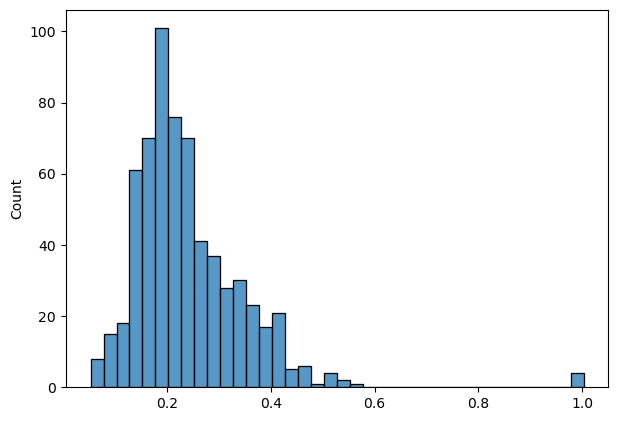

<Figure size 432x288 with 0 Axes>

In [56]:
## data path
gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask"
# result_dirname = "center"
# pred_type = "from_obb"

# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center"
# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center"
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou"
# result_dirname = None
# pred_type = "from_seg_list"

# test_chair_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"
# test_table_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"
# test_storage_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"
test_chair_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_table_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_storage_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_bed_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Bed-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
result_dirname = None
pred_type = "from_seg_mask_h5"

### hyper-param
gt_type = "surface"
# gt_type = "cuboids"
only_vis_parts = False # True
center = False #"mean_center" # "center"

# alg_name = "ave_part_min_chamfer_dist"
# alg_name = "part_pred_f1_0.1"
# alg_name = "part_pred_f1_0.05"
alg_name = "ave_part_matched_chamfer_dist"
# alg_name = "matched_part_pred_f1_0.1"
# alg_name = "matched_part_pred_f1_0.05"
# alg_name = "matched_part_pred_f1_0.2"
save_top_k = 10
num_pts_sampled_from_obb = 1024
num_pts_sampled_from_gt = 1024 # more like a max number, since sample_surface_even will reject close pair
save_metric_distribution = True

# class_list=['chair', 'table', 'storagefurniture']
class_list = ["table"]
# class_list = ["table",  'storagefurniture']
# class_list = ["bed"]
# class_list=['chair', 'table', 'storagefurniture', 'bed']


result_name = alg_name + "_" + gt_type
if only_vis_parts: 
    result_name += "_vis_only" 
if center: 
    result_name += "_" + center

gt_base_dir = Path(gt_base_dir)
gt_surface_pts_base_dir = Path(gt_surface_pts_base_dir)
iou_cls_result = {}
for category in class_list:
    if pred_type == "from_seg_mask_h5":
        if category == "chair": test_cls_dir = Path(test_chair_base_dir)
        elif category == "table": test_cls_dir = Path(test_table_base_dir)
        elif category == "storagefurniture": test_cls_dir = Path(test_storage_base_dir)
        elif category == "bed": test_cls_dir = Path(test_bed_base_dir)
        else: raise NotImplementedError(f"Unknown category: {category}")
    else:
        test_base_dir = Path(test_base_dir)
        test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")
    gt_cls_dir = gt_base_dir / category

    # get obj list
    if pred_type == "from_obb":
        obj_list = [x.stem for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*")]
    elif pred_type == "from_seg_list":
        obj_list = [x.stem.split(".")[0] for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*.pred_seg_list.pkl")]
    else:
        obj_list = [x.stem.split(".")[0] for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*.h5")]
    print(f"Run {result_name} for {category}, test number: {len(obj_list)} at '{test_cls_dir}'")

    metric_list = [] # record metric for each sample
    for obj_id in tqdm(obj_list):
        rotmat = get_rotmat_from_filename(obj_id) # canonical to world

        ## Process gt part pts list
        gt_obj_file = gt_cls_dir / obj_id / f'{obj_id}.npy'
        gt_obj_info = np.load(gt_obj_file, allow_pickle=True).item()
        if gt_type == "surface":
            anno_id = obj_id.split("_rx")[0]            
            gt_part_obj_dir = gt_surface_pts_base_dir / anno_id / "objs" 
            gt_part_pts_list = get_part_pcds_from_gt_obj(gt_obj_info, gt_part_obj_dir, 
                                                         num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                         only_vis_parts=only_vis_parts, center=center)
        else: # from cuboids
            gt_part_pts_list = get_part_pcds_from_gt_obb(gt_obj_info, rotmat, 
                                                         num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                         only_vis_parts=only_vis_parts, center=center)

        ## Retrieve pred pts
        if pred_type == "from_obb": # sample pts from obb
            pred_obb_file = test_cls_dir / obj_id / f'{obj_id}.npy' # from shapegraph
            pred_part_pts_list = get_part_pcds_from_pred_obb(pred_obb_file, rotmat, 
                                                             num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                            center=center)
        elif pred_type == "from_seg_list": # use predicted segmented pts
            pred_pts_file = f"{test_cls_dir}/{obj_id}.pred_seg_list.pkl"
            pred_part_pts_list = get_part_pcds_from_pred_seg_pts(pred_pts_file, rotmat=None,
                                                                 num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                 center=center)
        elif pred_type == "from_seg_mask_h5":
            pred_pts_file = f"{test_cls_dir}/{obj_id}.npy"
            pred_mask_file = f"{test_cls_dir}/{obj_id}.h5"
            pred_part_pts_list = get_part_pcds_from_pred_partnet_seg_pts(pred_pts_file, pred_mask_file, rotmat=None,
                                                                         num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                         center=center)
        else:
            raise NotImplementedError(f"Unknown pred_type: {pred_type}")

        ## compute metric
        if alg_name == "ave_part_min_chamfer_dist":
            obj_metric = ave_part_min_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
        elif alg_name == "part_pred_f1_0.1":
            obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
        elif alg_name == "part_pred_f1_0.05":
            obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
        elif alg_name == "ave_part_matched_chamfer_dist":
            obj_metric = ave_part_matched_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
        elif alg_name == "matched_part_pred_f1_0.1":
            obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
        elif alg_name == "matched_part_pred_f1_0.05":
            obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
        elif alg_name == "matched_part_pred_f1_0.2":
            obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.2, debug=False)
        else:
            raise NotImplementedError(f"Unknown alg: {alg_name}")
        metric_list.append(obj_metric)

    ## compute iou and related statistics
    metric_list = np.array(metric_list)        
    mean_metric = np.mean(metric_list).item()
    sorted_ind = np.argpartition(metric_list, [save_top_k, -save_top_k])
    top_k_ind = sorted_ind[-save_top_k:]
    top_k_ind = top_k_ind[np.argsort(metric_list[top_k_ind])]
    top_k_ind = top_k_ind[::-1] # decreasing order
    bottom_k_ind = sorted_ind[:save_top_k]
    bottom_k_ind = bottom_k_ind[np.argsort(metric_list[bottom_k_ind])]
    obj_list = np.array(obj_list)

    result = {
        "metric": round(mean_metric, 6),
        "top_k_obj": obj_list[top_k_ind].tolist(),
        "top_k": metric_list[top_k_ind].tolist(),
        "bottom_k_obj": obj_list[bottom_k_ind].tolist(),
        "bottom_k": metric_list[bottom_k_ind].tolist(),
    }
    color_print(f"---- {result_name} IoU for {category}: {mean_metric}")
    print(result)
    out_pts_file = test_cls_dir / f'metric_{result_name}.json'
    print("Save result at", out_pts_file)
    dump_json(str(out_pts_file), result)
    iou_cls_result[category] = result

    if save_metric_distribution:
        plt.figure(figsize=(7,5), dpi=100)
        sns.histplot(metric_list, binwidth=0.025)
        out_pts_file = test_cls_dir / f'metric_{result_name}.jpg'
        plt.show()
        plt.savefig(str(out_pts_file))
# iou_cls_result

In [47]:
tmp_pts = np.load("/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale/34279_rx344_ry351_rz0.npy")
print_pts_stat(tmp_pts[0])

shape: (10000, 3) max_norm: 0.9999999999999999 mean: [ 0. -0. -0.] max: [0.7284  0.36973 0.49837] min: [-0.77696 -0.5514  -0.59966]


In [49]:
pred_mask_info = h5py.File("/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale/34279_rx344_ry351_rz0.h5", "r")
pred_mask = pred_mask_info["mask"][0] # [200, 1024]
pred_valid = pred_mask_info["valid"][0] # [200]
pred_conf = pred_mask_info["conf"][0] # [200]
np.sum(pred_valid)

0

In [48]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(tmp_pts[0])
o3d.io.write_point_cloud("./pred_pts.ply", pcd)

True

Run ave_part_matched_chamfer_dist_surface_vis_only_center for chair, test number: 574 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/center'


100%|██████████| 574/574 [03:29<00:00,  2.74it/s]


---- ave_part_matched_chamfer_dist_surface_vis_only_center IoU for chair: 0.10176154398045498
{'metric': 0.101762, 'top_k_obj': ['40539_rx317_ry78_rz0', '43330_rx0_ry0_rz0', '3060_rx26_ry285_rz0', '44447_rx26_ry75_rz0', '37073_rx317_ry36_rz0', '38896_rx18_ry58_rz0', '38910_rx73_ry0_rz0', '38150_rx287_ry0_rz0', '40842_rx8_ry316_rz0', '37738_rx352_ry44_rz0'], 'top_k': [0.4783695191144943, 0.41721055949372904, 0.4049648803969224, 0.38938953541219234, 0.37174628325738013, 0.3519917004383527, 0.34950638686617214, 0.3462843516220649, 0.3403020665049553, 0.33862750108043355], 'bottom_k_obj': ['43831_rx324_ry302_rz0', '38852_rx43_ry324_rz0', '41731_rx352_ry316_rz0', '40899_rx9_ry286_rz0', '44115_rx342_ry58_rz0', '41515_rx8_ry44_rz0', '2775_rx352_ry316_rz0', '42870_rx352_ry316_rz0', '38270_rx0_ry328_rz0', '38374_rx314_ry348_rz0'], 'bottom_k': [0.017786015911648672, 0.017881919430302724, 0.019293425022624433, 0.019350213184952735, 0.019438906624499295, 0.019652699353173375, 0.02023265002803369, 

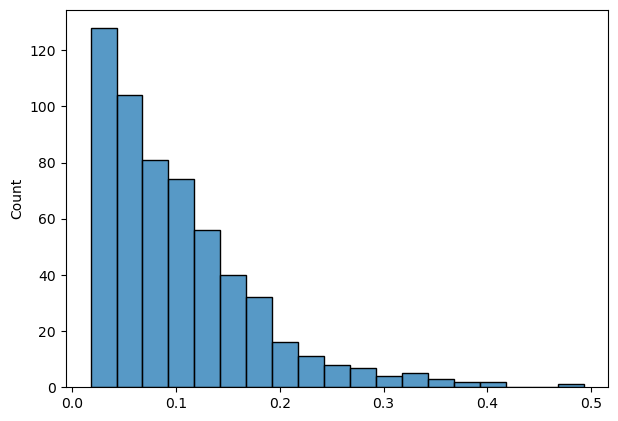

Run ave_part_matched_chamfer_dist_surface_vis_only_center for table, test number: 639 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/center'


100%|██████████| 639/639 [02:41<00:00,  3.96it/s]

---- ave_part_matched_chamfer_dist_surface_vis_only_center IoU for table: 0.15708164514576753
{'metric': 0.157082, 'top_k_obj': ['31173_rx317_ry282_rz0', '21766_rx72_ry60_rz0', '24015_rx9_ry286_rz0', '20144_rx288_ry60_rz0', '30010_rx317_ry78_rz0', '21369_rx317_ry36_rz0', '20225_rx288_ry300_rz0', '21351_rx0_ry301_rz0', '31543_rx317_ry282_rz0', '31135_rx334_ry75_rz0'], 'top_k': [0.5204667512859616, 0.3911791018077305, 0.36720186471939087, 0.3652964574950082, 0.34857966129978496, 0.34764276072382927, 0.34280801862478255, 0.3417515896260738, 0.34009509682655337, 0.3358710464090109], 'bottom_k_obj': ['28981_rx352_ry316_rz0', '28710_rx317_ry282_rz0', '21733_rx329_ry0_rz0', '21025_rx43_ry282_rz0', '21040_rx8_ry44_rz0', '28238_rx352_ry44_rz0', '30421_rx36_ry58_rz0', '24378_rx342_ry302_rz0', '31336_rx342_ry58_rz0', '23762_rx329_ry0_rz0'], 'bottom_k': [0.027769137639552355, 0.028594521805644035, 0.029669511877000333, 0.03140899315476418, 0.033467506524175406, 0.03374078702181578, 0.0345873173015

<Figure size 432x288 with 0 Axes>

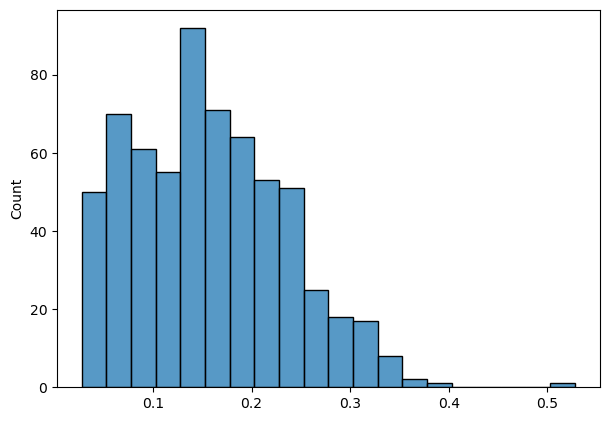

Run ave_part_matched_chamfer_dist_surface_vis_only_center for storagefurniture, test number: 670 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/center'


100%|██████████| 670/670 [05:03<00:00,  2.21it/s]


---- ave_part_matched_chamfer_dist_surface_vis_only_center IoU for storagefurniture: 0.17594959628026807
{'metric': 0.17595, 'top_k_obj': ['47607_rx18_ry302_rz0', '45100_rx43_ry78_rz0', '49086_rx16_ry9_rz0', '48696_rx58_ry0_rz0', '46525_rx302_ry0_rz0', '46209_rx288_ry60_rz0', '46725_rx16_ry351_rz0', '48504_rx317_ry78_rz0', '45000_rx8_ry44_rz0', '47900_rx300_ry332_rz0'], 'top_k': [0.4000926874577999, 0.3590266580382983, 0.3503901958465576, 0.34761765971779823, 0.3434323091059923, 0.3348750040999481, 0.33304128689425333, 0.32872190574804944, 0.32431376725435257, 0.323010899592191], 'bottom_k_obj': ['49025_rx329_ry0_rz0', '47808_rx334_ry41_rz0', '49191_rx324_ry302_rz0', '47093_rx0_ry343_rz0', '45862_rx60_ry28_rz0', '47388_rx344_ry9_rz0', '49220_rx43_ry36_rz0', '47561_rx344_ry9_rz0', '46732_rx334_ry41_rz0', '41081_rx18_ry302_rz0'], 'bottom_k': [0.05276705138385296, 0.058001947278777756, 0.06148912555848559, 0.06390549787985426, 0.06518315616995096, 0.0661678503267467, 0.07048746118588108, 

<Figure size 432x288 with 0 Axes>

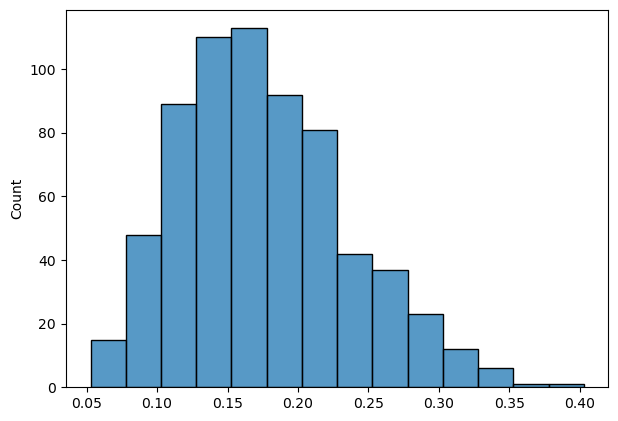

Run ave_part_matched_chamfer_dist_surface_vis_only_center for bed, test number: 657 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/bed/center'


100%|██████████| 657/657 [03:57<00:00,  2.77it/s]


---- ave_part_matched_chamfer_dist_surface_vis_only_center IoU for bed: 0.18228230189835665
{'metric': 0.182282, 'top_k_obj': ['11567_rx73_ry0_rz0', '12524_rx344_ry351_rz0', '11567_rx0_ry0_rz0', '12319_rx31_ry0_rz0', '13097_rx31_ry0_rz0', '12457_rx36_ry302_rz0', '11592_rx0_ry301_rz0', '10961_rx26_ry285_rz0', '11297_rx314_ry12_rz0', '12672_rx302_ry0_rz0'], 'top_k': [0.4646369976301988, 0.4554280549287796, 0.45228994141022366, 0.39160253959042685, 0.37548983842134476, 0.3674550987780094, 0.3659949738532305, 0.36090664751827717, 0.35278574625651044, 0.3526722834342056], 'bottom_k_obj': ['12524_rx26_ry41_rz0', '12524_rx14_ry27_rz0', '10165_rx288_ry300_rz0', '10165_rx14_ry27_rz0', '12493_rx306_ry302_rz0', '12524_rx342_ry58_rz0', '11062_rx18_ry58_rz0', '12442_rx352_ry316_rz0', '10165_rx0_ry328_rz0', '12785_rx314_ry12_rz0'], 'bottom_k': [0.03735616486519575, 0.04297489098583659, 0.056895301677286625, 0.05789925282200178, 0.0642397589981556, 0.067048413058122, 0.06751452510555585, 0.0677629423

<Figure size 432x288 with 0 Axes>

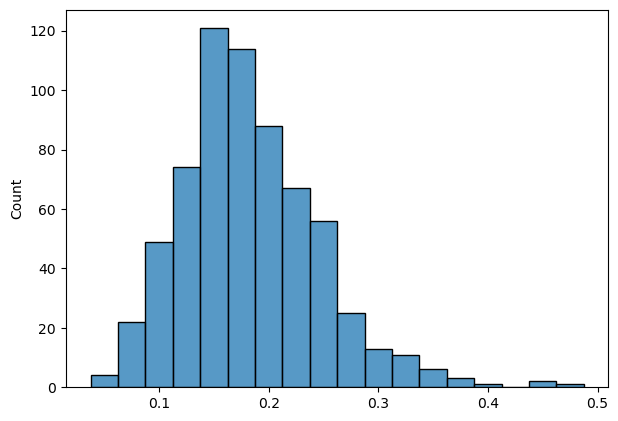

Run matched_part_pred_f1_0.1_surface_vis_only_center for chair, test number: 574 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/center'


100%|██████████| 574/574 [03:41<00:00,  2.59it/s]

---- matched_part_pred_f1_0.1_surface_vis_only_center IoU for chair: 0.6144998826260719
{'metric': 0.6145, 'top_k_obj': ['40883_rx43_ry324_rz0', '2935_rx351_ry74_rz0', '41351_rx26_ry41_rz0', '40845_rx330_ry21_rz0', '2673_rx43_ry36_rz0', '41818_rx26_ry41_rz0', '41752_rx287_ry0_rz0', '43009_rx302_ry0_rz0', '38400_rx342_ry302_rz0', '3375_rx18_ry302_rz0'], 'top_k': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'bottom_k_obj': ['37073_rx317_ry36_rz0', '41325_rx8_ry316_rz0', '41151_rx317_ry282_rz0', '37011_rx334_ry41_rz0', '40539_rx317_ry78_rz0', '37738_rx352_ry44_rz0', '38551_rx60_ry332_rz0', '43766_rx334_ry75_rz0', '42641_rx314_ry12_rz0', '38150_rx287_ry0_rz0'], 'bottom_k': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Save result at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/chair/center/metric_matched_part_pred_f1_0.1_surface_vis_only_center.json


<Figure size 432x288 with 0 Axes>

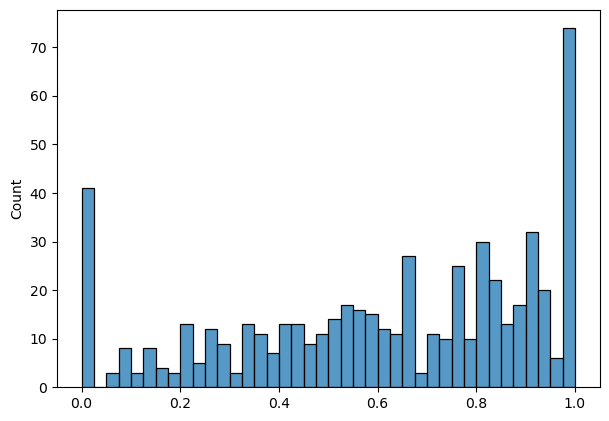

Run matched_part_pred_f1_0.1_surface_vis_only_center for table, test number: 639 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/center'


100%|██████████| 639/639 [02:32<00:00,  4.18it/s]

---- matched_part_pred_f1_0.1_surface_vis_only_center IoU for table: 0.3461295606707596
{'metric': 0.34613, 'top_k_obj': ['19969_rx346_ry27_rz0', '23365_rx46_ry348_rz0', '23726_rx0_ry17_rz0', '27474_rx0_ry328_rz0', '30178_rx60_ry28_rz0', '30162_rx344_ry351_rz0', '19576_rx43_ry36_rz0', '29025_rx31_ry0_rz0', '21733_rx329_ry0_rz0', '22596_rx46_ry12_rz0'], 'top_k': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'bottom_k_obj': ['19385_rx300_ry332_rz0', '25081_rx317_ry78_rz0', '27181_rx26_ry75_rz0', '24275_rx330_ry21_rz0', '19162_rx317_ry78_rz0', '24944_rx302_ry0_rz0', '20395_rx26_ry285_rz0', '27994_rx60_ry28_rz0', '26323_rx31_ry0_rz0', '30481_rx18_ry302_rz0'], 'bottom_k': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Save result at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/center/metric_matched_part_pred_f1_0.1_surface_vis_only_center.json


<Figure size 432x288 with 0 Axes>

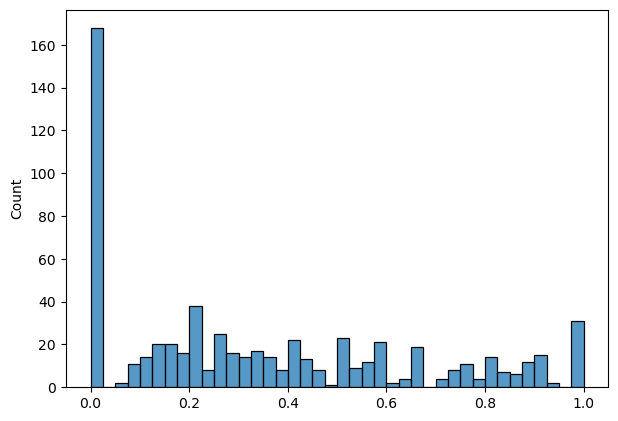

Run matched_part_pred_f1_0.1_surface_vis_only_center for storagefurniture, test number: 670 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/center'


100%|██████████| 670/670 [04:41<00:00,  2.38it/s]


---- matched_part_pred_f1_0.1_surface_vis_only_center IoU for storagefurniture: 0.20582385816774548
{'metric': 0.205824, 'top_k_obj': ['49191_rx324_ry302_rz0', '45947_rx72_ry60_rz0', '47389_rx0_ry32_rz0', '45838_rx0_ry17_rz0', '45867_rx0_ry32_rz0', '47093_rx0_ry343_rz0', '46083_rx317_ry36_rz0', '47808_rx334_ry41_rz0', '48528_rx344_ry9_rz0', '48790_rx36_ry58_rz0'], 'top_k': [0.923076923076923, 0.8, 0.8, 0.7999999999999999, 0.7894736842105262, 0.7878787878787878, 0.7692307692307693, 0.7499999999999999, 0.7200000000000001, 0.7058823529411765], 'bottom_k_obj': ['47496_rx58_ry0_rz0', '48387_rx334_ry319_rz0', '47630_rx26_ry75_rz0', '48101_rx43_ry78_rz0', '45789_rx54_ry302_rz0', '46026_rx54_ry302_rz0', '46235_rx324_ry302_rz0', '45183_rx329_ry0_rz0', '48217_rx334_ry75_rz0', '47312_rx72_ry300_rz0'], 'bottom_k': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Save result at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/center/metric_matched_p

<Figure size 432x288 with 0 Axes>

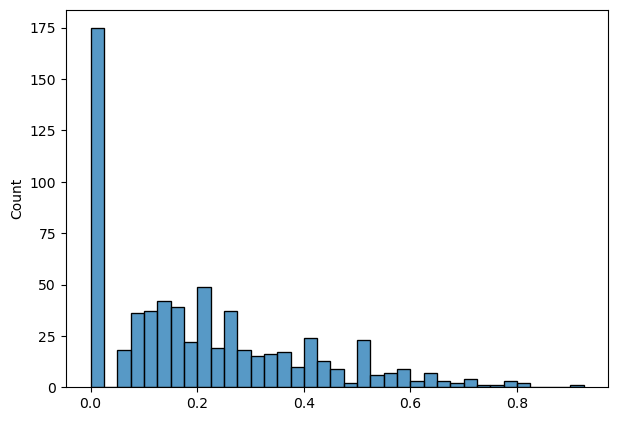

Run matched_part_pred_f1_0.1_surface_vis_only_center for bed, test number: 657 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/bed/center'


100%|██████████| 657/657 [03:59<00:00,  2.74it/s]


---- matched_part_pred_f1_0.1_surface_vis_only_center IoU for bed: 0.22389721701837753
{'metric': 0.223897, 'top_k_obj': ['12785_rx314_ry12_rz0', '13197_rx300_ry332_rz0', '11062_rx314_ry348_rz0', '10165_rx288_ry300_rz0', '12493_rx306_ry302_rz0', '11062_rx18_ry58_rz0', '12493_rx300_ry332_rz0', '10165_rx0_ry328_rz0', '12517_rx317_ry324_rz0', '11287_rx0_ry59_rz0'], 'top_k': [1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8, 0.8, 0.75], 'bottom_k_obj': ['10460_rx36_ry58_rz0', '13097_rx43_ry324_rz0', '12774_rx287_ry0_rz0', '11547_rx36_ry302_rz0', '11297_rx314_ry12_rz0', '13097_rx306_ry302_rz0', '12467_rx16_ry351_rz0', '12275_rx0_ry32_rz0', '11196_rx302_ry0_rz0', '11338_rx302_ry0_rz0'], 'bottom_k': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Save result at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/bed/center/metric_matched_part_pred_f1_0.1_surface_vis_only_center.json


<Figure size 432x288 with 0 Axes>

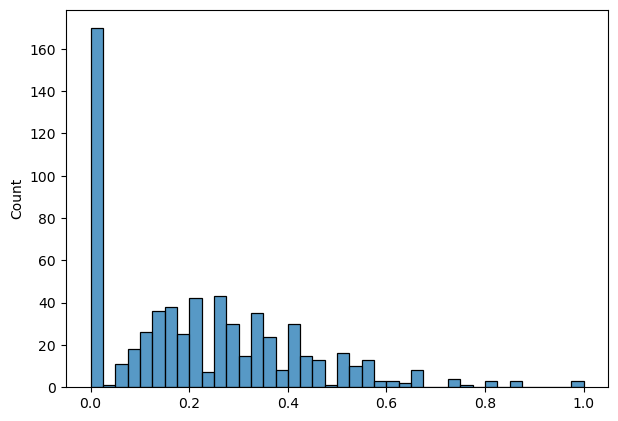

<Figure size 432x288 with 0 Axes>

In [13]:
# multiple metrics
## data path
gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask"
result_dirname = "center"
pred_type = "from_obb"

# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center"
# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center"
# test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou"
# result_dirname = None
# pred_type = "from_seg_list"

# test_chair_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# test_table_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# test_storage_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# test_bed_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Bed-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# result_dirname = None
# pred_type = "from_seg_mask_h5"

### hyper-param
gt_type = "surface"
# gt_type = "cuboids"
only_vis_parts = True #False # True
center = "center" #"mean_center" # "center"

# alg_name = "ave_part_min_chamfer_dist"
# alg_name = "part_pred_f1_0.1"
# alg_name = "part_pred_f1_0.05"
# alg_name = "ave_part_matched_chamfer_dist"
# alg_name = "matched_part_pred_f1_0.1"
# alg_name = "matched_part_pred_f1_0.05"
# alg_name = "matched_part_pred_f1_0.2"
# alg_list = ["ave_part_matched_chamfer_dist", "matched_part_pred_f1_0.2", "matched_part_pred_f1_0.1", "matched_part_pred_f1_0.05"]
alg_list = ["ave_part_matched_chamfer_dist", "matched_part_pred_f1_0.1", ]
save_top_k = 10
num_pts_sampled_from_obb = 1024
num_pts_sampled_from_gt = 1024 # more like a max number, since sample_surface_even will reject close pair
save_metric_distribution = True

# class_list=['chair', 'table', 'storagefurniture']
# class_list = ["table"]
# class_list = ["table",  'storagefurniture']
# class_list = ["bed"]
class_list=['chair', 'table', 'storagefurniture', 'bed']

gt_base_dir = Path(gt_base_dir)
gt_surface_pts_base_dir = Path(gt_surface_pts_base_dir)
for alg_name in alg_list:
    result_name = alg_name + "_" + gt_type
    if only_vis_parts: 
        result_name += "_vis_only" 
    if center: 
        result_name += "_" + center
    
    iou_cls_result = {}
    for category in class_list:
        if pred_type == "from_seg_mask_h5":
            if category == "chair": test_cls_dir = Path(test_chair_base_dir)
            elif category == "table": test_cls_dir = Path(test_table_base_dir)
            elif category == "storagefurniture": test_cls_dir = Path(test_storage_base_dir)
            elif category == "bed": test_cls_dir = Path(test_bed_base_dir)
            else: raise NotImplementedError(f"Unknown category: {category}")
        else:
            test_base_dir = Path(test_base_dir)
            test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")
        gt_cls_dir = gt_base_dir / category

        # get obj list
        if pred_type == "from_obb":
            obj_list = [x.stem for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*")]
        elif pred_type == "from_seg_list":
            obj_list = [x.stem.split(".")[0] for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*.pred_seg_list.pkl")]
        else:
            obj_list = [x.stem.split(".")[0] for x in test_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*.h5")]
        print(f"Run {result_name} for {category}, test number: {len(obj_list)} at '{test_cls_dir}'")

        metric_list = [] # record metric for each sample
        for obj_id in tqdm(obj_list):
            rotmat = get_rotmat_from_filename(obj_id) # canonical to world

            ## Process gt part pts list
            gt_obj_file = gt_cls_dir / obj_id / f'{obj_id}.npy'
            gt_obj_info = np.load(gt_obj_file, allow_pickle=True).item()
            if gt_type == "surface":
                anno_id = obj_id.split("_rx")[0]            
                gt_part_obj_dir = gt_surface_pts_base_dir / anno_id / "objs" 
                gt_part_pts_list = get_part_pcds_from_gt_obj(gt_obj_info, gt_part_obj_dir, 
                                                             num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                             only_vis_parts=only_vis_parts, center=center)
            else: # from cuboids
                gt_part_pts_list = get_part_pcds_from_gt_obb(gt_obj_info, rotmat, 
                                                             num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                             only_vis_parts=only_vis_parts, center=center)

            ## Retrieve pred pts
            if pred_type == "from_obb": # sample pts from obb
                pred_obb_file = test_cls_dir / obj_id / f'{obj_id}.npy' # from shapegraph
                pred_part_pts_list = get_part_pcds_from_pred_obb(pred_obb_file, rotmat, 
                                                                 num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                center=center)
            elif pred_type == "from_seg_list": # use predicted segmented pts
                pred_pts_file = f"{test_cls_dir}/{obj_id}.pred_seg_list.pkl"
                pred_part_pts_list = get_part_pcds_from_pred_seg_pts(pred_pts_file, rotmat=None,
                                                                     num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                     center=center)
            elif pred_type == "from_seg_mask_h5":
                pred_pts_file = f"{test_cls_dir}/{obj_id}.npy"
                pred_mask_file = f"{test_cls_dir}/{obj_id}.h5"
                pred_part_pts_list = get_part_pcds_from_pred_partnet_seg_pts(pred_pts_file, pred_mask_file, rotmat=None,
                                                                             num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                             center=center)
            else:
                raise NotImplementedError(f"Unknown pred_type: {pred_type}")

            ## compute metric
            if alg_name == "ave_part_min_chamfer_dist":
                obj_metric = ave_part_min_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
            elif alg_name == "part_pred_f1_0.1":
                obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
            elif alg_name == "part_pred_f1_0.05":
                obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
            elif alg_name == "ave_part_matched_chamfer_dist":
                obj_metric = ave_part_matched_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
            elif alg_name == "matched_part_pred_f1_0.1":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
            elif alg_name == "matched_part_pred_f1_0.05":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
            elif alg_name == "matched_part_pred_f1_0.2":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.2, debug=False)
            else:
                raise NotImplementedError(f"Unknown alg: {alg_name}")
            metric_list.append(obj_metric)

        ## compute iou and related statistics
        metric_list = np.array(metric_list)        
        mean_metric = np.mean(metric_list).item()
        sorted_ind = np.argpartition(metric_list, [save_top_k, -save_top_k])
        top_k_ind = sorted_ind[-save_top_k:]
        top_k_ind = top_k_ind[np.argsort(metric_list[top_k_ind])]
        top_k_ind = top_k_ind[::-1] # decreasing order
        bottom_k_ind = sorted_ind[:save_top_k]
        bottom_k_ind = bottom_k_ind[np.argsort(metric_list[bottom_k_ind])]
        obj_list = np.array(obj_list)

        result = {
            "metric": round(mean_metric, 6),
            "top_k_obj": obj_list[top_k_ind].tolist(),
            "top_k": metric_list[top_k_ind].tolist(),
            "bottom_k_obj": obj_list[bottom_k_ind].tolist(),
            "bottom_k": metric_list[bottom_k_ind].tolist(),
        }
        color_print(f"---- {result_name} IoU for {category}: {mean_metric}")
        print(result)
        out_pts_file = test_cls_dir / f'metric_{result_name}.json'
        print("Save result at", out_pts_file)
        dump_json(str(out_pts_file), result)
        iou_cls_result[category] = result

        if save_metric_distribution:
            plt.figure(figsize=(7,5), dpi=100)
            sns.histplot(metric_list, binwidth=0.025)
            out_pts_file = test_cls_dir / f'metric_{result_name}.jpg'
            plt.show()
            plt.savefig(str(out_pts_file))
    # iou_cls_result

In [6]:
## check pts mean, max, norm
gt_pts = np.concatenate(gt_part_pts_list, axis=0)
print(len(gt_part_pts_list))
np.linalg.norm(gt_pts, axis=-1).max(), gt_pts.mean(axis=0), gt_pts.max(axis=0), gt_pts.min(axis=0), gt_pts.shape

10


(1.0161812,
 array([-0.01506348, -0.151719  ,  0.03497552], dtype=float32),
 array([0.77424043, 0.617275  , 0.20717001], dtype=float32),
 array([-0.78307694, -0.6418785 , -0.137147  ], dtype=float32),
 (10240, 3))

In [7]:
pred_pts = np.concatenate(pred_part_pts_list, axis=0)
print(len(pred_part_pts_list))
pred_pts.shape, pred_pts.mean(axis=0), np.linalg.norm(pred_pts, axis=-1).max(), pred_pts.max(axis=0), pred_pts.min(axis=0)

25


((1936, 3),
 array([0.00083502, 0.00039403, 0.00056227], dtype=float32),
 1.0,
 array([0.5066465 , 0.76067823, 0.3852061 ], dtype=float32),
 array([-0.5297067 , -0.9980852 , -0.40244052], dtype=float32))

In [8]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(gt_pts)
o3d.io.write_point_cloud("./gt_pts.ply", pcd)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pred_pts)
o3d.io.write_point_cloud("./pred_pts.ply", pcd)

True

In [9]:
obj_id

'46622_rx9_ry286_rz0'

<AxesSubplot:ylabel='Count'>

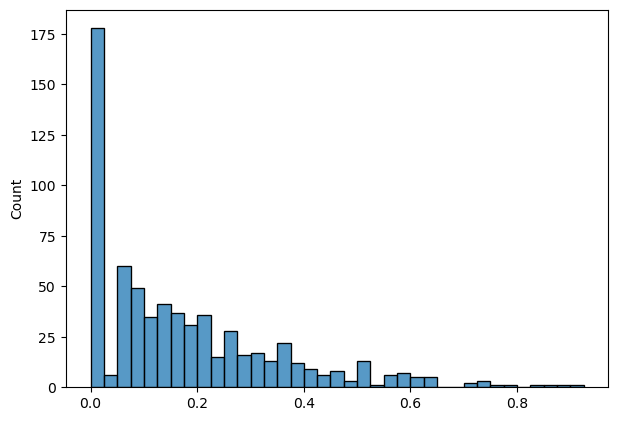

In [27]:
# if save_metric_distribution:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(metric_list, binwidth=0.025)
# plt.savefig("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/center/"+f'metric_{result_name}.jpg')

### ##scratch

In [17]:
a = torch.tensor([[1,0,0], [0,-1,-1]], device=device, dtype=float)
b = torch.tensor([[0,0,0], [1,-2,0], [0,0,0]], device=device, dtype=float)
dist1, dist2 = chamfer_distance(a,b, sqrt=True)
dist1, dist2, dist1.mean(), dist2.mean()

(tensor([[1.0000, 1.4142]], device='cuda:0', dtype=torch.float64),
 tensor([[1.0000, 1.7321, 1.0000]], device='cuda:0', dtype=torch.float64),
 tensor(1.2071, device='cuda:0', dtype=torch.float64),
 tensor(1.2440, device='cuda:0', dtype=torch.float64))

In [44]:
gt_surface_pts_file = "/sf-fast2/DATA/data_v0/692/point_sample/sample-points-all-pts-label-10000.ply"

# gt_surface_pts_file = gt_surface_pts_base_dir / anno_id / "point_sample" / "ply-10000.ply"
# assert gt_surface_pts_file.exists(), f"Cannot find: {str(gt_surface_pts_file)}"
 
pcd = o3d.io.read_point_cloud(str(gt_surface_pts_file))
gt_surface_pts = np.asarray(pcd.points)

In [45]:
colors = np.asarray(pcd.colors)
color_str = np.array([np.array_str(i) for i in colors])
unique_color = np.unique(color_str)
print(unique_color.shape, unique_color)

(11,) ['[0.         0.49803922 0.49803922]' '[0. 0. 1.]' '[0. 1. 0.]'
 '[0.29803922 0.         0.6       ]' '[0.29803922 0.6        0.        ]'
 '[0.49803922 0.         0.49803922]' '[0.49803922 0.49803922 0.        ]'
 '[0.6        0.         0.29803922]' '[0.6        0.29803922 0.        ]'
 '[0.8        0.2        0.49803922]' '[1. 0. 0.]']


In [14]:
label_path = "/sf-fast2/DATA/data_v0/692/point_sample/label-10000.txt"
label = np.loadtxt(label_path).astype(int)
# unique_label = np.unique(label)
# print(unique_label)
# print(unique_label.shape)
unique_label = set(label)
unique_label, len(unique_label)

({18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 37, 38, 39, 40, 41, 42, 43, 44}, 18)

In [24]:
## gt obj info npy 
# result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/bed/9981_rx0_ry343_rz0/9981_rx0_ry343_rz0.npy"
result_path = "/q5chen-cephfs/project_file/testComp/CompNet/data/test/chair/40713_rx36_ry58_rz0/40713_rx36_ry58_rz0.npy"
results = np.load(result_path, allow_pickle=True).item()
# type(results), #results
print(results.keys())
obb = {node:item["box"] for node, item in results["nodes"].items()}
# obb.keys(), len(obb.keys()), obb
len(results["nodes"])

dict_keys(['nodes', 'edges', 'vis_parts', 'edge_parallel'])


14

In [25]:
results["nodes"]

{3: {'id': 3,
  'label': 'back_single_surface',
  'box': array([ 0.0159308 ,  0.53309851,  0.02139577,  0.10881977,  0.33287105,
          0.69553643, -0.82122075,  0.22759741, -0.52325509, -0.20144394,
         -0.97360221, -0.10732699]),
  'objs': ['new-16', 'new-14'],
  'visible': True,
  'bbox': array([0.51953125, 0.25195312, 0.1640625 , 0.15234375])},
 5: {'id': 5,
  'label': 'back_frame_vertical_bar',
  'box': array([ 0.17531178,  0.39569136, -0.31167215,  0.12522879,  0.16963363,
          0.6034404 ,  0.56188852, -0.00641282, -0.82718811,  0.71905726,
         -0.49056643,  0.49224104]),
  'objs': ['new-12', 'new-9'],
  'visible': True,
  'bbox': array([0.55273438, 0.29296875, 0.12109375, 0.1953125 ])},
 6: {'id': 6,
  'label': 'back_frame_vertical_bar',
  'box': array([-0.19789158,  0.3846265 ,  0.29075043,  0.136143  ,  0.18504798,
          0.61899012,  0.51603763,  0.00235023, -0.85656269,  0.74577126,
         -0.49312947,  0.4479381 ]),
  'objs': ['new-13', 'new-7'],
  'v

In [5]:
gt_surface_pts_file = "/sf-fast2/DATA/data_v0/692/point_sample/pts-10000.txt"
gt_pts = np.loadtxt(gt_surface_pts_file)
gt_pts.shape

(10000, 3)

In [13]:
obj_path = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_outputs_chair/691_rx72_ry60_rz0.obj"
trimesh.load(obj_path)

<trimesh.Trimesh(vertices.shape=(80712, 3), faces.shape=(160820, 3))>

### Plot 3d

In [8]:
#
## ours
## chair top ave part min
# top_k_obj_list = ['40251_rx346_ry333_rz0', '40958_rx342_ry302_rz0', '40842_rx8_ry316_rz0', '41461_rx306_ry302_rz0', '37730_rx317_ry282_rz0', '41777_rx334_ry41_rz0', '48829_rx334_ry285_rz0', '2972_rx334_ry319_rz0', '40896_rx346_ry27_rz0', '40410_rx0_ry17_rz0']
## chair min ave part min
# top_k_obj_list = ['37988_rx342_ry58_rz0', '2865_rx317_ry324_rz0', '41351_rx26_ry41_rz0', '37430_rx8_ry44_rz0', '43831_rx324_ry302_rz0', '43515_rx26_ry41_rz0', '2673_rx43_ry36_rz0', '2728_rx14_ry27_rz0', '45078_rx0_ry343_rz0', '40057_rx0_ry343_rz0']
## chair top f1_0.1
# top_k_obj_list = ["37256_rx300_ry332_rz0", "37430_rx8_ry44_rz0", "2865_rx317_ry324_rz0", "37988_rx342_ry58_rz0", "43449_rx306_ry58_rz0", "40537_rx26_ry285_rz0", "41351_rx26_ry41_rz0", "43831_rx324_ry302_rz0", "38374_rx314_ry348_rz0", "43650_rx9_ry74_rz0"]
## chair top f1_0.05
# top_k_obj_list = ['41351_rx26_ry41_rz0', '37430_rx8_ry44_rz0', '43515_rx26_ry41_rz0', '37988_rx342_ry58_rz0', '2865_rx317_ry324_rz0', '2673_rx43_ry36_rz0', '43831_rx324_ry302_rz0', '40996_rx317_ry36_rz0', '2728_rx14_ry27_rz0', '40990_rx314_ry12_rz0']
## table top ave part min
# top_k_obj_list = ['31173_rx317_ry282_rz0', '29710_rx342_ry302_rz0', '28981_rx352_ry316_rz0', '27130_rx26_ry285_rz0', '27124_rx342_ry58_rz0', '29373_rx334_ry75_rz0', '27558_rx342_ry302_rz0', '25622_rx334_ry319_rz0', '34018_rx324_ry58_rz0', '24618_rx317_ry282_rz0']
## table min ave part min
# top_k_obj_list = ['25043_rx0_ry328_rz0', '21733_rx329_ry0_rz0', '22133_rx43_ry282_rz0', '28240_rx334_ry75_rz0', '24628_rx314_ry348_rz0', '18991_rx317_ry36_rz0', '24378_rx342_ry302_rz0', '31491_rx0_ry59_rz0', '20973_rx0_ry17_rz0', '19969_rx346_ry27_rz0']
## table top f1_0.1
# top_k_obj_list = ["31491_rx0_ry59_rz0", "20973_rx0_ry17_rz0", "19969_rx346_ry27_rz0", "28240_rx334_ry75_rz0", "24378_rx342_ry302_rz0", "18991_rx317_ry36_rz0", "24234_rx30_ry21_rz0", "25043_rx0_ry328_rz0", "21733_rx329_ry0_rz0", "22133_rx43_ry282_rz0"]
## table top f1_0.05
# top_k_obj_list = ['25043_rx0_ry328_rz0', '21733_rx329_ry0_rz0', '28240_rx334_ry75_rz0', '23762_rx329_ry0_rz0', '24628_rx314_ry348_rz0', '21025_rx43_ry282_rz0', '28973_rx43_ry324_rz0', '27846_rx43_ry36_rz0', '29709_rx43_ry324_rz0', '21040_rx8_ry44_rz0']
## furniture top ave part min
# top_k_obj_list = ['44748_rx60_ry28_rz0', '49020_rx346_ry333_rz0', '48527_rx334_ry41_rz0', '47130_rx300_ry332_rz0', '47564_rx31_ry0_rz0', '45440_rx352_ry316_rz0', '45785_rx54_ry302_rz0', '46660_rx46_ry348_rz0', '49246_rx288_ry60_rz0', '46217_rx342_ry58_rz0']
## furniture min ave part min
# top_k_obj_list = ['47093_rx0_ry343_rz0', '47612_rx346_ry333_rz0', '47985_rx0_ry0_rz0', '39588_rx0_ry32_rz0', '46833_rx0_ry17_rz0', '48528_rx344_ry9_rz0', '47561_rx344_ry9_rz0', '45635_rx334_ry41_rz0', '47370_rx344_ry9_rz0', '48577_rx0_ry328_rz0']
## furniture top f1_0.1
# top_k_obj_list = ["47093_rx0_ry343_rz0", "39588_rx0_ry32_rz0", "47370_rx344_ry9_rz0", "47612_rx346_ry333_rz0", "46833_rx0_ry17_rz0", "47985_rx0_ry0_rz0", "48344_rx8_ry44_rz0", "47561_rx344_ry9_rz0", "46219_rx16_ry351_rz0", "48577_rx0_ry328_rz0"]
## furniture top f1_0.05
# top_k_obj_list = ["47093_rx0_ry343_rz0", "47985_rx0_ry0_rz0", "48141_rx302_ry0_rz0", "45983_rx302_ry0_rz0", "47612_rx346_ry333_rz0", "46483_rx26_ry41_rz0", "49149_rx30_ry339_rz0", "47370_rx344_ry9_rz0", "46957_rx16_ry9_rz0", "45748_rx352_ry316_rz0"]

## genre
## chair top ave part min
# top_k_obj_list = ["37076_rx30_ry339_rz0", "37209_rx334_ry285_rz0", "37454_rx288_ry300_rz0", "43025_rx314_ry348_rz0", "44447_rx26_ry75_rz0", "38785_rx351_ry286_rz0", "43849_rx26_ry285_rz0", "3268_rx26_ry319_rz0", "38946_rx73_ry0_rz0", "41854_rx54_ry302_rz0"]
## chair min ave part min
# top_k_obj_list = ["42727_rx14_ry27_rz0", "37038_rx351_ry74_rz0", "40548_rx0_ry17_rz0", "41278_rx16_ry351_rz0", "41583_rx30_ry339_rz0", "38482_rx9_ry74_rz0", "41293_rx14_ry27_rz0", "43000_rx352_ry44_rz0", "41534_rx14_ry27_rz0", "42946_rx16_ry351_rz0"]
## chair top f1_0.1
# top_k_obj_list = ["40548_rx0_ry17_rz0", "41278_rx16_ry351_rz0", "37038_rx351_ry74_rz0", "38557_rx346_ry27_rz0", "42727_rx14_ry27_rz0", "37365_rx30_ry339_rz0", "42946_rx16_ry351_rz0", "43786_rx9_ry286_rz0", "38931_rx9_ry74_rz0", "41384_rx0_ry32_rz0"]
## table top ave part min
# top_k_obj_list = ["19162_rx317_ry78_rz0", "19469_rx314_ry12_rz0", "29201_rx288_ry60_rz0", "32925_rx306_ry302_rz0", "19774_rx334_ry75_rz0", "24758_rx26_ry75_rz0", "22610_rx324_ry302_rz0", "23467_rx342_ry58_rz0", "29659_rx72_ry300_rz0", "27130_rx26_ry285_rz0"]
## table min ave part min
# top_k_obj_list = ["34840_rx0_ry328_rz0", "23762_rx329_ry0_rz0", "26359_rx14_ry27_rz0", "19608_rx302_ry0_rz0", "21028_rx0_ry17_rz0", "27595_rx0_ry32_rz0", "22777_rx14_ry333_rz0", "24744_rx14_ry27_rz0", "28133_rx0_ry17_rz0", "27134_rx0_ry328_rz0"]
## table top f1_0.1
# top_k_obj_list = ["34840_rx0_ry328_rz0", "26359_rx14_ry27_rz0", "21546_rx14_ry333_rz0", "21028_rx0_ry17_rz0", "24543_rx0_ry59_rz0", "27134_rx0_ry328_rz0", "28133_rx0_ry17_rz0", "23762_rx329_ry0_rz0", "23504_rx346_ry333_rz0", "24744_rx14_ry27_rz0"]
## table top f1_0.05
# top_k_obj_list = ['26235_rx72_ry300_rz0', '19626_rx8_ry316_rz0', '27134_rx0_ry328_rz0', '25991_rx8_ry44_rz0', '22596_rx46_ry12_rz0', '24628_rx314_ry348_rz0', '26536_rx46_ry12_rz0', '24744_rx14_ry27_rz0', '25139_rx306_ry302_rz0', '24856_rx300_ry332_rz0']
## furniture top ave part min
# top_k_obj_list = ["49086_rx16_ry9_rz0", "47520_rx60_ry332_rz0", "45000_rx8_ry44_rz0", "47786_rx8_ry44_rz0", "47542_rx30_ry21_rz0", "49090_rx346_ry333_rz0", "45679_rx43_ry36_rz0", "47039_rx317_ry78_rz0", "48101_rx43_ry78_rz0", "46668_rx54_ry302_rz0"]
## furniture min ave part min
# top_k_obj_list = ["45995_rx351_ry74_rz0", "44820_rx314_ry348_rz0", "47328_rx317_ry324_rz0", "47386_rx16_ry351_rz0", "47757_rx8_ry316_rz0", "45942_rx314_ry348_rz0", "46395_rx0_ry343_rz0", "47370_rx344_ry9_rz0", "48358_rx317_ry36_rz0", "47166_rx16_ry351_rz0"]
## furniture top f1_0.1
# top_k_obj_list = ["45995_rx351_ry74_rz0", "47386_rx16_ry351_rz0", "47285_rx16_ry351_rz0", "46957_rx16_ry9_rz0", "46395_rx0_ry343_rz0", "47757_rx8_ry316_rz0", "47086_rx16_ry9_rz0", "46424_rx314_ry12_rz0", "47154_rx14_ry27_rz0", "47808_rx334_ry41_rz0"]

## genre seg by partnet
## chair top ave part min
# top_k_obj_list = ["37076_rx30_ry339_rz0", "37209_rx334_ry285_rz0", "37454_rx288_ry300_rz0", "43025_rx314_ry348_rz0", "44447_rx26_ry75_rz0", "38785_rx351_ry286_rz0", "43849_rx26_ry285_rz0", "3268_rx26_ry319_rz0", "38946_rx73_ry0_rz0", "41854_rx54_ry302_rz0"]
## chair min ave part min
# ['41819_rx8_ry316_rz0', '42727_rx14_ry27_rz0', '37038_rx351_ry74_rz0', '40057_rx0_ry343_rz0', '41583_rx30_ry339_rz0', '40548_rx0_ry17_rz0', '37272_rx0_ry17_rz0', '41278_rx16_ry351_rz0', '3006_rx0_ry17_rz0', '38482_rx9_ry74_rz0']
# top_k_obj_list = ["42727_rx14_ry27_rz0", "37038_rx351_ry74_rz0", "40548_rx0_ry17_rz0", "41278_rx16_ry351_rz0", "41583_rx30_ry339_rz0", "38482_rx9_ry74_rz0", "41293_rx14_ry27_rz0", "43000_rx352_ry44_rz0", "41534_rx14_ry27_rz0", "42946_rx16_ry351_rz0"]
## chair top f1_0.1
# top_k_obj_list = ["40548_rx0_ry17_rz0", "41278_rx16_ry351_rz0", "37038_rx351_ry74_rz0", "38557_rx346_ry27_rz0", "42727_rx14_ry27_rz0", "37365_rx30_ry339_rz0", "42946_rx16_ry351_rz0", "43786_rx9_ry286_rz0", "38931_rx9_ry74_rz0", "41384_rx0_ry32_rz0"]
## table top ave part min
# top_k_obj_list = ["19162_rx317_ry78_rz0", "19469_rx314_ry12_rz0", "29201_rx288_ry60_rz0", "32925_rx306_ry302_rz0", "19774_rx334_ry75_rz0", "24758_rx26_ry75_rz0", "22610_rx324_ry302_rz0", "23467_rx342_ry58_rz0", "29659_rx72_ry300_rz0", "27130_rx26_ry285_rz0"]
## table min ave part min
# top_k_obj_list = ['32077_rx314_ry12_rz0', '26822_rx16_ry9_rz0', '23304_rx0_ry301_rz0', '34852_rx26_ry41_rz0', '20407_rx344_ry9_rz0', '21170_rx30_ry339_rz0', '24543_rx0_ry59_rz0', '24944_rx302_ry0_rz0', '28133_rx0_ry17_rz0', '20744_rx344_ry351_rz0']
## table top f1_0.1
top_k_obj_list = ['24433_rx344_ry9_rz0', '21170_rx30_ry339_rz0', '28133_rx0_ry17_rz0', '28919_rx18_ry58_rz0', '24543_rx0_ry59_rz0', '22248_rx26_ry319_rz0', '24744_rx14_ry27_rz0', '21546_rx14_ry333_rz0', '20407_rx344_ry9_rz0', '24719_rx16_ry9_rz0']
## table top f1_0.05
# top_k_obj_list = ['26235_rx72_ry300_rz0', '19626_rx8_ry316_rz0', '27134_rx0_ry328_rz0', '25991_rx8_ry44_rz0', '22596_rx46_ry12_rz0', '24628_rx314_ry348_rz0', '26536_rx46_ry12_rz0', '24744_rx14_ry27_rz0', '25139_rx306_ry302_rz0', '24856_rx300_ry332_rz0']
## furniture top ave part min
# top_k_obj_list = ["49086_rx16_ry9_rz0", "47520_rx60_ry332_rz0", "45000_rx8_ry44_rz0", "47786_rx8_ry44_rz0", "47542_rx30_ry21_rz0", "49090_rx346_ry333_rz0", "45679_rx43_ry36_rz0", "47039_rx317_ry78_rz0", "48101_rx43_ry78_rz0", "46668_rx54_ry302_rz0"]
## furniture min ave part min
# top_k_obj_list = ["45995_rx351_ry74_rz0", "44820_rx314_ry348_rz0", "47328_rx317_ry324_rz0", "47386_rx16_ry351_rz0", "47757_rx8_ry316_rz0", "45942_rx314_ry348_rz0", "46395_rx0_ry343_rz0", "47370_rx344_ry9_rz0", "48358_rx317_ry36_rz0", "47166_rx16_ry351_rz0"]
## furniture top f1_0.1
# top_k_obj_list = ["45995_rx351_ry74_rz0", "47386_rx16_ry351_rz0", "47285_rx16_ry351_rz0", "46957_rx16_ry9_rz0", "46395_rx0_ry343_rz0", "47757_rx8_ry316_rz0", "47086_rx16_ry9_rz0", "46424_rx314_ry12_rz0", "47154_rx14_ry27_rz0", "47808_rx334_ry41_rz0"]
## bed top f1_0.1
# top_k_obj_list = ['12492_rx8_ry316_rz0', '11592_rx26_ry319_rz0', '11592_rx8_ry316_rz0', '12493_rx46_ry12_rz0', '11592_rx0_ry328_rz0', '10912_rx46_ry12_rz0', '12517_rx0_ry32_rz0', '12234_rx288_ry300_rz0', '12143_rx0_ry32_rz0', '12234_rx0_ry328_rz0']

k = 5
category = "table" # ['chair', 'table', 'storagefurniture', 'bed']
name = f"highest_{k}" # f"loweset_{k}"
obj_list = top_k_obj_list[:k]

Run table_surface_highest_5 for table, test number: 5 at '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/center'


  0%|          | 0/5 [00:00<?, ?it/s]/q5chen-cephfs/project_file/testComp/env/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/q5chen-cephfs/project_file/testComp/env/lib/python3.7/site-packages/ipykernel_launcher.py:259: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Run table_surface_highest_5 for table, test number: 5 at '/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale'


100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


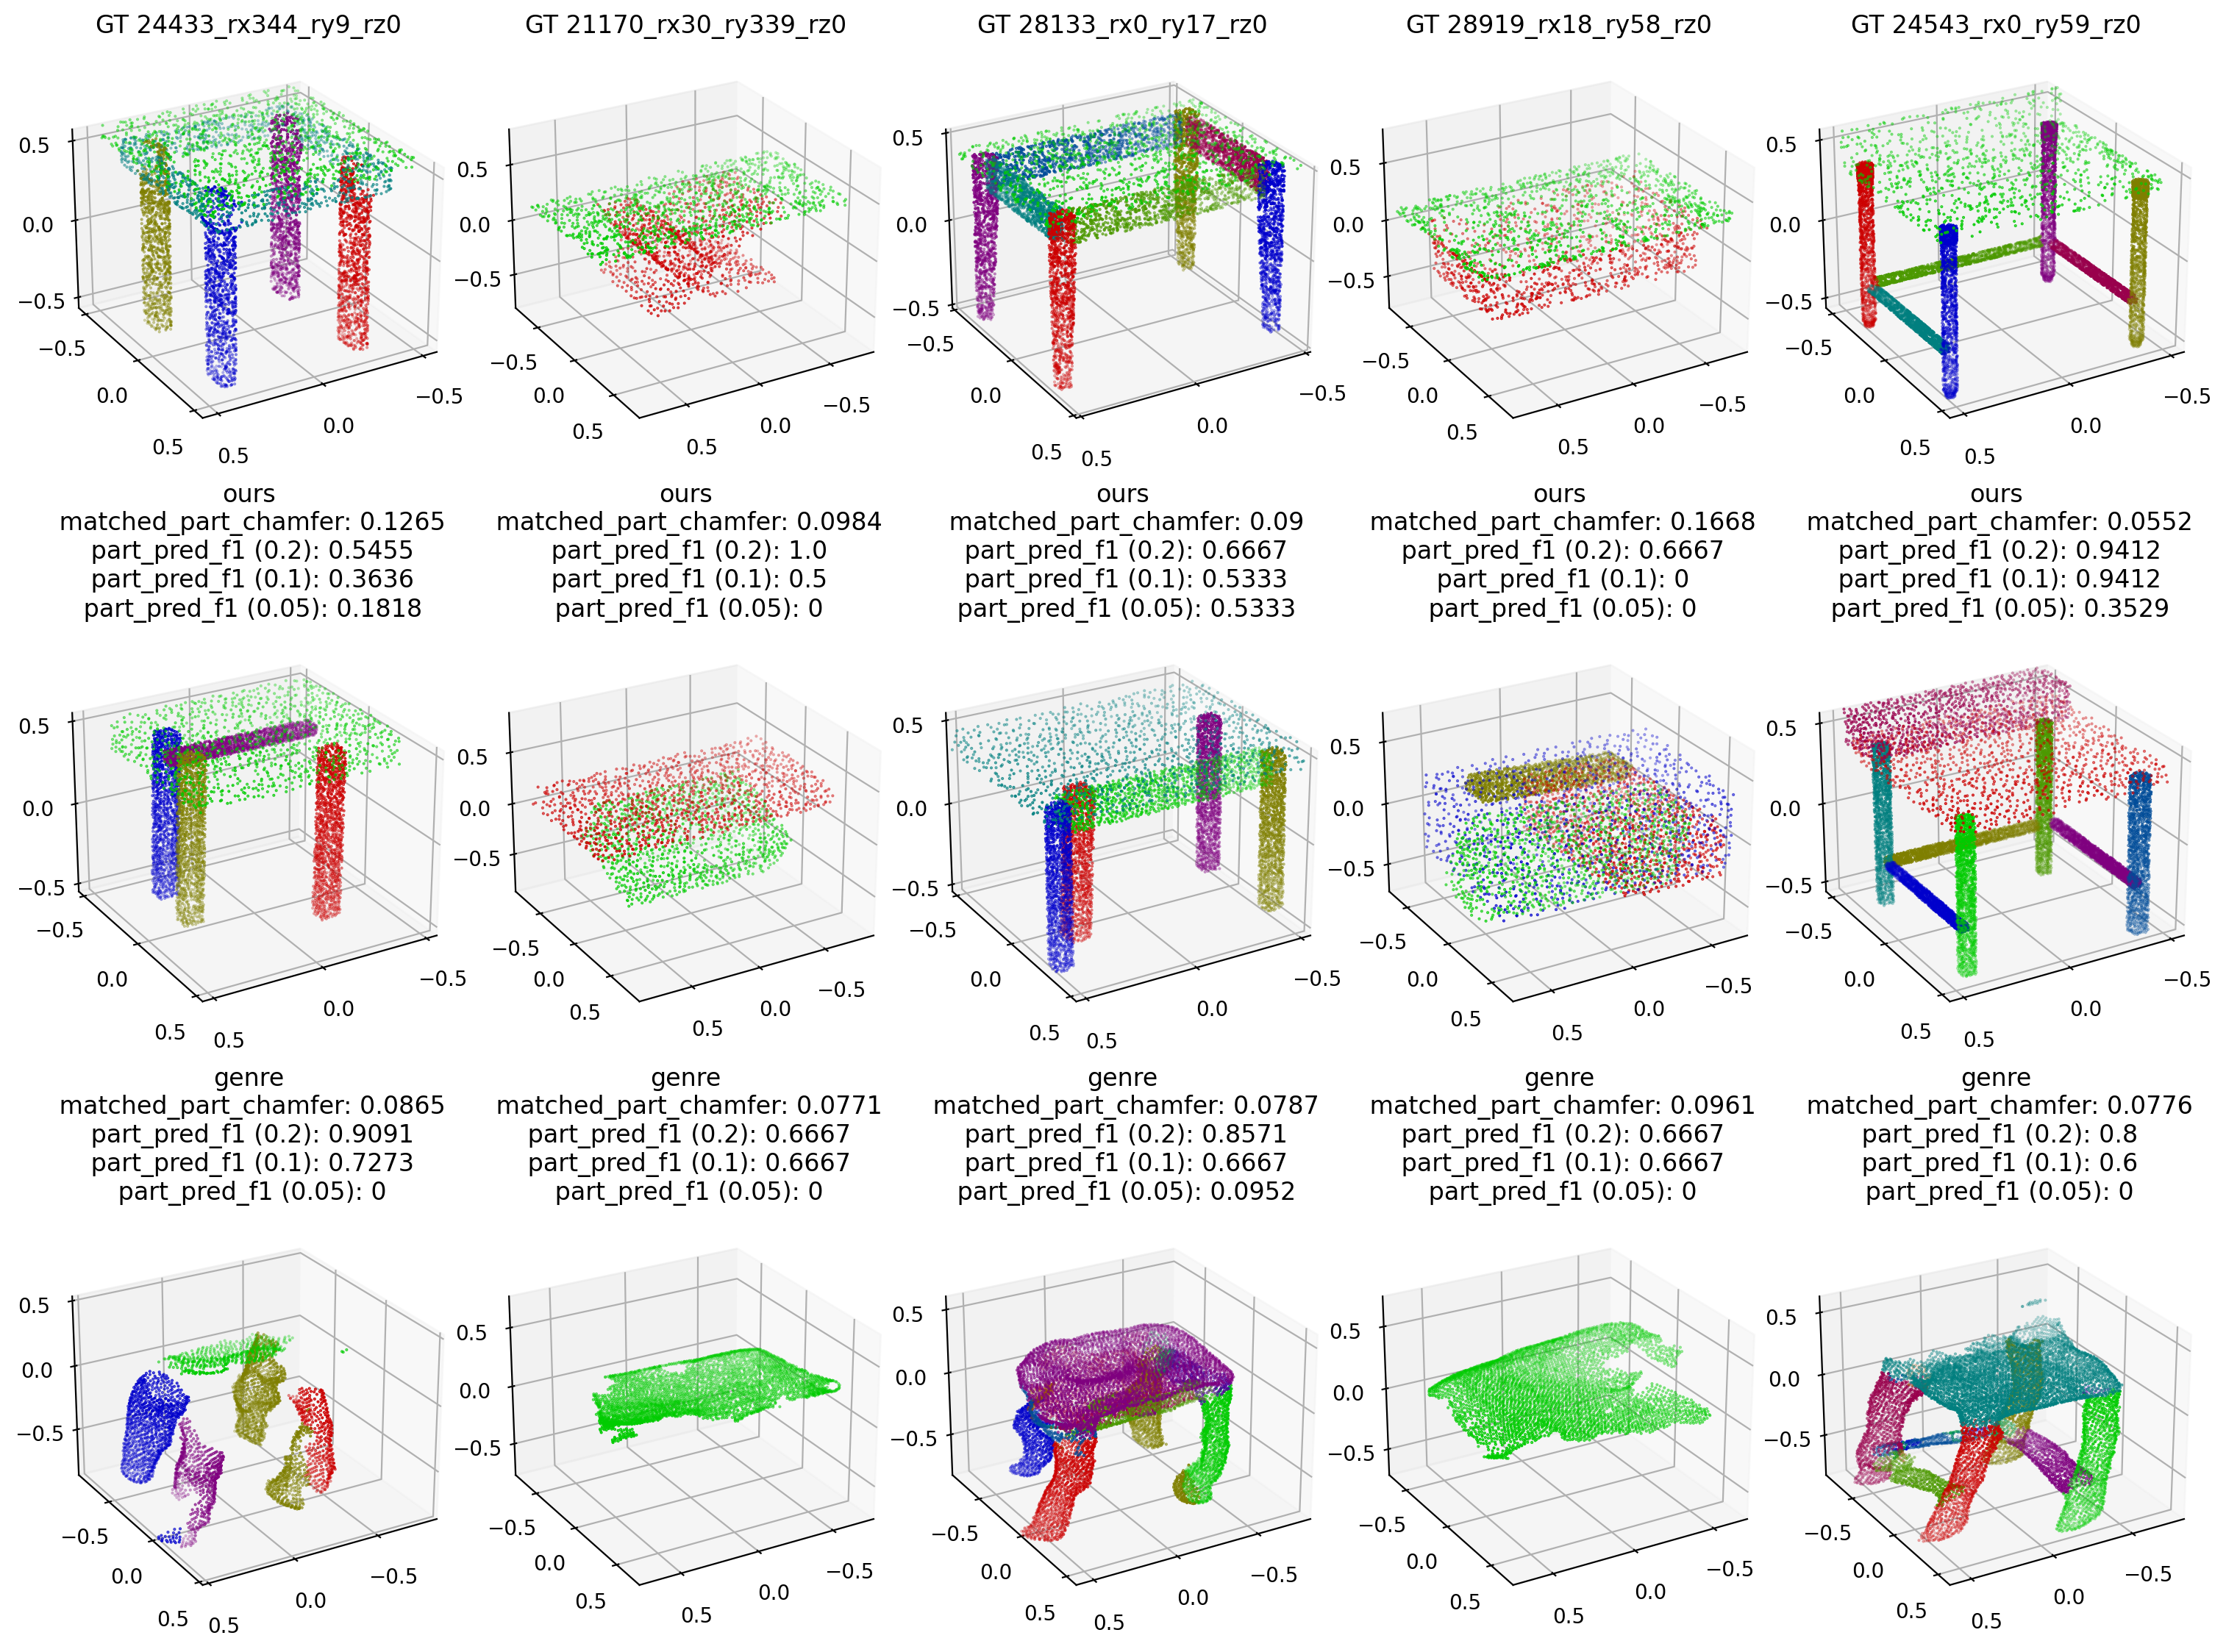

In [9]:
#1
### GT data path
# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center"
# # test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center"
gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

test_info_list = []
### our prediction path
# our_test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
our_test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask"
our_result_dirname = "center"
our_pred_type = "from_obb"
center = "center"
test_info_list.append((our_test_base_dir, our_result_dirname, our_pred_type, center, "ours"))

### genre prediction path
# genre_test_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou"
# genre_result_dirname = None
# genre_pred_type = "from_seg_list"
test_chair_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_table_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_storage_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
test_bed_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Bed-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
genre_test_base_dir = {"chair":test_chair_base_dir, "table":test_table_base_dir, "storagefurniture":test_storage_base_dir,
                       "bed": test_bed_base_dir}
# genre_test_base_dir = ""
genre_result_dirname = None
genre_pred_type = "from_seg_mask_h5"
center = False
test_info_list.append((genre_test_base_dir, genre_result_dirname, genre_pred_type, center, "genre"))


### hyper-param
gt_type = "surface"
# gt_type = "cuboids"
only_vis_parts = False # True
# center = False

metric_list = ["ave_part_matched_chamfer_dist", "matched_part_pred_f1_0.2", "matched_part_pred_f1_0.1", "matched_part_pred_f1_0.05"]
save_top_k = 10
min_part_volume = 1e-6
num_pts_sampled_from_obb = 1024
num_pts_sampled_from_gt = 1024 # more like a max number, since sample_surface_even will reject close pair

result_name = f"{category}_{gt_type}_{name}"
if only_vis_parts: 
    result_name += "_vis_only" 
    
    
# test_base_dir = Path(test_base_dir)
gt_base_dir = Path(gt_base_dir)
gt_surface_pts_base_dir = Path(gt_surface_pts_base_dir)
# test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")
gt_cls_dir = gt_base_dir / category

pred_pcs_list = []
pred_pcs_title_list = []
gt_pcs_list = []
gt_pcs_title_list = []
for i, (test_base_dir, result_dirname, pred_type, center, model_name) in enumerate(test_info_list):
    if pred_type == "from_seg_mask_h5":
        # if category == "chair": test_cls_dir = Path(test_chair_base_dir)
        # elif category == "table": test_cls_dir = Path(test_table_base_dir)
        # elif category == "storagefurniture": test_cls_dir = Path(test_storage_base_dir)
        # else: raise NotImplementedError(f"Unknown category: {category}")
        test_cls_dir = Path(genre_test_base_dir[category])
    else:
        test_base_dir = Path(test_base_dir)
        test_cls_dir = test_base_dir / category / (result_dirname if result_dirname else "")

    print(f"Run {result_name} for {category}, test number: {len(obj_list)} at '{test_cls_dir}'")
    
    for obj_id in tqdm(obj_list):
        rotmat = get_rotmat_from_filename(obj_id) # canonical to world

        ## Process gt part pts list
        gt_obj_file = gt_cls_dir / obj_id / f'{obj_id}.npy'
        gt_obj_info = np.load(gt_obj_file, allow_pickle=True).item()

        if gt_type == "surface":
            anno_id = obj_id.split("_rx")[0]            
            gt_part_obj_dir = gt_surface_pts_base_dir / anno_id / "objs" 
            gt_part_pts_list = get_part_pcds_from_gt_obj(gt_obj_info, gt_part_obj_dir, 
                                                         num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                         only_vis_parts=only_vis_parts, center=center)
        else: # from cuboids
            gt_part_pts_list = get_part_pcds_from_gt_obb(gt_obj_info, rotmat, 
                                                         num_pts_sampled_from_gt=num_pts_sampled_from_gt, 
                                                         only_vis_parts=only_vis_parts, center=center)
        if i == 0:
            gt_pcs_title_list.append(f"GT {obj_id}")
            gt_pcs_list.append(gt_part_pts_list)

        ## Retrieve pred pts
        if pred_type == "from_obb": # sample pts from obb
            pred_obb_file = test_cls_dir / obj_id / f'{obj_id}.npy' # from shapegraph
            pred_part_pts_list = get_part_pcds_from_pred_obb(pred_obb_file, rotmat, 
                                                             num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                             center=center)
        elif pred_type == "from_seg_list": # use predicted segmented pts
            pred_pts_file = f"{test_cls_dir}/{obj_id}.pred_seg_list.pkl"
            pred_part_pts_list = get_part_pcds_from_pred_seg_pts(pred_pts_file, rotmat=None,
                                                                 num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                 center=center)
        elif pred_type == "from_seg_mask_h5":
            pred_pts_file = f"{test_cls_dir}/{obj_id}.npy"
            pred_mask_file = f"{test_cls_dir}/{obj_id}.h5"
            pred_part_pts_list = get_part_pcds_from_pred_partnet_seg_pts(pred_pts_file, pred_mask_file, rotmat=None,
                                                                         num_pts_sampled_from_obb=num_pts_sampled_from_obb,
                                                                         center=center)
        else:
            raise NotImplementedError(f"Unknown pred_type: {pred_type}")


        ## compute metric
        title = f"{model_name}"
        for alg_name in metric_list:
            if alg_name == "ave_part_min_chamfer_dist":
                obj_metric = ave_part_min_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
                alg_name_to_print = "min_chamfer_dist"
            elif alg_name == "part_pred_f1_0.1":
                obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
                alg_name_to_print = "part_pred_f1 (0.1)"
            elif alg_name == "part_pred_f1_0.05":
                obj_metric = part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
                alg_name_to_print = "part_pred_f1 (0.05)"
            elif alg_name == "ave_part_matched_chamfer_dist":
                obj_metric = ave_part_matched_chamfer_dist(gt_part_pts_list, pred_part_pts_list, debug=False)
                alg_name_to_print = "matched_part_chamfer"
            elif alg_name == "matched_part_pred_f1_0.1":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.1, debug=False)
                alg_name_to_print = "part_pred_f1 (0.1)"
            elif alg_name == "matched_part_pred_f1_0.05":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.05, debug=False)
                alg_name_to_print = "part_pred_f1 (0.05)"
            elif alg_name == "matched_part_pred_f1_0.2":
                obj_metric = matched_part_pred_f1(gt_part_pts_list, pred_part_pts_list, threshold=0.2, debug=False)
                alg_name_to_print = "part_pred_f1 (0.2)"
            else:
                raise NotImplementedError(f"Unknown alg: {alg_name}")
            title += f"\n {alg_name_to_print}: {str(round(obj_metric, 4))}"
        
        pred_pcs_title_list.append(title)
        pred_pcs_list.append(pred_part_pts_list)

pcs_list = gt_pcs_list + pred_pcs_list
title_list = gt_pcs_title_list + pred_pcs_title_list
out_fn = str(test_cls_dir / f"{result_name}.jpg")

nrows = len(test_info_list)+1
ncols = k
figsize = (3*k, 1.5*nrows + 0.6*nrows*len(metric_list) )
render_part_pcs(pcs_list, title_list=title_list, figsize=figsize, subplotsize=(nrows, ncols), out_fn=out_fn, dpi=200, scale=0.9, elev=25)

### Sample pts from genre obj
sample pts from shape mesh obj files

In [38]:
## only use obj_id in a reference dir
use_reference = True
reference_base_dir = Path("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask")
reference_result_dirname = "center"

num_pts_sampled = 10000
obj_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models"
# output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
# output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"
output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Bed-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale"

# class_list=['chair', 'table', 'storagefurniture', 'bed']
category = "bed"
scale=True # genre max norm=0.5, our dataset is 1


obj_cls_dir = osp.join(obj_base_dir, f"genre_outputs_{category}")
output_pts_cls_dir = output_base_dir # osp.join(output_base_dir, category)
os.makedirs(output_pts_cls_dir, exist_ok=True);

reference_cls_dir = reference_base_dir / category / (reference_result_dirname if reference_result_dirname else "")
ref_obj_list = [x.stem for x in reference_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*")]
print(f"Copy {len(ref_obj_list)} objs for {category} to '{output_pts_cls_dir}'")

count = 0
for item in tqdm(os.listdir(obj_cls_dir)):
    if item.endswith(".obj"):
        if not use_reference or item[:-4] in ref_obj_list: # filter
            obj_path = osp.join(obj_cls_dir, item)
            # mesh = trimesh.load_mesh(obj_path)
            # pts = trimesh.sample.sample_surface(mesh, num_pts_sampled)[0] #.astype(np.float32)
            pts = convert_genre_to_canonical_space(obj_path, nb_pts=num_pts_sampled) # centered, from cam to world to cano frame
            if scale:
                pts /= np.linalg.norm(pts, axis=-1).max()
            pts = pts.reshape(1,num_pts_sampled,3) # need extra dim for partnet insseg model
            output_pts_path = osp.join(output_pts_cls_dir, item[:-4]+".npy")
            np.save(output_pts_path, pts)
            count += 1
print(category, count)

Copy 657 objs for bed to '/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Bed-3/test/genre10000/genre_10000_pts_canonical_space_w_ref_list_w_scale'


100%|██████████| 722/722 [05:05<00:00,  2.36it/s]

bed 657


In [35]:
np.asarray(o3d.io.read_triangle_mesh(str(obj_path)).sample_points_uniformly(1000).points).shape

(1000, 3)

In [25]:
mesh = trimesh.load_mesh(obj_path)
mesh

<trimesh.Trimesh(vertices.shape=(5255, 3), faces.shape=(10474, 3))>

In [24]:
convert_genre_to_canonical_space(obj_path, nb_pts=num_pts_sampled).shape

(5255, 3)

## Sample pcd and Calculated emd between pred and gt

In [34]:
def convert_pred_to_canonical_space(obb_file, shape_id=None, visible_pid_list=None, 
                                    sample_pts_num=1024, to_model_sapce=True, centering=True):
    """ Convert Compnet obb file in world space to PCD of size 1024 in canonical space"""
    obb_file = Path(obb_file)
    assert obb_file.exists(), f'Not found file {obb_file}'

    obb_dict = np.load(str(obb_file), allow_pickle=True).item()
    if visible_pid_list is None:
        obb_list = [item for key, item in obb_dict.items()]
    else:
        obb_list = [item for pid, item in obb_dict.items() if pid in visible_pid_list]
    obb_pts = sample_obb_list_verts(obb_list, nb_pts=sample_pts_num)
    if centering:
        obb_pts -= np.mean(obb_pts, axis=0)

    if to_model_sapce:
        if shape_id is None:
            shape_id = obb_file.parent.stem
        rotmat = get_rotmat_from_filename(shape_id) # canonical to world
        obb_pts = np.matmul(obb_pts, rotmat)        # obb_pts_canonical_space
    return obb_pts

emd_dist = emdModule()
def emd_np_warpper(pts1, pts2, verbose=False):
    if verbose:
        pcd1 = np2pcd(pts1)
        pcd2 = np2pcd(pts2)
        o3d.visualization.draw_geometries([pcd1, pcd2])
    batch_pts1 = torch.tensor(pts1).float().cuda().unsqueeze(0)
    batch_pts2 = torch.tensor(pts2).float().cuda().unsqueeze(0)
    dist12, assigment = emd_dist(batch_pts1, batch_pts2, 0.05, 3000)
    return float(torch.mean(dist12))

def eval_emd_from_obb_in_npy(pred_base_dir,
                             gt_base_dir,
                             out_stat_dir,
                            class_list=['chair', 'bed', 'table', 'storagefurniture'],
                            norm_scale=False,
                            result_file_suffix=''):
    """
    Convert both pred & gt obb in .npy files to caonical 1024 pts using FPS,
    and then calculate emd for each class.
    """
    pred_base_dir = Path(pred_base_dir)
    # out_pts_dir = Path(out_pts_dir)
    gt_base_dir = Path(gt_base_dir)
    cls_dict = {}

    for model_class in class_list:
        pred_class_dir = pred_base_dir / model_class / "center"
        gt_class_dir = gt_base_dir / model_class
        obj_list = [x.stem for x in pred_class_dir.iterdir() if x.is_dir()]
        print(f"Calculating average emd for {model_class}, num of obj: {len(obj_list)}")

        all_emd_dist, save_list = [], [] # record emd dist and all relevant info
        fail_dict = {}                   # record failing obj
        for i in tqdm(range(len(obj_list))):
            obj_id = obj_list[i]
            pred_obb_file = pred_class_dir / f'{obj_id}' / f'{obj_id}.npy'
            gt_obb_file = gt_class_dir /  f'{obj_id}'/ 'gt.npy'
            # gt_obb_file = gt_class_dir /  f'{obj_id}.txt'
            
            if not pred_obb_file.exists():
                fail_dict[obj_id] = f"Cannot find pred obb file: {pred_obb_file}"
                continue
            if not gt_obb_file.exists():
                fail_dict[obj_id] = f"Cannot find gt obb file: {gt_obb_file}"
                continue
                
            # in model space
            pred_pts = convert_pred_to_canonical_space(pred_obb_file, shape_id=obj_id);
            gt_pts = convert_pred_to_canonical_space(gt_obb_file, shape_id=obj_id);
            # gt_pts = np.loadtxt(str(gt_obb_file))
            
            if len(pred_pts) != 1024:
                fail_dict[obj_id] = "pred pcd point count does not match"
                continue
            if len(gt_pts) != 1024:
                fail_dict[obj_id] = "gt pcd point count does not match"
                continue
            if math.isnan(pred_pts[0, 0]):
                fail_dict[obj_id] = "pred pcd [0,0] is nan"
                continue
            
            gt_pts -= np.mean(gt_pts, axis=0)
            pred_pts -= np.mean(pred_pts, axis=0)
            if norm_scale:
                gt_bound = np.sqrt(np.max(np.sum(gt_pts ** 2, axis=1)))
                pred_bound = np.sqrt(np.max(np.sum(pred_pts ** 2, axis=1)))
                if pred_bound < 0.05:
                    fail_dict[obj_id] = "pred max norm less than 0.05"
                    continue
                scale = gt_bound / pred_bound
                pred_pts_v2 = pred_pts * scale
            else:
                pred_pts_v2 = pred_pts

            dist = emd_np_warpper(pred_pts_v2, gt_pts, verbose=False)
            if math.isnan(dist):
                fail_dict[obj_id] = "Calculated emd dist is nan"
                continue
            all_emd_dist.append(dist)
            save_list.append([obj_id, model_class, dist, "with-scale" if norm_scale else "wo-scale"])
            
        if len(all_emd_dist) == 0:
            print(f'Class {model_class}, empty list')
            print(f'out_fail_file:', fail_dict)
        else:
            cls_dict[model_class] = np.mean(all_emd_dist)
            print(colored(f'Class {model_class}, {np.mean(all_emd_dist)}', on_color="on_cyan"))
            
            # save all dist as a pd table
            if_scale = "with-scale" if norm_scale else "wo-scale"
            out_res_file = pred_base_dir / f'emd_{model_class}_{if_scale}{result_file_suffix}.pkl'
            df = pd.DataFrame(save_list, columns=['obj_id', 'model_class', 'dist', 'scale'])
            df.to_pickle(str(out_res_file))
            print(f'Save result to {out_res_file}')
            
            # save failure info
            out_fail_file = pred_base_dir / f'emd_{model_class}_{if_scale}_failure{result_file_suffix}.pkl'
            with open(out_fail_file, 'wb') as f:
                pickle.dump(fail_dict, f)
            print(f'Failed: {len(fail_dict)}, Save failure info to {out_fail_file}')
            print(f'fail_dict:', fail_dict)
    print(cls_dict)

def normalize_vert(vert):
    """ scale the vertex array to unit sphere (norm = 1) """
    assert len(vert.shape) == 2
    obb_length = np.linalg.norm(vert, axis=-1)
    max_obb_length = obb_length.max()
    vert = vert/max_obb_length
    return vert
    
def sample_pcd_from_pred_obb(pred_base_dir, out_pts_base_dir, 
                             class_list:list=['chair', 'bed', 'table', 'storagefurniture'],
                             result_dirname = "result",
                             sample_pts_num=1024, 
                             output_ext="txt",
                             scale_to_unit_sphere=False,
                             to_model_sapce=True,
                             centering=True):
    """
    Sample canonical pcd from predicted obb file by the center module.
    Save output PCD as .txt file in the `result_dirname` folder of {out_pts_base_dir}/category

    If result_dirname is None, the output is saved just in output_base_dir / category
    """
    pred_base_dir = Path(pred_base_dir)
    out_pts_base_dir = Path(out_pts_base_dir)
    for model_class in class_list:
        pred_class_dir = pred_base_dir / model_class / "center"
        out_pts_class_dir = out_pts_base_dir / model_class / result_dirname if result_dirname is not None \
                            else out_pts_base_dir / category
        out_pts_class_dir.mkdir(parents=True, exist_ok=True)
        print(f"Save predicted {model_class} PCD to '{out_pts_class_dir}'")
        
        obj_list = [x.stem for x in pred_class_dir.iterdir() 
                    if x.is_dir() and x.match("*_rx*_ry*_rz*")]
        for obj_id in tqdm(obj_list):
            pred_obb_file = pred_class_dir / f'{obj_id}' / f'{obj_id}.npy'
            obb_pts_canonical = convert_pred_to_canonical_space(pred_obb_file, shape_id=obj_id,
                                                                sample_pts_num=sample_pts_num,
                                                                to_model_sapce=to_model_sapce,
                                                                centering=centering);
            if scale_to_unit_sphere:            # normalize to unit sphere
                obb_pts_canonical = normalize_vert(obb_pts_canonical)
                
            if output_ext == "txt":
                out_pts_file = out_pts_class_dir / f'{obj_id}.txt'
                np.savetxt(str(out_pts_file), obb_pts_canonical)
            elif output_ext == "npy":
                out_pts_file = out_pts_class_dir / f'{obj_id}.npy'
                np.save(str(out_pts_file), obb_pts_canonical)
            else:
                raise ValueError(f"unknown output_ext: {output_ext}")
        
def sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir, 
                           class_list:list=['chair', 'bed', 'table', 'storagefurniture'],
                           sample_pts_num=1024, 
                           output_ext="txt",
                           scale_to_unit_sphere=False,
                           centering=True):
    """
    Sample canonical pcd from gt obb file. 
    Note that only visible cuboids are used.
    Save output PCD as output_ext file in `out_pts_base_dir`.
    """
    gt_base_dir = Path(gt_base_dir)
    out_pts_base_dir = Path(out_pts_base_dir)
    for model_class in class_list:
        gt_class_dir = gt_base_dir / model_class
        out_pts_class_dir = out_pts_base_dir / model_class
        out_pts_class_dir.mkdir(parents=True, exist_ok=True)
        print(f"Save visible GT {model_class} PCD to '{out_pts_class_dir}'")
        
        obj_list = [x.stem for x in gt_class_dir.iterdir() 
                    if x.is_dir() and x.match("*_rx*_ry*_rz*")]
        for obj_id in tqdm(obj_list):
            # only sample from visible cuboids
            gt_obb_file = gt_class_dir / obj_id / 'gt.npy'
            obj_file = gt_class_dir / obj_id / f'{obj_id}.npy'
            visible_pid_list = np.load(obj_file, allow_pickle=True).item()['vis_parts'] 
            obb_pts_canonical = convert_pred_to_canonical_space(gt_obb_file, shape_id=obj_id,
                                                               visible_pid_list=visible_pid_list,
                                                               sample_pts_num=sample_pts_num,
                                                               centering=centering);
            if scale_to_unit_sphere:            # normalize to unit sphere
                obb_pts_canonical = normalize_vert(obb_pts_canonical)
            # obb_pts_canonical -= np.mean(obb_pts_canonical, axis=0)
            
            if output_ext == "txt":
                out_pts_file = out_pts_class_dir / f'{obj_id}.txt'
                np.savetxt(str(out_pts_file), obb_pts_canonical)
            elif output_ext == "npy":
                out_pts_file = out_pts_class_dir / f'{obj_id}.npy'
                np.save(str(out_pts_file), obb_pts_canonical)
            else:
                raise ValueError(f"unknown output_ext: {output_ext}")

def sample_pcd_from_gt_surface_pcd(gt_base_dir, gt_surface_pts_base_dir, out_pts_base_dir, 
                                   class_list:list=['chair', 'bed', 'table', 'storagefurniture'],
                                   sample_pts_num=1024, 
                                   output_ext="txt",
                                   scale_to_unit_sphere=False,
                                   centering=True):
    """
    Sample canonical pcd from 10000 points from gt surface in `gt_surface_pts_base_dir`.
    Use gt_base_dir to get the obj_id list.
    Save output PCD as output_ext file in `out_pts_base_dir`.
    """
    gt_base_dir = Path(gt_base_dir)
    gt_surface_pts_base_dir = Path(gt_surface_pts_base_dir)
    out_pts_base_dir = Path(out_pts_base_dir)
    for model_class in class_list:
        gt_class_dir = gt_base_dir / model_class
        out_pts_class_dir = out_pts_base_dir / model_class
        out_pts_class_dir.mkdir(parents=True, exist_ok=True)
        print(f"Save surface GT {model_class} PCD to '{out_pts_class_dir}'")
        
        obj_list = [x.stem for x in gt_class_dir.iterdir() 
                    if x.is_dir() and x.match("*_rx*_ry*_rz*")]
        for obj_id in tqdm(obj_list):
            anno_id = obj_id.split("_")[0]
            gt_surface_pts_file = gt_surface_pts_base_dir / anno_id / "point_sample" / "ply-10000.ply"
            # FPS from 10000 presampled gt surface pts
            assert gt_surface_pts_file.exists(), f"Cannot find: {str(gt_surface_pts_file)}"
            pcd = o3d.io.read_point_cloud(str(gt_surface_pts_file))
            gt_surface_pts = np.asarray(pcd.points)
            gt_surface_pts = farthest_point_sample_wrapper(gt_surface_pts, sample_pts_num)
            if centering:
                gt_surface_pts -= np.mean(gt_surface_pts, axis=0)
            
            if scale_to_unit_sphere:            # normalize to unit sphere
                # obb_length = np.linalg.norm(gt_surface_pts, axis=-1)
                # max_obb_length = obb_length.max()
                # gt_surface_pts = gt_surface_pts/max_obb_length
                gt_surface_pts = normalize_vert(gt_surface_pts)
            
            if output_ext == "txt":
                out_pts_file = out_pts_class_dir / f'{obj_id}.txt'
                np.savetxt(str(out_pts_file), gt_surface_pts)
            elif output_ext == "npy":
                out_pts_file = out_pts_class_dir / f'{obj_id}.npy'
                np.save(str(out_pts_file), gt_surface_pts)
            else:
                raise ValueError(f"unknown output_ext: {output_ext}")

def eval_emd_from_pcd(pred_pts_base_dir,
                      gt_pts_base_dir,
                      out_stat_dir,
                      class_list=['chair', 'bed', 'table', 'storagefurniture'],
                      norm_scale=False,
                      result_dirname = "result",
                      result_file_suffix=''):
    """
    Directly calculate emd for each class based on sampled predicted and gt PCD beforehand. 
    The pred pcd should be in:
        "{pred_pts_base_dir} / category / result / {obj_id}.txt", or 
        ""
    the gt pcd should be in: 
        "{gt_pts_base_dir} / category / {obj_id}.txt"
    , where obj_id is from the folder name in pred_class_dir that matches "*_rx*_ry*_rz*"
    
    Args:
        pred_pts_base_dir: base pred folder
        gt_pts_base_dir: Compnet gt pts folder
        out_stat_dir: where to save result and other info
        class_list: list of category to be processed
        norm_scale: whether to normalize to norm 1,
        result_dirname: folder name in {pred_pts_base_dir} / category that stores the sampled pts.
                        If None, the input is taken directly from {pred_pts_base_dir} / category
        result_file_suffix:'':
    """
    pred_pts_base_dir = Path(pred_pts_base_dir)
    gt_pts_base_dir = Path(gt_pts_base_dir)
    if out_stat_dir:
        out_stat_dir = Path(out_stat_dir)
        out_stat_dir.mkdir(parents=True, exist_ok=True)
    
    cls_dict = {"result":{}, "failed":{}}
    if_scale = "with-scale" if norm_scale else "wo-scale"

    for category in class_list:
        pred_class_dir = pred_pts_base_dir / category / result_dirname if result_dirname is not None \
                         else pred_pts_base_dir / category
        gt_class_dir = gt_pts_base_dir / category
        
        # extract list of obj_id from dirname or filename
        obj_list = [x.stem for x in pred_class_dir.iterdir() if x.match("*_rx*_ry*_rz*")] 
        print(f"Calculating average emd for {category}, num of obj: {len(obj_list)}")

        all_emd_dist, save_list = [], [] # record emd dist and all relevant info
        fail_dict = {}                   # record failing obj
        for i in tqdm(range(len(obj_list))):
            obj_id = obj_list[i]

            # load pred pts in model space
            if (pred_class_dir / f'{obj_id}.npy').exists():
                pred_pts_file = pred_class_dir / f'{obj_id}.npy'
                pred_pts = np.load(str(pred_pts_file))
            elif (pred_class_dir / f'{obj_id}.txt').exists():
                pred_pts_file = pred_class_dir / f'{obj_id}.txt'
                pred_pts = np.loadtxt(str(pred_pts_file))
            else:
                fail_dict[obj_id] = f"Unknown input extension or cannot find pred obb file: {pred_pts_file}"
                continue
                
            ## load gt pts in model space
            gt_pts_file = gt_class_dir /  f'{obj_id}.txt'
            if not gt_pts_file.exists():
                fail_dict[obj_id] = f"Cannot find gt obb file: {gt_pts_file}"
                continue
            gt_pts = np.loadtxt(str(gt_pts_file))
            
            if len(pred_pts) != 1024:
                fail_dict[obj_id] = "pred pcd point count does not match"
                continue
            if len(gt_pts) != 1024:
                fail_dict[obj_id] = "gt pcd point count does not match"
                continue
            
            # centering and normalization
            gt_pts -= np.mean(gt_pts, axis=0)
            pred_pts -= np.mean(pred_pts, axis=0)
            if norm_scale:
                gt_bound = np.sqrt(np.max(np.sum(gt_pts ** 2, axis=1)))
                pred_bound = np.sqrt(np.max(np.sum(pred_pts ** 2, axis=1)))
                scale = gt_bound / pred_bound
                pred_pts_v2 = pred_pts * scale
            else:
                pred_pts_v2 = pred_pts

            dist = emd_np_warpper(pred_pts_v2, gt_pts, verbose=False)
            all_emd_dist.append(dist)
            save_list.append([obj_id, category, dist, if_scale])
            
        if len(all_emd_dist) == 0:
            print(f'Class {category}, empty list')
            print(f'out_fail_file:', fail_dict)
        else:
            cls_dict["result"][category] = np.mean(all_emd_dist)
            cls_dict["failed"][category] = fail_dict
            print(colored(f'Mean emd of {len(all_emd_dist)} samples in Class {category}: {np.mean(all_emd_dist)}', on_color="on_cyan"))
            
            # save all dist as a pd table
            if out_stat_dir:
                out_res_file = out_stat_dir / f'emd_{category}_{if_scale}{result_file_suffix}.pkl'
                df = pd.DataFrame(save_list, columns=['obj_id', 'category', 'dist', 'scale'])
                df.to_pickle(str(out_res_file))
                print(f'Save result to {out_res_file}')
            print(f'Failed: {len(fail_dict)}')
            print(f'fail_dict:', fail_dict)
    
    if out_stat_dir:
        out_stat_file = out_stat_dir / f'result_{"".join(class_list)}_{if_scale}{result_file_suffix}.pkl'
        with open(str(out_stat_file), 'wb') as f:
            pickle.dump(cls_dict, f)
    return cls_dict

In [35]:
## Routines related to eval Atlas
def rotateY(rad):
    return np.array([
        [np.cos(rad), 0, np.sin(rad)],
        [0, 1, 0],
        [-np.sin(rad), 0, np.cos(rad)]
    ])

def sample_pcd_from_Atlas_pred(atlas_model_log_dir, save_dir_name, sample_pts_num=1024, 
                               class_list:list=['chair', 'bed', 'table', 'storagefurniture'],
                               scale_to_unit_sphere = False,
                              ):
    """
    Sample canonical pcd from atlas pred ply file. The pcd is centered and rotated 
    by -90 degree around y-axis
    """
    ## save sampled atlas pcd in model space
    for category in class_list:
        output_test_img_dir = osp.join(atlas_model_log_dir, category, "test_img")
        save_dir = osp.join(atlas_model_log_dir, category, save_dir_name)
        assert os.path.isdir(output_test_img_dir)
        os.makedirs(save_dir, exist_ok=True)
        print(f"Sample {category} pcd from {output_test_img_dir}, save at {save_dir}")

        counter = 0
        for item in tqdm(os.listdir(output_test_img_dir)):
            if item.endswith(".ply"):
                obj_id = item.split("Atlas")[0]
                atlas_ply = osp.join(output_test_img_dir, item)
                mesh = o3d.io.read_point_cloud(atlas_ply)
                atlas_pred_pts = np.asarray(mesh.points)
                atlas_pred_pts = farthest_point_sample_wrapper(atlas_pred_pts, sample_pts_num)
                atlas_pred_pts = atlas_pred_pts - np.mean(atlas_pred_pts, axis=0)
                atlas_pred_pts = atlas_pred_pts @ rotateY(-np.pi / 2).T
                
                if scale_to_unit_sphere:            # normalize to unit sphere
                    atlas_pred_pts = normalize_vert(atlas_pred_pts)
                
                np.save(osp.join(save_dir, f"{obj_id}.npy"), atlas_pred_pts)
                counter += 1
        print(f"Sample {counter} {category} pcd at {save_dir}")
        


        # if len(pred_pts) < 2048:
        #     temp = np.repeat(pred_pts[[0]], 2048 - len(pred_pts), axis=0)
        #     pred_pts = np.concatenate((temp, pred_pts), axis=0)
        #     color_print("copy the first element to achieve 2048 points", "cyan")

In [36]:
# HIS calculation routines and hyperparameter
def modify_json_to_HIS_format(json_dict):
    """ modify json format to match HIS, and copy every text into 
    label for cal_tree_edit_distance"""
    if isinstance(json_dict, list) and len(json_dict) == 1:
        json_dict = json_dict[0]
    
    ## change text to label
    if "text" in json_dict:
        json_dict["label"] = json_dict["text"]
    if "children" in json_dict:
        for sub_dict in json_dict["children"]:
            sub_dict = modify_json_to_HIS_format(sub_dict)
    return json_dict

def is_leaf_node(node):
    return 'children' not in node

def traverse_for_10children(node):
    """ return true if this node or its children has more than 10 children"""
    if not is_leaf_node(node):
        if len(node['children']) > 10:
            return True
        for child in node['children']:
            if traverse_for_10children(child):
                return True
    return False

def traverse_for_label_other(node):
    """ return true if this node has a child labeled as other """
    if not is_leaf_node(node):
        for child in node['children']:
            if child["label"] == "other":
                return True
            if traverse_for_label_other(child):
                return True
    return False

def check_HIS_filter_condition(json_dict):
    if traverse_for_10children(json_dict) or traverse_for_label_other(json_dict):
        return False
    else:
        return True
    
def copy_symbolic_part_tree(gt_shape_base_dir, output_base_dir, 
                            result_dirname = "2048pts_for_HIS",
                            class_list:list=['chair', 'bed', 'table', 'storagefurniture'],
                            render_base_dir_for_vis=None):
    """
    Copy PartNet symbolic part tree json files that pass HIS filter condition to
        output_base_dir / category / result_dirname
    If result_dirname is None, the output is saved just in output_base_dir / category
    There must be "*_rx*_ry*_rz*.npy" files (or txt) in this dir to provide a list of obj
    
    If render_base_dir_for_vis is present, check the obj.npy file for each rendering to filter the
        json dict with only visible parts
    """
    gt_shape_base_dir = Path(gt_shape_base_dir)
    output_base_dir = Path(output_base_dir)
    
    for category in class_list:
        output_class_dir = output_base_dir / category / result_dirname if result_dirname is not None \
                      else output_base_dir / category
        obj_list = [x.stem for x in output_class_dir.iterdir() 
                    if x.match("*_rx*_ry*_rz*.txt") or x.match("*_rx*_ry*_rz*.npy")]
        print(f"Full anno_list length for {category}: {len(obj_list)}")

        count = 0
        for obj_id in obj_list:
            anno_id = obj_id.split("_rx")[0]
            gt_json_fn = str(gt_shape_base_dir / anno_id / "result_after_merging.json")
            json_dict = load_json(gt_json_fn)
            json_dict = modify_json_to_HIS_format(json_dict)
            if check_HIS_filter_condition(json_dict): # less than 10 children and no "other" label
                if render_base_dir_for_vis is not None:
                    obj_render_info_file = str(Path(render_base_dir_for_vis) / category / obj_id / f"{obj_id}.npy" )
                    obj_render_info_dict = np.load(obj_render_info_file, allow_pickle=True).item()
                    visible_part_list = obj_render_info_dict["vis_parts"]
                    truncate_tree_by_leaf(json_dict, visible_part_list)
                output_json_fn = str(output_class_dir / f"{obj_id}.gt.json")
                dump_json(output_json_fn, json_dict)
                count += 1
        print(f"Final filtered json list for {category}: {count}, save at {output_class_dir}")

def truncate_dict(json_dict, keys_to_save = ["id", "label"]):
    # keys_to_save = ["label"]
    ret = {}
    for key,value in json_dict.items():
        if key in keys_to_save:
            ret[key] = value
    
    if "children" in json_dict:
        ret["children"] = []
        for child_dict in json_dict["children"]:
            ret["children"].append(truncate_dict(child_dict, keys_to_save=keys_to_save))
    return ret

def truncate_tree_by_leaf(node, allowed_leaf_id_list):
    """
    modify a dict in-place to only leave internal node containing leaf node
    with allowed id; return whether this node should be in the final dict
    """
    if not "children" in node: # test leaf node
        return node["id"] in allowed_leaf_id_list 
    else:  # test internal node's children, whether contain any allowed leaf node
        new_children = []
        for child in node["children"]:
            if truncate_tree_by_leaf(child, allowed_leaf_id_list):
                new_children.append(child)
        node["children"] = new_children
        return len(new_children) > 0

scale_to_unit_sphere = True # https://github.com/daerduoCarey/pt2pc/tree/master/hierinsseg

# define experiement suffix
param_suffix = "_"
# if centering:
#     param_suffix += "C"
# if W2M:
#     param_suffix += "M"
if scale_to_unit_sphere:
    param_suffix += "N"
if len(param_suffix) == 1:
    param_suffix = ""
param_suffix

'_N'

### Genre: Eval emd and HIS

#### Eval emd
chair: 581, table: 1184, storagefurniture: 798

In [ ]:
## Define base and pts dir
genre_output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space"
# save_dir_name = "1024pts_for_compnet_emd"

## paths for sampling gt pts
# gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
# gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd"  # new GT cuboid pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd"  # new GT surface pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_cuboid_1024_pts/only_visible" # old GT cuboid pts
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_1024_pts" # old GT surface pts

# class_list=['bed', 'chair', 'table', 'storagefurniture']
# class_list = ["chair"]
class_list = ["table",  'storagefurniture']

### Sample GT pts
# sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)
# sample_pcd_from_gt_surface_pcd(gt_base_dir, gt_surface_pts_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)

## Calculate emd based on sampled pred and gt pcd
out_stat_dir = osp.join(genre_output_base_dir, "result_stat")
eval_emd_from_pcd(pred_pts_base_dir=genre_output_base_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
                  class_list=class_list, norm_scale=True, result_dirname=None)

In [6]:
## check total number of files
paths = os.listdir("/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space/chair")
paths = [x for x in paths if "_rx" in x]
print(len(paths))

gt_paths = os.listdir("/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_1024_pts/chair")
gt_paths = [x for x in gt_paths if "_rx" in x]
print(len(gt_paths))

581
581


#### Eval HIS
chair: 570/580/581, table: 969/1184/1225, storegaefurniture: 675/798/852

In [20]:
### copy 1024 pts into 2048psts

## only use obj_id in a reference dir
use_reference = True
reference_base_dir = Path("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask")
reference_result_dirname = "2048pts_for_HIS"

## 1024 pts dir
pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space"
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list"
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale"
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_for_iou"
output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou"
class_list = ["chair"]
# class_list = ["table",  'storagefurniture']
scale=True

for category in class_list:
    count = 0
    pts_cls_dir = osp.join(pts_base_dir, category)
    output_pts_cls_dir = osp.join(output_base_dir, category)
    os.makedirs(output_pts_cls_dir, exist_ok=True);
    
    reference_cls_dir = reference_base_dir / category / reference_result_dirname if reference_result_dirname is not None \
                        else reference_base_dir / category
    ref_obj_list = [x.stem for x in reference_cls_dir.iterdir() 
                    if x.match("*_rx*_ry*_rz*.txt") or x.match("*_rx*_ry*_rz*.npy")]
    
    for item in os.listdir(pts_cls_dir):
        if item.endswith(".txt"):
            if not use_reference or item[:-4] in ref_obj_list:
                pts_path = osp.join(pts_cls_dir, item)
                pts = np.loadtxt(pts_path)
                if len(pts) == 1024:
                    if scale:
                        pts = normalize_vert(pts)
                    pts_new = np.concatenate([pts,pts], axis=0) #2048
                    output_pts_path = osp.join(output_pts_cls_dir, item[:-4]+".npy")
                    np.save(output_pts_path, pts_new)
                    count += 1
                else:
                    print("length != 1024 :", item)
    print(category, count)

chair 574


In [21]:
### Copy HIS
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS"
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale"

# class_list = ["chair"]
# class_list = ["table",  'storagefurniture']

print("class_list", class_list)
print("output_base_dir", output_base_dir)

gt_shape_base_dir = "/sf-fast2/DATA/data_v0"
copy_symbolic_part_tree(gt_shape_base_dir, output_base_dir=output_base_dir, 
                        result_dirname=None,
                        class_list=class_list)

class_list ['chair']
output_base_dir /q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou
Full anno_list length for chair: 574
Final filtered json list for chair: 564, save at /q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou/chair


In [32]:
a= np.loadtxt("/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space/chair/691_rx72_ry60_rz0.txt")
np.linalg.norm(a, axis=-1).max()

0.4836430501111991

#### Copy pts for insseg
Modified code from eval HIS

In [38]:
### copy 1024 pts into 2048psts

## only use obj_id in a reference dir
use_reference = True
reference_base_dir = Path("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask")
reference_result_dirname = "center"

## 1024 pts dir
pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space"
# output_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS
# output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"
# output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Table-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"
output_base_dir = "/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale"

# class_list = ["chair"]
# class_list = ["table",  'storagefurniture']
category = "storagefurniture"
scale=True

count = 0
pts_cls_dir = osp.join(pts_base_dir, category)
output_pts_cls_dir = output_base_dir # osp.join(output_base_dir, category)
os.makedirs(output_pts_cls_dir, exist_ok=True);

reference_cls_dir = reference_base_dir / category / (reference_result_dirname if reference_result_dirname else "")
ref_obj_list = [x.stem for x in reference_cls_dir.iterdir() if x.match("*_rx*_ry*_rz*")]
print(f"Copy {len(ref_obj_list)} objs for {category} to '{output_base_dir}'")
for item in tqdm(os.listdir(pts_cls_dir)):
    if item.endswith(".txt"):
        if not use_reference or item[:-4] in ref_obj_list:
            pts_path = osp.join(pts_cls_dir, item)
            pts = np.loadtxt(pts_path)
            if len(pts) == 1024:
                if scale:
                    pts = normalize_vert(pts)
                # pts = np.concatenate([pts,pts], axis=0) #2048
                pts = pts.reshape(1,1024,3) # need extra dim for partnet insseg model
                output_pts_path = osp.join(output_pts_cls_dir, item[:-4]+".npy")
                np.save(output_pts_path, pts)
                count += 1
            else:
                print("length != 1024 :", item)
print(category, count)

Copy 670 objs for storagefurniture to '/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/StorageFurniture-3/test/genre/genre_1024_pts_canonical_space_w_ref_list_w_scale'


100%|██████████| 852/852 [00:14<00:00, 60.31it/s]

storagefurniture 670


In [6]:
temp_pts = np.load("/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space_HIS_w_ref_obj_list_w_scale_for_iou/chair/691_rx72_ry60_rz0.npy")
# temp_pts.shape
temp_pts.mean(axis=0), temp_pts.max(axis=0), temp_pts.min(axis=0), np.linalg.norm(temp_pts, axis=-1).max()

(array([-1.41649249e-10, -7.01929748e-09,  1.86231272e-09]),
 array([0.83021608, 0.8222229 , 0.8239962 ]),
 array([-0.73097424, -0.65638915, -0.81248292]),
 1.0)

In [7]:
temp_pts = np.loadtxt("/q5chen-cephfs/project_file/testComp/CompNet/outputs/other_models/genre_1024_pts_canonical_space/chair/691_rx72_ry60_rz0.txt")
temp_pts.shape, temp_pts.mean(axis=0), temp_pts.max(axis=0), temp_pts.min(axis=0), np.linalg.norm(temp_pts, axis=-1).max()

((1024, 3),
 array([-6.85076742e-11, -3.39483444e-09,  9.00694600e-10]),
 array([0.40152824, 0.39766239, 0.39852004]),
 array([-0.35353061, -0.31745805, -0.39295172]),
 0.4836430501111991)

In [9]:
fin = h5py.File("/q5chen-cephfs/project_file/partnet_seg_exps/exps/ins_seg_detection/outputs/Chair-3/test/genre/pred/48829_rx334_ry285_rz0.h5", "r")

In [10]:
print(list(fin.keys()))
fin["conf"], fin["label"], fin["mask"], fin["valid"]

['conf', 'label', 'mask', 'valid']


(<HDF5 dataset "conf": shape (1, 200), type "<f4">,
 <HDF5 dataset "label": shape (1, 200), type "|u1">,
 <HDF5 dataset "mask": shape (1, 200, 1024), type "|b1">,
 <HDF5 dataset "valid": shape (1, 200), type "|b1">)

In [11]:
fin["valid"][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,

In [15]:
fin["mask"][0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [16]:
fin["conf"][0]

array([4.04326129e-04, 4.65621008e-04, 3.17216793e-04, 4.10743785e-04,
       3.21819243e-04, 1.47334242e-04, 7.91851431e-04, 2.41784059e-04,
       2.83040456e-04, 4.18455660e-04, 5.87141083e-04, 1.46852733e-04,
       2.46921903e-04, 2.08754078e-04, 2.12740226e-04, 2.80948763e-04,
       2.48884899e-04, 1.53722242e-04, 3.01763823e-04, 2.10961691e-04,
       4.17243195e-04, 2.51258403e-04, 2.97594786e-04, 2.08367099e-04,
       1.45009850e-04, 1.72788408e-04, 1.76522663e-04, 3.89177680e-01,
       2.73663230e-04, 4.10354929e-04, 2.67068477e-04, 6.50983334e-01,
       1.82569519e-01, 3.50163755e-04, 3.47699126e-04, 3.78580327e-04,
       2.40699344e-04, 3.42174491e-04, 2.00818526e-04, 3.07246431e-04,
       2.27589742e-04, 5.60425746e-04, 5.46891999e-04, 2.76047096e-04,
       3.33060249e-04, 4.97855828e-04, 3.12131306e-04, 6.75586227e-04,
       4.10463894e-04, 3.03586683e-04, 4.08843276e-04, 5.17817796e-04,
       5.51682024e-04, 3.00599146e-04, 2.73437094e-04, 4.05581930e-04,
      

In [7]:
fin.close()

### Atlas: Sample pcd and eval

#### sampling and eval Compnet EMD

In [18]:
atlas_model_log_dir = "/q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs"
save_dir_name = "1024pts_for_compnet_emd"
class_list=['chair', 'bed', 'table', 'storagefurniture']
# class_list=['chair']
sample_pts_num = 1024
sample_pcd_from_Atlas_pred(atlas_model_log_dir, save_dir_name, sample_pts_num=sample_pts_num, class_list=class_list)

Sample chair pcd from /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair, save at /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/1024pts_for_compnet_emd


  2%|▏         | 19/1148 [00:00<00:06, 185.81it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40054_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41500_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43513_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40817_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

  7%|▋         | 76/1148 [00:00<00:04, 266.39it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42981_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/36015_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40219_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38947_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 11%|█         | 128/1148 [00:00<00:04, 210.42it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40107_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41073_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43235_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43030_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_ch

 14%|█▎        | 155/1148 [00:00<00:04, 226.53it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/39057_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41936_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/47886_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37697_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 18%|█▊        | 206/1148 [00:00<00:04, 218.72it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40000_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41878_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40375_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43792_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_cha

 23%|██▎       | 260/1148 [00:01<00:04, 220.46it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37192_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41202_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38233_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38614_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

 28%|██▊       | 322/1148 [00:01<00:03, 257.91it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40570_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44750_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37746_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43023_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 30%|███       | 349/1148 [00:01<00:03, 247.11it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41761_rx26_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42870_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43831_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38690_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 35%|███▍      | 399/1148 [00:01<00:03, 211.29it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37747_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37645_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44170_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40854_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 39%|███▉      | 448/1148 [00:02<00:03, 208.61it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3305_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37559_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40323_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/692_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_o

 42%|████▏     | 486/1148 [00:02<00:02, 242.09it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2774_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38809_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41461_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42890_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 47%|████▋     | 534/1148 [00:02<00:02, 216.26it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38557_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40997_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41515_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43667_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 53%|█████▎    | 604/1148 [00:02<00:01, 275.52it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3060_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3215_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44130_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3336_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 58%|█████▊    | 662/1148 [00:02<00:01, 250.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40579_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38528_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2802_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40397_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 60%|█████▉    | 688/1148 [00:02<00:01, 232.46it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40750_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38895_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42620_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37229_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 64%|██████▍   | 736/1148 [00:03<00:01, 224.06it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44506_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40899_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38448_rx26_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2886_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 68%|██████▊   | 783/1148 [00:03<00:01, 218.11it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40822_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40473_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40222_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38077_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 73%|███████▎  | 841/1148 [00:03<00:01, 247.12it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37252_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3100_rx300_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41534_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44096_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 79%|███████▉  | 906/1148 [00:03<00:00, 258.26it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38701_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38445_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40015_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41110_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

 81%|████████▏ | 933/1148 [00:03<00:00, 245.86it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43179_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44186_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37730_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38274_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 86%|████████▌ | 987/1148 [00:04<00:00, 240.62it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42808_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38354_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43135_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44111_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 91%|█████████ | 1045/1148 [00:04<00:00, 261.70it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43709_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38400_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37615_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3207_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 96%|█████████▌| 1102/1148 [00:04<00:00, 244.24it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40196_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37245_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43531_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40539_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

100%|██████████| 1148/1148 [00:04<00:00, 237.33it/s]


[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40717_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37454_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38762_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/36011_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

  0%|          | 0/1314 [00:00<?, ?it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11568_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12284_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10843_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12492_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

  2%|▏         | 21/1314 [00:00<00:06, 194.26it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11273_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12482_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11568_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12517_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

  4%|▍         | 50/1314 [00:00<00:05, 242.64it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11117_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11324_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12003_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12234_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_output

  6%|▌         | 80/1314 [00:00<00:04, 264.87it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13022_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12284_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12783_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 10%|▉         | 130/1314 [00:00<00:05, 208.88it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11196_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12394_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12442_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11548_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_o

 14%|█▎        | 180/1314 [00:00<00:04, 228.27it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11062_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10961_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12467_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12319_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_output

 16%|█▌        | 204/1314 [00:00<00:04, 228.97it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12776_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10843_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12143_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 18%|█▊        | 231/1314 [00:01<00:04, 231.15it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10843_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10165_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12319_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 22%|██▏       | 283/1314 [00:01<00:04, 244.51it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11108_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13097_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13197_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12442_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 24%|██▍       | 320/1314 [00:01<00:03, 277.20it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12003_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11273_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11324_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12785_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_output

 26%|██▋       | 348/1314 [00:01<00:03, 248.12it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11338_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/9981_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11297_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12672_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 29%|██▊       | 375/1314 [00:01<00:03, 253.99it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12748_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10873_rx60_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12747_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 31%|███       | 401/1314 [00:01<00:03, 242.11it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12482_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12143_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12524_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11181_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 32%|███▏      | 426/1314 [00:01<00:03, 229.62it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12681_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13097_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12681_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 38%|███▊      | 493/1314 [00:02<00:03, 270.34it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13197_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11572_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12802_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10873_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 40%|███▉      | 523/1314 [00:02<00:02, 274.50it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12330_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11287_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11338_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12783_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 42%|████▏     | 551/1314 [00:02<00:03, 246.36it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10165_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11117_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11108_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_ou

 44%|████▍     | 577/1314 [00:02<00:03, 242.40it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12776_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12234_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12499_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11108_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 46%|████▋     | 610/1314 [00:02<00:02, 263.65it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13022_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11117_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11548_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_o

 49%|████▊     | 638/1314 [00:02<00:02, 261.61it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12284_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12143_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/13022_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11338_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 51%|█████     | 665/1314 [00:02<00:02, 246.78it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12467_rx300_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12492_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12083_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 53%|█████▎    | 693/1314 [00:02<00:02, 253.96it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11181_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11568_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10989_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12467_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_ou

 55%|█████▍    | 719/1314 [00:02<00:02, 241.89it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12457_rx26_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11567_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11940_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11181_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 57%|█████▋    | 744/1314 [00:03<00:02, 215.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/9981_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11567_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12203_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10912_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs

 59%|█████▉    | 772/1314 [00:03<00:02, 227.49it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11572_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12802_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12467_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs

 61%|██████    | 800/1314 [00:03<00:02, 236.97it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11568_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10873_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12681_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 63%|██████▎   | 827/1314 [00:03<00:01, 243.99it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12776_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12275_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10165_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10961_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/

 65%|██████▍   | 852/1314 [00:03<00:01, 234.44it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10873_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10961_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12499_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12275_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs

 67%|██████▋   | 886/1314 [00:03<00:01, 262.04it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12672_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11572_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11297_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11567_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_ou

 70%|██████▉   | 916/1314 [00:03<00:01, 271.64it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12083_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11196_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11572_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12394_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 72%|███████▏  | 945/1314 [00:03<00:01, 276.01it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12003_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11568_rx300_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12673_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11108_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 74%|███████▍  | 973/1314 [00:03<00:01, 274.77it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12802_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12682_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10961_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10912_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 77%|███████▋  | 1010/1314 [00:04<00:01, 296.97it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10912_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12492_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11940_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12275_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_ou

 81%|████████▏ | 1069/1314 [00:04<00:00, 274.20it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10460_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12800_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12003_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11108_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 86%|████████▌ | 1124/1314 [00:04<00:00, 261.43it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11273_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11572_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12467_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10873_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_out

 90%|█████████ | 1185/1314 [00:04<00:00, 275.21it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11181_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12785_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12319_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11324_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outpu

 93%|█████████▎| 1220/1314 [00:04<00:00, 295.17it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12774_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11287_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12672_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12442_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outp

 96%|█████████▌| 1259/1314 [00:04<00:00, 319.92it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11548_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12802_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11940_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12083_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/b

 98%|█████████▊| 1292/1314 [00:05<00:00, 292.76it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12800_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12673_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12284_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11593_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_output

100%|██████████| 1314/1314 [00:05<00:00, 254.83it/s]


[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12275_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/12785_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/10165_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/bed/test_img/11547_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_output

  0%|          | 0/1278 [00:00<?, ?it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29710_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25286_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33195_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19815_rx0_ry343_rz0AtlasnetReconstruction.ply


  2%|▏         | 31/1278 [00:00<00:04, 293.70it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23855_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/31073_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30421_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19661_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

  5%|▍         | 61/1278 [00:00<00:04, 276.32it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22133_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/31061_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21217_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21126_rx330_ry21_rz0AtlasnetReconstruction.ply


  7%|▋         | 89/1278 [00:00<00:04, 270.46it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26249_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22707_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29431_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22248_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 10%|▉         | 125/1278 [00:00<00:03, 296.06it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21925_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28919_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19791_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24949_rx18_ry58_rz0AtlasnetReconstruction.ply


 12%|█▏        | 155/1278 [00:00<00:04, 273.41it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21219_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21342_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26349_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20340_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 15%|█▍        | 189/1278 [00:00<00:03, 289.24it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27803_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/18969_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25261_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21990_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 17%|█▋        | 219/1278 [00:00<00:04, 262.63it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22610_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25772_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27470_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22187_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 19%|█▉        | 246/1278 [00:00<00:04, 247.29it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22231_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24905_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/34362_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29344_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 21%|██▏       | 272/1278 [00:01<00:04, 243.39it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27351_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/31336_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30767_rx60_ry332_rz0AtlasnetReconstruction.ply


 24%|██▍       | 304/1278 [00:01<00:03, 260.64it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26194_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26323_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29285_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19162_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 26%|██▌       | 332/1278 [00:01<00:03, 261.10it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21393_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24860_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32745_rx0_ry17_rz0AtlasnetReconstruction.ply


 28%|██▊       | 359/1278 [00:01<00:03, 241.40it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25333_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29659_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28710_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32952_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_cha

 30%|███       | 384/1278 [00:01<00:04, 219.93it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30707_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28047_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/34018_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32819_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 32%|███▏      | 412/1278 [00:01<00:03, 234.25it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28668_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24754_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25622_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33138_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 34%|███▍      | 437/1278 [00:01<00:03, 233.61it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20256_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30979_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22420_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28927_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 36%|███▌      | 461/1278 [00:01<00:03, 221.78it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24489_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22789_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21573_rx18_ry302_rz0AtlasnetReconstruction.ply


 38%|███▊      | 484/1278 [00:01<00:03, 220.04it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25495_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21416_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22401_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22390_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 40%|████      | 514/1278 [00:02<00:03, 241.83it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32702_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24333_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22596_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28968_rx43_ry36_rz0AtlasnetReconstruction.ply


 42%|████▏     | 543/1278 [00:02<00:02, 253.44it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27737_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19576_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21825_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27441_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 45%|████▍     | 569/1278 [00:02<00:02, 252.03it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22995_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21300_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21891_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25853_rx54_ry58_rz0AtlasnetReconstruction.ply


 47%|████▋     | 599/1278 [00:02<00:02, 263.23it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23557_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25081_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24330_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21885_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 49%|████▉     | 626/1278 [00:02<00:02, 226.32it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24832_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21842_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25443_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/31173_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 51%|█████▏    | 655/1278 [00:02<00:02, 239.96it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29200_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21811_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28244_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19785_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 54%|█████▎    | 686/1278 [00:02<00:02, 257.08it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28037_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23304_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19971_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20744_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 56%|█████▌    | 713/1278 [00:02<00:02, 251.66it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24627_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26235_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26538_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32742_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 58%|█████▊    | 739/1278 [00:02<00:02, 235.30it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29490_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29346_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28104_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20195_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 60%|█████▉    | 764/1278 [00:03<00:02, 226.08it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29373_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21664_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19115_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28935_rx0_ry301_rz0AtlasnetReconstruction.ply


 62%|██████▏   | 787/1278 [00:03<00:02, 226.31it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19207_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/34081_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22242_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24372_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 65%|██████▍   | 827/1278 [00:03<00:01, 272.02it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24213_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24704_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33075_rx352_ry316_rz0AtlasnetReconstruction.ply


 67%|██████▋   | 858/1278 [00:03<00:01, 278.80it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/31593_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22091_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20395_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28779_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 70%|██████▉   | 891/1278 [00:03<00:01, 292.91it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20348_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27050_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22484_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25280_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 72%|███████▏  | 921/1278 [00:03<00:01, 232.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25043_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29061_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28234_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25091_rx344_ry351_rz0AtlasnetReconstruction.ply


 74%|███████▍  | 947/1278 [00:03<00:01, 227.80it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21170_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21351_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33071_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22896_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 76%|███████▌  | 972/1278 [00:03<00:01, 214.26it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28981_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/19465_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21074_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28155_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 78%|███████▊  | 995/1278 [00:04<00:01, 209.30it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26315_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30870_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22331_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25285_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 80%|███████▉  | 1017/1278 [00:04<00:01, 192.65it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25132_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21902_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25576_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27844_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 82%|████████▏ | 1043/1278 [00:04<00:01, 207.48it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/29185_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27924_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27523_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32891_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 84%|████████▎ | 1069/1278 [00:04<00:00, 216.38it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25201_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30178_rx60_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23654_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28566_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 86%|████████▌ | 1093/1278 [00:04<00:00, 221.24it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21346_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26252_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/26321_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/34113_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_cha

 87%|████████▋ | 1116/1278 [00:04<00:00, 201.95it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28632_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/20489_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28683_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28527_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 92%|█████████▏| 1172/1278 [00:04<00:00, 221.74it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/24944_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28238_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27322_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/30716_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 95%|█████████▍| 1211/1278 [00:04<00:00, 263.89it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28408_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33007_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21115_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28868_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 97%|█████████▋| 1239/1278 [00:05<00:00, 246.04it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27194_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25735_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23365_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/28067_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 99%|█████████▉| 1265/1278 [00:05<00:00, 236.29it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/22598_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/23437_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/32887_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25924_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

100%|██████████| 1278/1278 [00:05<00:00, 239.14it/s]


[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/33970_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/27894_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/25800_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/test_img/21770_rx43_ry282_rz0AtlasnetReconstruction.ply
Sample 639 table pcd at /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/table/1024pts_for_com

  0%|          | 0/1340 [00:00<?, ?it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45312_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48356_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48073_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48853_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

  2%|▏         | 24/1340 [00:00<00:05, 233.29it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46483_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48371_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46616_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45529_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

  4%|▎         | 48/1340 [00:00<00:05, 223.58it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49082_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45454_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46026_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47320_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

  6%|▌         | 74/1340 [00:00<00:05, 237.73it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45794_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45263_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46869_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47531_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

  8%|▊         | 103/1340 [00:00<00:04, 256.58it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46595_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46467_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48696_rx58_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48527_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

 10%|▉         | 129/1340 [00:00<00:05, 239.15it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47591_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49017_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45000_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49020_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 11%|█▏        | 154/1340 [00:00<00:05, 206.35it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47543_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47318_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47623_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49152_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 14%|█▎        | 183/1340 [00:00<00:05, 225.81it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48011_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48842_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46828_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47616_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 16%|█▌        | 208/1340 [00:00<00:04, 231.60it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49078_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48313_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45800_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47330_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

 17%|█▋        | 232/1340 [00:01<00:04, 233.36it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47227_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48416_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46090_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45181_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 20%|█▉        | 262/1340 [00:01<00:04, 247.35it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48266_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49132_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45984_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47258_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 22%|██▏       | 291/1340 [00:01<00:04, 256.55it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48908_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46984_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49092_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46732_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 24%|██▎       | 317/1340 [00:01<00:04, 218.01it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46765_rx300_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45943_rx9_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48452_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46423_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 29%|██▊       | 384/1340 [00:01<00:03, 266.95it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48501_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48409_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46359_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48902_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

 31%|███       | 412/1340 [00:01<00:03, 238.85it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48530_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48513_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46832_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48623_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 33%|███▎      | 442/1340 [00:01<00:03, 250.34it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45528_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45091_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49220_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45983_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlas

 35%|███▍      | 468/1340 [00:01<00:03, 235.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46582_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46129_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45635_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47867_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 39%|███▊      | 516/1340 [00:02<00:03, 219.62it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47632_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47515_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47467_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46169_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

 41%|████      | 546/1340 [00:02<00:03, 235.67it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47327_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49185_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46890_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45947_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 43%|████▎     | 570/1340 [00:02<00:03, 232.94it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46906_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/41085_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46743_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45963_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

 45%|████▍     | 597/1340 [00:02<00:03, 231.51it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48860_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47002_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49091_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47627_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

 46%|████▋     | 621/1340 [00:02<00:03, 231.00it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47302_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47652_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47547_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45443_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 48%|████▊     | 645/1340 [00:02<00:03, 226.91it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49191_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47559_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49230_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48997_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 50%|████▉     | 668/1340 [00:02<00:02, 226.19it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46992_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47928_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46332_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45838_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 52%|█████▏    | 703/1340 [00:02<00:02, 260.01it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46944_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48178_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46358_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47659_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

 55%|█████▍    | 732/1340 [00:03<00:02, 261.69it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47273_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45623_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47871_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47937_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 57%|█████▋    | 759/1340 [00:03<00:02, 221.21it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/41084_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45960_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46747_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47840_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

 61%|██████    | 813/1340 [00:03<00:02, 237.96it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47106_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48797_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/39701_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47428_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

 63%|██████▎   | 838/1340 [00:03<00:02, 238.13it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/39028_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47329_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48694_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48282_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

 64%|██████▍   | 863/1340 [00:03<00:02, 229.39it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45749_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49149_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47761_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47285_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 66%|██████▌   | 887/1340 [00:03<00:02, 213.68it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46043_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/44822_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45679_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45440_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/

 69%|██████▊   | 919/1340 [00:03<00:01, 239.80it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45789_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45920_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46655_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47667_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

 70%|███████   | 944/1340 [00:04<00:01, 229.51it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48771_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48744_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47338_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47517_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 75%|███████▌  | 1006/1340 [00:04<00:01, 256.24it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46134_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45308_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48135_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47946_rx60_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlas

 77%|███████▋  | 1033/1340 [00:04<00:01, 236.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47313_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48834_rx26_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/41086_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48317_rx16_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 79%|███████▉  | 1058/1340 [00:04<00:01, 219.05it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47993_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49028_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47482_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46849_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 81%|████████  | 1081/1340 [00:04<00:01, 201.20it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47756_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47413_rx43_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45175_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45821_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atla

 83%|████████▎ | 1110/1340 [00:04<00:01, 222.23it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49139_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46001_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47701_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46254_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 85%|████████▍ | 1138/1340 [00:04<00:00, 234.62it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49064_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49160_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47609_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46959_rx300_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 87%|████████▋ | 1163/1340 [00:04<00:00, 238.19it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48606_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46459_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48184_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48577_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 89%|████████▉ | 1192/1340 [00:05<00:00, 245.29it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49077_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47972_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45401_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46568_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 91%|█████████ | 1217/1340 [00:05<00:00, 243.87it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/49116_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46156_rx36_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47935_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46784_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atl

 93%|█████████▎| 1242/1340 [00:05<00:00, 221.72it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46395_rx0_ry343_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47028_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45105_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48214_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/at

 95%|█████████▍| 1267/1340 [00:05<00:00, 228.74it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45696_rx60_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45936_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48638_rx334_ry319_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48190_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

 96%|█████████▋| 1291/1340 [00:05<00:00, 197.91it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45410_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47563_rx60_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46161_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46833_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/a

 98%|█████████▊| 1312/1340 [00:05<00:00, 197.70it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47583_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46021_rx46_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46767_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45653_rx317_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log

100%|██████████| 1340/1340 [00:05<00:00, 230.17it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/48209_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/46188_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/45767_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/storagefurniture/test_img/47611_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlas

In [20]:
from glob import glob

for category in class_list:
    save_dir_img = osp.join(atlas_model_log_dir, "pcd_outputs", category, save_dir_name, "*.npy")
    print(
        len(glob(save_dir_img))
    )

574
657
639
670


evaluation

In [36]:
## Define base and pts dir
atlas_model_log_dir = "/q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs"
save_dir_name = "1024pts_for_compnet_emd"

# gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
# gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd"  # new GT cuboid pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd"  # new GT surface pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_cuboid_1024_pts/only_visible" # old GT cuboid pts
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_1024_pts" # old GT surface pts

class_list=['bed', 'chair', 'table', 'storagefurniture']
# class_list = ["chair"]
# class_list = ['bed', "table",  'storagefurniture']

### Sample GT pts
# sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)
# sample_pcd_from_gt_surface_pcd(gt_base_dir, gt_surface_pts_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)

## Calculate emd based on sampled pred and gt pcd
# out_stat_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/result_stat"
out_stat_dir = osp.join(atlas_model_log_dir, "result_stat")
eval_emd_from_pcd(pred_pts_base_dir=atlas_model_log_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
                  class_list=class_list, norm_scale=True, result_dirname=save_dir_name)

Calculating average emd for bed, num of obj: 657


100%|██████████| 657/657 [01:01<00:00, 10.73it/s]


Class bed, 0.05732148428145609
Save result to /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/result_stat/emd_bed_with-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for chair, num of obj: 574


100%|██████████| 574/574 [00:53<00:00, 10.78it/s]


Class chair, 0.016560673749785
Save result to /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/result_stat/emd_chair_with-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for table, num of obj: 639


100%|██████████| 639/639 [01:00<00:00, 10.55it/s]


Class table, 0.07055865710452548
Save result to /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/result_stat/emd_table_with-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for storagefurniture, num of obj: 670


100%|██████████| 670/670 [01:05<00:00, 10.21it/s]

Class storagefurniture, 0.13931693846443252
Save result to /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/result_stat/emd_storagefurniture_with-scale.pkl
Failed: 0
fail_dict: {}


{'result': {'bed': 0.05732148428145609,
  'chair': 0.016560673749785,
  'table': 0.07055865710452548,
  'storagefurniture': 0.13931693846443252},
 'failed': {'bed': {}, 'chair': {}, 'table': {}, 'storagefurniture': {}}}

#### sampling and eval HIS
1. Sample 2048 pcd from Atlas output ply
2. go through test dataset and copy only the json files passing HIS filter condition

In [86]:
atlas_model_log_dir = "/q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs"
save_dir_name = "2048pts_for_HIS_w_scale"
# class_list=['chair',  'table', 'storagefurniture']
class_list=['chair']
# class_list=['table', 'storagefurniture']

## step 1
sample_pts_num = 2048
sample_pcd_from_Atlas_pred(atlas_model_log_dir, save_dir_name, sample_pts_num=sample_pts_num, 
                           class_list=class_list, 
                           scale_to_unit_sphere=True)

## step 2
### Copy HIS
gt_shape_base_dir = "/sf-fast2/DATA/data_v0"
copy_symbolic_part_tree(gt_shape_base_dir, output_base_dir=atlas_model_log_dir, 
                        result_dirname=save_dir_name,
                        class_list=class_list)

Sample chair pcd from /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img, save at /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/2048pts_for_HIS_w_scale


  2%|▏         | 18/1148 [00:00<00:06, 164.74it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40054_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41500_rx14_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43513_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40817_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

  6%|▌         | 66/1148 [00:00<00:04, 221.66it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3036_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40083_rx0_ry59_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40192_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42695_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

  8%|▊         | 89/1148 [00:00<00:05, 201.34it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38531_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40023_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37256_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43252_rx73_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 11%|█         | 128/1148 [00:00<00:06, 168.57it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42641_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43140_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38062_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40444_rx72_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 13%|█▎        | 148/1148 [00:00<00:05, 177.20it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38270_rx0_ry328_rz0AtlasnetReconstruction.ply


 15%|█▍        | 167/1148 [00:00<00:05, 170.86it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44267_rx26_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44013_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37011_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41815_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 18%|█▊        | 211/1148 [00:01<00:05, 183.25it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43792_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44807_rx31_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3402_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40477_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 22%|██▏       | 251/1148 [00:01<00:04, 184.06it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2867_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37192_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41202_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38233_rx306_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 26%|██▌       | 301/1148 [00:01<00:03, 214.34it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44384_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38439_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40958_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42003_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 30%|███       | 348/1148 [00:01<00:03, 205.42it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37551_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2689_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43606_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41443_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 32%|███▏      | 370/1148 [00:01<00:03, 208.24it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44146_rx9_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43834_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37738_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42754_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 36%|███▌      | 413/1148 [00:02<00:03, 184.21it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2687_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38542_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40410_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44447_rx26_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 39%|███▉      | 453/1148 [00:02<00:03, 183.78it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40114_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43269_rx352_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43758_rx334_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38260_rx344_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_ch

 42%|████▏     | 482/1148 [00:02<00:03, 211.52it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41461_rx306_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42890_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40893_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43186_rx287_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 46%|████▌     | 524/1148 [00:02<00:03, 172.35it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3375_rx18_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38557_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40997_rx36_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41515_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 50%|████▉     | 573/1148 [00:03<00:02, 202.05it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43394_rx43_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41771_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41739_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37503_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 55%|█████▍    | 628/1148 [00:03<00:02, 226.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/48658_rx0_ry301_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44165_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44410_rx324_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43777_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 57%|█████▋    | 652/1148 [00:03<00:02, 205.56it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43271_rx54_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40384_rx0_ry32_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/36987_rx18_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37324_rx14_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 60%|██████    | 694/1148 [00:03<00:02, 180.40it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42620_rx342_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37229_rx344_ry9_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38494_rx330_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/39055_rx330_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair

 64%|██████▍   | 733/1148 [00:03<00:02, 170.12it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2703_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43789_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3236_rx317_ry36_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44506_rx314_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd

 65%|██████▌   | 751/1148 [00:04<00:02, 163.77it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3154_rx300_ry332_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37883_rx346_ry333_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3144_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41488_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 69%|██████▉   | 792/1148 [00:04<00:02, 176.38it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41989_rx72_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/3015_rx317_ry78_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/45149_rx0_ry328_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43419_rx0_ry17_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 72%|███████▏  | 831/1148 [00:04<00:01, 175.60it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2820_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/48829_rx334_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44210_rx30_ry21_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43472_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

 77%|███████▋  | 888/1148 [00:04<00:01, 222.57it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40837_rx46_ry12_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38701_rx352_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38445_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40015_rx324_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 81%|████████▏ | 933/1148 [00:04<00:01, 191.06it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/45028_rx26_ry41_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/44214_rx317_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43564_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42869_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/p

 83%|████████▎ | 953/1148 [00:05<00:01, 171.01it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37206_rx0_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43469_rx351_ry74_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37840_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41721_rx302_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_

 86%|████████▋ | 991/1148 [00:05<00:00, 168.60it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/2786_rx16_ry351_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/39851_rx43_ry324_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41583_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40590_rx43_ry282_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 91%|█████████ | 1039/1148 [00:05<00:00, 199.00it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40842_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43752_rx314_ry348_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40608_rx346_ry27_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43709_rx329_ry0_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/

 94%|█████████▍| 1080/1148 [00:05<00:00, 182.84it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37833_rx30_ry339_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/45017_rx342_ry302_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/41943_rx54_ry58_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40716_rx351_ry286_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

 96%|█████████▌| 1099/1148 [00:05<00:00, 183.88it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37188_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/43816_rx334_ry75_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37980_rx288_ry300_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/37114_rx60_ry28_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chai

100%|██████████| 1148/1148 [00:06<00:00, 187.20it/s]

[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/38762_rx288_ry60_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/36011_rx8_ry44_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/40498_rx8_ry316_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/test_img/42947_rx26_ry285_rz0AtlasnetReconstruction.ply
[Open3D WARNING] Read PLY failed: unable to read file: /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pc

Final filtered json list for chair: 564, save at /q5chen-cephfs/project_file/AtlasNet/log/atlasnet_singleview_25_squares_Compnet_chair/pcd_outputs/chair/2048pts_for_HIS_w_scale


##### scratch

In [10]:
json_path = "/q5chen-cephfs/project_file/CompNet/pt2pc/data/Lamp_hier/15652.json"
sample_json = load_json(json_path)
truncate_dict(sample_json, keys_to_save = ["id", "label"])

{'id': 0,
 'label': 'lamp',
 'children': [{'id': 1,
   'label': 'table_or_floor_lamp',
   'children': [{'id': 2,
     'label': 'lamp_base',
     'children': [{'id': 3,
       'label': 'lamp_holistic_base',
       'children': [{'id': 4, 'label': 'lamp_base_part'},
        {'id': -1, 'label': 'other'}]}]},
    {'id': 5,
     'label': 'lamp_body',
     'children': [{'id': 6, 'label': 'lamp_pole'},
      {'id': 7, 'label': 'lamp_pole'}]},
    {'id': 8,
     'label': 'lamp_unit',
     'children': [{'id': 9,
       'label': 'lamp_head',
       'children': [{'id': 10,
         'label': 'lamp_cover',
         'children': [{'id': 11, 'label': 'lamp_shade'}]},
        {'id': -1, 'label': 'other'}]},
      {'id': 12, 'label': 'connector'},
      {'id': 13, 'label': 'connector'}]}]}]}

In [30]:
json_path = "/sf-fast2/DATA/data_v0/2797/result_after_merging.json"
sample_json = load_json(json_path)
sample_json = modify_json_to_HIS_format(sample_json)
sample_json = truncate_dict(sample_json, keys_to_save = ["id", "label"])
sample_json

{'id': 0,
 'label': 'chair',
 'children': [{'id': 1,
   'label': 'chair_back',
   'children': [{'id': 2,
     'label': 'back_surface',
     'children': [{'id': 3, 'label': 'back_single_surface'}]},
    {'id': 4, 'label': 'back_support'}]},
  {'id': 5,
   'label': 'chair_arm',
   'children': [{'id': 6, 'label': 'arm_sofa_style'}]},
  {'id': 7,
   'label': 'chair_arm',
   'children': [{'id': 8, 'label': 'arm_sofa_style'}]},
  {'id': 9,
   'label': 'chair_seat',
   'children': [{'id': 10,
     'label': 'seat_surface',
     'children': [{'id': 11, 'label': 'seat_single_surface'}]},
    {'id': 12, 'label': 'seat_support'}]}]}

In [21]:
# ## check that name and text are the same
# def compare_name_and_text(node):
#     """ return true if the name is different from the text """
#     if node["name"] != node["text"]:
#         print("node['name'], node['text']", node["name"], node["text"])
#     if not is_leaf_node(node):
#         for child in node['children']:
#             compare_name_and_text(child)
            
# base_dir = "/sf-fast2/DATA/data_v0"
# for item in tqdm(os.listdir(base_dir)):
#     anno_dir = osp.join(base_dir, item)
#     if os.path.isdir(anno_dir):
#         json_fn = osp.join(anno_dir, "result_after_merging.json")
#         sample_json = load_json(json_fn)[0]
#         compare_name_and_text(sample_json)

100%|██████████| 32537/32537 [01:31<00:00, 355.22it/s]  


### Compnet: Eval with predicted mask

#### Sampling and eval Compnet EMD

In [7]:
## Define base and pts dir
pred_base_dir = '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask'
pred_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"

#gt dir for sampling surface pts and cuboid pts
gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd"  # new GT cuboid pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd"  # new GT surface pts
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_cuboid_1024_pts/only_visible" # old GT cuboid pts
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/GT_sampled_pcd/partnet_1024_pts" # old GT surface pts

# class_list=['bed', 'chair', 'table', 'storagefurniture']
# class_list = ["chair"]
class_list = ['bed', "table",  'storagefurniture']

### Sample pts
# sample_pcd_from_pred_obb(pred_base_dir, out_pts_base_dir=pred_out_pts_base_dir, class_list=class_list)

### Sample GT pts
# sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)
# sample_pcd_from_gt_surface_pcd(gt_base_dir, gt_surface_pts_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)

## Calculate emd based on sampled pred and gt pcd
# out_stat_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/result_stat"
out_stat_dir = osp.join(pred_base_dir, "result_stat")
result_dirname = "result"
eval_emd_from_pcd(pred_pts_base_dir=pred_out_pts_base_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
                  class_list=class_list, norm_scale=False, result_dirname=result_dirname)

### #comp gt cuboids with gt surface pcd
# pred_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd"
# out_stat_dir = None
# result_dirname = None
# eval_emd_from_pcd(pred_pts_base_dir=pred_out_pts_base_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
#                   class_list=class_list, norm_scale=False, result_dirname=result_dirname)

Calculating average emd for bed, num of obj: 657


100%|██████████| 657/657 [01:31<00:00,  7.21it/s]


Mean emd of 657 samples in Class bed: 0.03653916649029929
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_bed_wo-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for table, num of obj: 639


100%|██████████| 639/639 [01:30<00:00,  7.08it/s]


Mean emd of 639 samples in Class table: 0.05511111266042378
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_table_wo-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for storagefurniture, num of obj: 670


100%|██████████| 670/670 [01:32<00:00,  7.22it/s]

Mean emd of 670 samples in Class storagefurniture: 0.04970361165035127
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_storagefurniture_wo-scale.pkl
Failed: 0
fail_dict: {}


{'result': {'bed': 0.03653916649029929,
  'table': 0.05511111266042378,
  'storagefurniture': 0.04970361165035127},
 'failed': {'bed': {}, 'table': {}, 'storagefurniture': {}}}

#### Sampling and eval HIS

In [12]:
## Define base and pts dir
pred_base_dir = '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask'
# pred_base_dir = '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask'
pred_out_pts_base_dir = pred_base_dir
# result_dirname = "2048pts_for_HIS"
# result_dirname = "2048pts_for_HIS_w_scale"
# result_dirname = "2048pts_for_HIS_world_space"
# result_dirname = "2048pts_for_HIS_world_space_w_scale"
# result_dirname = "2048pts_for_vis_HIS_id"
result_dirname = "2048pts_for_vis_HIS_wo_centering"
scale_to_unit_sphere = False
to_model_sapce = True
centering = False

# class_list=['chair', 'table', 'storagefurniture']
# class_list = ["chair"]
class_list = ["table",  'storagefurniture']

### Sample pts
sample_pcd_from_pred_obb(pred_base_dir, pred_out_pts_base_dir, 
                         class_list=class_list,
                         result_dirname = result_dirname,
                         sample_pts_num=2048, 
                         output_ext="npy",
                         scale_to_unit_sphere=scale_to_unit_sphere,
                         to_model_sapce=to_model_sapce,
                         centering=centering)

### Copy HIS
gt_shape_base_dir = "/sf-fast2/DATA/data_v0"
render_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test" # for visible list
copy_symbolic_part_tree(gt_shape_base_dir, output_base_dir=pred_base_dir, 
                        result_dirname=result_dirname,
                        class_list=class_list,
                        render_base_dir_for_vis=render_base_dir)

Save predicted table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/2048pts_for_vis_HIS_wo_centering'


100%|██████████| 639/639 [02:18<00:00,  4.62it/s]


Save predicted storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/2048pts_for_vis_HIS_wo_centering'


100%|██████████| 670/670 [03:27<00:00,  3.23it/s]


Full anno_list length for table: 639
Final filtered json list for table: 519, save at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/table/2048pts_for_vis_HIS_wo_centering
Full anno_list length for storagefurniture: 670
Final filtered json list for storagefurniture: 565, save at /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/2048pts_for_vis_HIS_wo_centering


In [64]:
len(glob("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask/storagefurniture/2048pts_for_HIS/*.npy"))

670

##### copy GT json and GT vis json to calc vis json HIS

In [ ]:
model_base_dir = Path("/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_predicted_mask")
modified_gt_json_base_dir = "2048pts_for_HIS"
vis_gt_json_base_dir = "2048pts_for_vis_HIS"
output_base_dir = Path("/q5chen-cephfs/project_file/CompNet/pt2pc/hierinsseg/test_data/vis_parts_vs_gt_HIS")

# class_list = ["chair"]
class_list = ["table",  'storagefurniture']

for category in class_list:
    modified_gt_json_cls_dir = model_base_dir / category / modified_gt_json_base_dir
    vis_gt_json_cls_dir = model_base_dir / category / vis_gt_json_base_dir
    output_cls_dir = output_base_dir / category
    output_cls_dir.mkdir(parents=True, exist_ok=True)
    
    vis_json_fn_list = [path for path in vis_gt_json_cls_dir.iterdir() if path.match("*_rx*_ry*_rz*.gt.json")]
    print(f"copy {len(vis_json_fn_list)} json to {output_base_dir}")
    for vis_json_fn in tqdm(vis_json_fn_list):
        json_fn = vis_json_fn.name
        if (modified_gt_json_cls_dir/json_fn).exists():
            gt_json_fn = modified_gt_json_cls_dir/json_fn
            obj_id = json_fn.split(".gt")[0]
            vis_json_output_fn = output_cls_dir / f"{obj_id}.pred.json"
            gt_json_output_fn = output_cls_dir / f"{obj_id}.gt.json"
            
            shutil.copy2(vis_json_fn, vis_json_output_fn)
            shutil.copy2(gt_json_fn, gt_json_output_fn)

#### Sampling and eval HIS for Compnet gt

In [27]:
## Define base and pts dir
gt_surface_pts_base_dir = "/sf-fast2/DATA/data_v0"
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"

# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale"  # new GT cuboid pts for HIS
# gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd_HIS/wo_scale_wo_center"
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center"  # new GT surface pts for HIS

# class_list=['chair', 'table', 'storagefurniture']
# class_list = ["chair"]
class_list = ["table",  'storagefurniture']
scale_to_unit_sphere = False
centering = False

# ### Sample GT pts from gt obb
# sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir,
#                        class_list=class_list,
#                        sample_pts_num=2048, 
#                        output_ext="npy",
#                        scale_to_unit_sphere=scale_to_unit_sphere,
#                        centering=centering)

### Sample GT pts from gt surface pts
sample_pcd_from_gt_surface_pcd(gt_base_dir, gt_surface_pts_base_dir, out_pts_base_dir=gt_out_pts_base_dir, 
                                   class_list=class_list,
                                   sample_pts_num=2048, 
                                   output_ext="npy",
                                   scale_to_unit_sphere=scale_to_unit_sphere,
                                   centering=centering)

### Copy HIS
gt_shape_base_dir = "/sf-fast2/DATA/data_v0"
copy_symbolic_part_tree(gt_shape_base_dir, output_base_dir=gt_out_pts_base_dir, 
                        result_dirname=None,
                        class_list=class_list)

Save surface GT table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center/table'


100%|██████████| 639/639 [00:27<00:00, 22.99it/s]


Save surface GT storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center/storagefurniture'


100%|██████████| 670/670 [00:28<00:00, 23.31it/s]


Full anno_list length for table: 639
Final filtered json list for table: 519, save at /q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center/table
Full anno_list length for storagefurniture: 670
Final filtered json list for storagefurniture: 565, save at /q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/wo_scale_wo_center/storagefurniture


In [79]:
sample_pts = np.load("/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_surface_pcd_HIS/w_scale/chair/691_rx72_ry60_rz0.npy")
np.linalg.norm(sample_pts, axis=-1).max()

1.0

### Compnet: Eval with gt mask

In [73]:
## Define base and pts dir
pred_base_dir = '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask'
pred_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"

gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_vis_cuboid_pcd"

class_list=['bed', 'chair', 'table', 'storagefurniture']
# class_list = ["chair"]

### Sample pts
sample_pcd_from_pred_obb(pred_base_dir, out_pts_base_dir=pred_out_pts_base_dir, class_list=class_list)
sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)

### Calculate emd based on sampled pred and gt pcd
out_stat_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat"
eval_emd_from_pcd(pred_pts_base_dir=pred_out_pts_base_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
                  class_list=class_list, norm_scale=False)

Save predicted bed PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/result'


100%|██████████| 657/657 [00:59<00:00, 11.10it/s]


Save predicted chair PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/chair/result'


100%|██████████| 574/574 [01:13<00:00,  7.86it/s]


Save predicted table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/table/result'


  1%|          | 6/639 [00:00<00:26, 24.08it/s]WARNING - 2022-02-15 04:04:01,518 - sample - only got 870/1024 samples!
WARNING - 2022-02-15 04:04:01,534 - sample - only got 888/1024 samples!
 16%|█▌        | 101/639 [00:05<00:35, 15.13it/s]WARNING - 2022-02-15 04:04:06,381 - sample - only got 1005/1024 samples!
WARNING - 2022-02-15 04:04:06,396 - sample - only got 726/1024 samples!
 41%|████      | 261/639 [00:15<00:24, 15.33it/s]WARNING - 2022-02-15 04:04:16,442 - sample - only got 624/1024 samples!
WARNING - 2022-02-15 04:04:16,447 - sample - only got 818/1024 samples!
WARNING - 2022-02-15 04:04:16,452 - sample - only got 874/1024 samples!
 51%|█████     | 326/639 [00:19<00:27, 11.31it/s]WARNING - 2022-02-15 04:04:20,945 - sample - only got 719/1024 samples!
WARNING - 2022-02-15 04:04:21,004 - sample - only got 932/1024 samples!
100%|██████████| 639/639 [00:37<00:00, 17.16it/s]


Save predicted storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/storagefurniture/result'


 24%|██▍       | 161/670 [00:16<00:51,  9.98it/s]WARNING - 2022-02-15 04:04:54,860 - sample - only got 765/1024 samples!
WARNING - 2022-02-15 04:04:54,877 - sample - only got 849/1024 samples!
100%|██████████| 670/670 [01:08<00:00,  9.82it/s]


Save visible GT bed PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/bed'


  0%|          | 1/657 [00:00<03:35,  3.04it/s]WARNING - 2022-02-15 04:05:47,138 - sample - only got 711/1024 samples!
WARNING - 2022-02-15 04:05:47,166 - sample - only got 716/1024 samples!
  1%|          | 8/657 [00:00<01:03, 10.27it/s]WARNING - 2022-02-15 04:05:47,539 - sample - only got 722/1024 samples!
WARNING - 2022-02-15 04:05:47,552 - sample - only got 740/1024 samples!
WARNING - 2022-02-15 04:05:47,611 - sample - only got 714/1024 samples!
WARNING - 2022-02-15 04:05:47,635 - sample - only got 727/1024 samples!
  2%|▏         | 11/657 [00:01<01:12,  8.92it/s]WARNING - 2022-02-15 04:05:48,071 - sample - only got 742/1024 samples!
WARNING - 2022-02-15 04:05:48,088 - sample - only got 753/1024 samples!
  5%|▌         | 35/657 [00:02<00:30, 20.60it/s]WARNING - 2022-02-15 04:05:49,302 - sample - only got 696/1024 samples!
WARNING - 2022-02-15 04:05:49,321 - sample - only got 706/1024 samples!
  6%|▌         | 41/657 [00:02<00:30, 20.44it/s]WARNING - 2022-02-15 04:05:49,633 - sample

Save visible GT chair PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/chair'


 20%|█▉        | 114/574 [00:16<00:46,  9.81it/s]WARNING - 2022-02-15 04:07:04,775 - sample - only got 628/1024 samples!
WARNING - 2022-02-15 04:07:04,781 - sample - only got 610/1024 samples!
 22%|██▏       | 125/574 [00:17<00:37, 12.11it/s]WARNING - 2022-02-15 04:07:05,669 - sample - only got 813/1024 samples!
WARNING - 2022-02-15 04:07:05,685 - sample - only got 965/1024 samples!
 60%|██████    | 347/574 [00:46<00:21, 10.64it/s]WARNING - 2022-02-15 04:07:34,719 - sample - only got 747/1024 samples!
WARNING - 2022-02-15 04:07:34,725 - sample - only got 629/1024 samples!
 92%|█████████▏| 529/574 [01:09<00:04, 10.96it/s]WARNING - 2022-02-15 04:07:58,307 - sample - only got 609/1024 samples!
WARNING - 2022-02-15 04:07:58,352 - sample - only got 634/1024 samples!
100%|██████████| 574/574 [01:16<00:00,  7.49it/s]


Save visible GT table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/table'


  0%|          | 0/639 [00:00<?, ?it/s]WARNING - 2022-02-15 04:08:05,029 - sample - only got 747/1024 samples!
WARNING - 2022-02-15 04:08:05,057 - sample - only got 752/1024 samples!
  1%|▏         | 9/639 [00:00<00:28, 22.48it/s]WARNING - 2022-02-15 04:08:05,435 - sample - only got 745/1024 samples!
WARNING - 2022-02-15 04:08:05,458 - sample - only got 667/1024 samples!
  3%|▎         | 22/639 [00:00<00:25, 24.45it/s]WARNING - 2022-02-15 04:08:05,905 - sample - only got 732/1024 samples!
WARNING - 2022-02-15 04:08:05,991 - sample - only got 942/1024 samples!
  5%|▍         | 29/639 [00:01<00:52, 11.68it/s]WARNING - 2022-02-15 04:08:06,713 - sample - only got 959/1024 samples!
WARNING - 2022-02-15 04:08:06,734 - sample - only got 819/1024 samples!
WARNING - 2022-02-15 04:08:06,740 - sample - only got 624/1024 samples!
  5%|▌         | 32/639 [00:01<00:44, 13.54it/s]WARNING - 2022-02-15 04:08:06,829 - sample - only got 683/1024 samples!
WARNING - 2022-02-15 04:08:06,835 - sample - only 

Save visible GT storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/storagefurniture'


  0%|          | 0/670 [00:00<?, ?it/s]WARNING - 2022-02-15 04:08:43,903 - sample - only got 935/1024 samples!
WARNING - 2022-02-15 04:08:43,908 - sample - only got 776/1024 samples!
WARNING - 2022-02-15 04:08:43,991 - sample - only got 766/1024 samples!
  1%|          | 6/670 [00:00<01:11,  9.34it/s]WARNING - 2022-02-15 04:08:44,835 - sample - only got 956/1024 samples!
WARNING - 2022-02-15 04:08:44,845 - sample - only got 835/1024 samples!
  1%|          | 8/670 [00:00<01:31,  7.26it/s]WARNING - 2022-02-15 04:08:44,936 - sample - only got 1022/1024 samples!
WARNING - 2022-02-15 04:08:44,942 - sample - only got 987/1024 samples!
WARNING - 2022-02-15 04:08:44,948 - sample - only got 705/1024 samples!
WARNING - 2022-02-15 04:08:44,953 - sample - only got 628/1024 samples!
  1%|▏         | 10/670 [00:01<01:11,  9.20it/s]WARNING - 2022-02-15 04:08:45,346 - sample - only got 841/1024 samples!
WARNING - 2022-02-15 04:08:45,354 - sample - only got 871/1024 samples!
  3%|▎         | 23/670 [0

Calculating average emd for bed, num of obj: 657


100%|██████████| 657/657 [01:05<00:00, 10.04it/s]


Class bed, 0.03345978370466506
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_bed_wo-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for chair, num of obj: 574


100%|██████████| 574/574 [00:57<00:00,  9.93it/s]


Class chair, 0.01933106592854725
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_chair_wo-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for table, num of obj: 639


100%|██████████| 639/639 [01:06<00:00,  9.61it/s]


Class table, 0.04846031395521697
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_table_wo-scale.pkl
Failed: 0
fail_dict: {}
Calculating average emd for storagefurniture, num of obj: 670


100%|██████████| 670/670 [01:07<00:00,  9.89it/s]

Class storagefurniture, 0.05247486376467703
Save result to /q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result_stat/emd_storagefurniture_wo-scale.pkl
Failed: 0
fail_dict: {}


{'result': {'bed': 0.03345978370466506,
  'chair': 0.01933106592854725,
  'table': 0.04846031395521697,
  'storagefurniture': 0.05247486376467703},
 'failed': {'bed': {}, 'chair': {}, 'table': {}, 'storagefurniture': {}}}

In [64]:
## Define base and pts dir for pred
pred_base_dir = '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask'
pred_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
class_list=['bed', 'table', 'storagefurniture']
# class_list = ["chair"]
sample_pcd_from_pred_obb(pred_base_dir, out_pts_base_dir=pred_out_pts_base_dir, class_list=class_list)

Save predicted bed PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/bed/result'


100%|██████████| 657/657 [01:00<00:00, 10.95it/s]


Save predicted table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/table/result'


  1%|          | 6/639 [00:00<00:26, 24.04it/s]WARNING - 2022-02-15 03:09:42,793 - sample - only got 854/1024 samples!
WARNING - 2022-02-15 03:09:42,809 - sample - only got 899/1024 samples!
 16%|█▌        | 101/639 [00:05<00:36, 14.89it/s]WARNING - 2022-02-15 03:09:47,774 - sample - only got 1022/1024 samples!
WARNING - 2022-02-15 03:09:47,790 - sample - only got 739/1024 samples!
 41%|████      | 260/639 [00:15<00:23, 16.47it/s]WARNING - 2022-02-15 03:09:57,590 - sample - only got 609/1024 samples!
WARNING - 2022-02-15 03:09:57,639 - sample - only got 620/1024 samples!
WARNING - 2022-02-15 03:09:57,645 - sample - only got 781/1024 samples!
WARNING - 2022-02-15 03:09:57,651 - sample - only got 892/1024 samples!
 51%|█████     | 326/639 [00:19<00:29, 10.77it/s]WARNING - 2022-02-15 03:10:02,408 - sample - only got 726/1024 samples!
WARNING - 2022-02-15 03:10:02,470 - sample - only got 947/1024 samples!
 84%|████████▍ | 538/639 [00:31<00:07, 12.75it/s]WARNING - 2022-02-15 03:10:14,288 - 

Save predicted storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/storagefurniture/result'


 24%|██▍       | 161/670 [00:16<00:49, 10.20it/s]WARNING - 2022-02-15 03:10:36,624 - sample - only got 754/1024 samples!
WARNING - 2022-02-15 03:10:36,642 - sample - only got 863/1024 samples!
100%|██████████| 670/670 [01:08<00:00,  9.83it/s]


In [65]:
## Define base and pts dir for gt
gt_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/test"
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd"
class_list=['bed', 'table', 'storagefurniture']
# class_list = ["chair"]
sample_pcd_from_gt_obb(gt_base_dir, out_pts_base_dir=gt_out_pts_base_dir, class_list=class_list)

Save visible GT bed PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/bed'


  0%|          | 3/657 [00:00<01:14,  8.77it/s]WARNING - 2022-02-15 03:11:28,605 - sample - only got 715/1024 samples!
WARNING - 2022-02-15 03:11:28,634 - sample - only got 712/1024 samples!
  1%|          | 8/657 [00:00<00:56, 11.42it/s]WARNING - 2022-02-15 03:11:29,036 - sample - only got 736/1024 samples!
WARNING - 2022-02-15 03:11:29,059 - sample - only got 731/1024 samples!
  2%|▏         | 10/657 [00:00<00:59, 10.89it/s]WARNING - 2022-02-15 03:11:29,148 - sample - only got 728/1024 samples!
WARNING - 2022-02-15 03:11:29,176 - sample - only got 702/1024 samples!
  2%|▏         | 12/657 [00:01<01:16,  8.43it/s]WARNING - 2022-02-15 03:11:29,508 - sample - only got 750/1024 samples!
WARNING - 2022-02-15 03:11:29,524 - sample - only got 726/1024 samples!
  5%|▌         | 35/657 [00:02<00:32, 18.92it/s]WARNING - 2022-02-15 03:11:30,871 - sample - only got 715/1024 samples!
WARNING - 2022-02-15 03:11:30,892 - sample - only got 720/1024 samples!
  6%|▌         | 40/657 [00:02<00:31, 19.4

Save visible GT table PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/table'


  0%|          | 0/639 [00:00<?, ?it/s]WARNING - 2022-02-15 03:12:32,611 - sample - only got 731/1024 samples!
WARNING - 2022-02-15 03:12:32,637 - sample - only got 757/1024 samples!
  2%|▏         | 12/639 [00:00<00:25, 24.60it/s]WARNING - 2022-02-15 03:12:33,074 - sample - only got 677/1024 samples!
WARNING - 2022-02-15 03:12:33,168 - sample - only got 739/1024 samples!
  4%|▍         | 25/639 [00:01<00:25, 24.19it/s]WARNING - 2022-02-15 03:12:33,679 - sample - only got 945/1024 samples!
WARNING - 2022-02-15 03:12:33,936 - sample - only got 876/1024 samples!
  5%|▍         | 30/639 [00:01<00:57, 10.52it/s]WARNING - 2022-02-15 03:12:34,459 - sample - only got 806/1024 samples!
WARNING - 2022-02-15 03:12:34,465 - sample - only got 625/1024 samples!
WARNING - 2022-02-15 03:12:34,553 - sample - only got 695/1024 samples!
WARNING - 2022-02-15 03:12:34,559 - sample - only got 703/1024 samples!
  7%|▋         | 47/639 [00:02<00:27, 21.33it/s]WARNING - 2022-02-15 03:12:35,127 - sample - only

Save visible GT storagefurniture PCD to '/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd/storagefurniture'


  0%|          | 0/670 [00:00<?, ?it/s]WARNING - 2022-02-15 03:13:13,398 - sample - only got 918/1024 samples!
WARNING - 2022-02-15 03:13:13,404 - sample - only got 795/1024 samples!
WARNING - 2022-02-15 03:13:13,492 - sample - only got 777/1024 samples!
  1%|          | 6/670 [00:00<01:12,  9.19it/s]WARNING - 2022-02-15 03:13:14,334 - sample - only got 959/1024 samples!
WARNING - 2022-02-15 03:13:14,345 - sample - only got 845/1024 samples!
  1%|          | 8/670 [00:00<01:31,  7.25it/s]WARNING - 2022-02-15 03:13:14,434 - sample - only got 997/1024 samples!
WARNING - 2022-02-15 03:13:14,440 - sample - only got 991/1024 samples!
WARNING - 2022-02-15 03:13:14,446 - sample - only got 697/1024 samples!
WARNING - 2022-02-15 03:13:14,452 - sample - only got 610/1024 samples!
  1%|▏         | 10/670 [00:01<01:11,  9.20it/s]WARNING - 2022-02-15 03:13:14,734 - sample - only got 834/1024 samples!
WARNING - 2022-02-15 03:13:14,743 - sample - only got 841/1024 samples!
  3%|▎         | 22/670 [00

In [62]:
# Calculate emd based on sampled pred and gt pcd
pred_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask"
gt_out_pts_base_dir = "/q5chen-cephfs/project_file/testComp/CompNet/data/new_GT_sampled_pcd"
out_stat_dir = "/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result"
class_list=['bed', 'table', 'storagefurniture']
# class_list = ["chair"]
eval_emd_from_pcd(pred_pts_base_dir=pred_out_pts_base_dir, gt_pts_base_dir=gt_out_pts_base_dir, out_stat_dir=out_stat_dir,
                  class_list=class_list, norm_scale=False)

Calculating average emd for chair, num of obj: 574


100%|██████████| 574/574 [01:00<00:00,  9.42it/s]

Class chair, 0.019284810774751943


FileNotFoundError: [Errno 2] No such file or directory: '/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask/result/emd_chair_wo-scale.pkl'

### old way: eval_emd_from_obb_in_npy

In [35]:
## old way define path 
pred_base_dir = Path('/q5chen-cephfs/project_file/testComp/CompNet/outputs/prediction_gt_mask')
gt_base_dir = Path("/q5chen-cephfs/project_file/testComp/CompNet/data/test")
# gt_base_dir = Path("data/GT_sampled_pcd/partnet_cuboid_1024_pts/only_visible")
out_stat_dir= pred_base_dir/"result"
# class_list=['chair', 'bed', 'table', 'storagefurniture']
class_list = ["chair"]

eval_emd_from_obb_in_npy(pred_base_dir, gt_base_dir, out_stat_dir=out_stat_dir, class_list=class_list, norm_scale=False)

Calculating average emd for chair, num of obj: 574


  8%|▊         | 45/574 [00:18<03:41,  2.39it/s]


KeyboardInterrupt: 

In [ ]:
#{'chair': 0.02559520100415376, 'bed': 0.03623897061914296, 'table': 0.055251869816458396, 'storagefurniture': 0.049445090237170905}
# {'chair': 0.08219822228298837, 'bed': 0.114632196990912, 'table': 0.11134180940355354, 'storagefurniture': 0.13878610837203798}